# Load packages

In [1]:
pip install matplotlib numpy datasets transformers torch scikit-learn tqdm openai bitsandbytes accelerate\>=0.26.0


[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Hugginface Login

In [2]:
API_KEY="please_replace_with_your_key"

from huggingface_hub import login

login(API_KEY)

# Main code

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import datasets
import transformers
import re
import torch
import torch.nn.functional as F
import tqdm
import random
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import argparse
import datetime
import os
import json
import functools
import custom_datasets
from multiprocessing.pool import ThreadPool
import time




# Generate a repeated version of the tab10 color map for 20 colors
COLORS = [plt.get_cmap('tab20')(i % 20) for i in range(20)]


# define regex to match all <extra_id_*> tokens, where * is an integer
pattern = re.compile(r"<extra_id_\d+>")


def load_base_model():
    print('MOVING BASE MODEL TO GPU...', end='', flush=True)
    start = time.time()
    try:
        mask_model.cpu()
    except NameError:
        pass
    if args.openai_model is None:
        base_model.to(DEVICE)
    print(f'DONE ({time.time() - start:.2f}s)')


def load_mask_model():
    print('MOVING MASK MODEL TO GPU...', end='', flush=True)
    start = time.time()

    if args.openai_model is None:
        base_model.cpu()
    if not args.random_fills:
        mask_model.to(DEVICE)
    print(f'DONE ({time.time() - start:.2f}s)')


def tokenize_and_mask(text, span_length, pct, ceil_pct=False):
    tokens = text.split(' ')
    mask_string = '<<<mask>>>'

    n_spans = pct * len(tokens) / (span_length + args.buffer_size * 2)
    if ceil_pct:
        n_spans = np.ceil(n_spans)
    n_spans = int(n_spans)

    n_masks = 0
    while n_masks < n_spans:
        start = np.random.randint(0, len(tokens) - span_length)
        end = start + span_length
        search_start = max(0, start - args.buffer_size)
        search_end = min(len(tokens), end + args.buffer_size)
        if mask_string not in tokens[search_start:search_end]:
            tokens[start:end] = [mask_string]
            n_masks += 1
    
    # replace each occurrence of mask_string with <extra_id_NUM>, where NUM increments
    num_filled = 0
    for idx, token in enumerate(tokens):
        if token == mask_string:
            tokens[idx] = f'<extra_id_{num_filled}>'
            num_filled += 1
    assert num_filled == n_masks, f"num_filled {num_filled} != n_masks {n_masks}"
    text = ' '.join(tokens)
    return text


def count_masks(texts):
    return [len([x for x in text.split() if x.startswith("<extra_id_")]) for text in texts]


# replace each masked span with a sample from T5 mask_model
def replace_masks(texts):
    n_expected = count_masks(texts)
    stop_id = mask_tokenizer.encode(f"<extra_id_{max(n_expected)}>")[0]
    tokens = mask_tokenizer(texts, return_tensors="pt", padding=True).to(DEVICE)
    outputs = mask_model.generate(**tokens, max_length=150, do_sample=True, top_p=args.mask_top_p, num_return_sequences=1, eos_token_id=stop_id)
    return mask_tokenizer.batch_decode(outputs, skip_special_tokens=False)


def extract_fills(texts):
    # remove <pad> from beginning of each text
    texts = [x.replace("<pad>", "").replace("</s>", "").strip() for x in texts]

    # return the text in between each matched mask token
    extracted_fills = [pattern.split(x)[1:-1] for x in texts]

    # remove whitespace around each fill
    extracted_fills = [[y.strip() for y in x] for x in extracted_fills]

    return extracted_fills


def apply_extracted_fills(masked_texts, extracted_fills):
    # split masked text into tokens, only splitting on spaces (not newlines)
    tokens = [x.split(' ') for x in masked_texts]

    n_expected = count_masks(masked_texts)

    # replace each mask token with the corresponding fill
    for idx, (text, fills, n) in enumerate(zip(tokens, extracted_fills, n_expected)):
        if len(fills) < n:
            tokens[idx] = []
        else:
            for fill_idx in range(n):
                text[text.index(f"<extra_id_{fill_idx}>")] = fills[fill_idx]

    # join tokens back into text
    texts = [" ".join(x) for x in tokens]
    return texts


def perturb_texts_(texts, span_length, pct, ceil_pct=False):
    if not args.random_fills:
        masked_texts = [tokenize_and_mask(x, span_length, pct, ceil_pct) for x in texts]
        raw_fills = replace_masks(masked_texts)
        extracted_fills = extract_fills(raw_fills)
        perturbed_texts = apply_extracted_fills(masked_texts, extracted_fills)

        # Handle the fact that sometimes the model doesn't generate the right number of fills and we have to try again
        attempts = 1
        while '' in perturbed_texts:
            idxs = [idx for idx, x in enumerate(perturbed_texts) if x == '']
            print(f'WARNING: {len(idxs)} texts have no fills. Trying again [attempt {attempts}].')
            masked_texts = [tokenize_and_mask(x, span_length, pct, ceil_pct) for idx, x in enumerate(texts) if idx in idxs]
            raw_fills = replace_masks(masked_texts)
            extracted_fills = extract_fills(raw_fills)
            new_perturbed_texts = apply_extracted_fills(masked_texts, extracted_fills)
            for idx, x in zip(idxs, new_perturbed_texts):
                perturbed_texts[idx] = x
            attempts += 1
    else:
        if args.random_fills_tokens:
            # tokenize base_tokenizer
            tokens = base_tokenizer(texts, return_tensors="pt", padding=True).to(DEVICE)
            valid_tokens = tokens.input_ids != base_tokenizer.pad_token_id
            replace_pct = args.pct_words_masked * (args.span_length / (args.span_length + 2 * args.buffer_size))

            # replace replace_pct of input_ids with random tokens
            random_mask = torch.rand(tokens.input_ids.shape, device=DEVICE) < replace_pct
            random_mask &= valid_tokens
            random_tokens = torch.randint(0, base_tokenizer.vocab_size, (random_mask.sum(),), device=DEVICE)
            # while any of the random tokens are special tokens, replace them with random non-special tokens
            while any(base_tokenizer.decode(x) in base_tokenizer.all_special_tokens for x in random_tokens):
                random_tokens = torch.randint(0, base_tokenizer.vocab_size, (random_mask.sum(),), device=DEVICE)
            tokens.input_ids[random_mask] = random_tokens
            perturbed_texts = base_tokenizer.batch_decode(tokens.input_ids, skip_special_tokens=True)
        else:
            masked_texts = [tokenize_and_mask(x, span_length, pct, ceil_pct) for x in texts]
            perturbed_texts = masked_texts
            # replace each <extra_id_*> with args.span_length random words from FILL_DICTIONARY
            for idx, text in enumerate(perturbed_texts):
                filled_text = text
                for fill_idx in range(count_masks([text])[0]):
                    fill = random.sample(FILL_DICTIONARY, span_length)
                    filled_text = filled_text.replace(f"<extra_id_{fill_idx}>", " ".join(fill))
                assert count_masks([filled_text])[0] == 0, "Failed to replace all masks"
                perturbed_texts[idx] = filled_text

    return perturbed_texts


def perturb_texts(texts, span_length, pct, ceil_pct=False):
    chunk_size = args.chunk_size
    if '11b' in mask_filling_model_name:
        chunk_size //= 2

    outputs = []
    for i in tqdm.tqdm(range(0, len(texts), chunk_size), desc="Applying perturbations"):
        outputs.extend(perturb_texts_(texts[i:i + chunk_size], span_length, pct, ceil_pct=ceil_pct))
    return outputs


def drop_last_word(text):
    return ' '.join(text.split(' ')[:-1])


def _openai_sample(p):
    if args.dataset != 'pubmed':  # keep Answer: prefix for pubmed
        p = drop_last_word(p)

    # sample from the openai model
    kwargs = { "engine": args.openai_model, "max_tokens": 200 }
    if args.do_top_p:
        kwargs['top_p'] = args.top_p
    
    r = openai.Completion.create(prompt=f"{p}", **kwargs)
    return p + r['choices'][0].text


# sample from base_model using ****only**** the first 30 tokens in each example as context
def sample_from_model(texts, min_words=55, prompt_tokens=30):
    # encode each text as a list of token ids
    if args.dataset == 'pubmed':
        texts = [t[:t.index(custom_datasets.SEPARATOR)] for t in texts]
        all_encoded = base_tokenizer(texts, return_tensors="pt", padding=True).to(DEVICE)
    else:
        all_encoded = base_tokenizer(texts, return_tensors="pt", padding=True).to(DEVICE)
        all_encoded = {key: value[:, :prompt_tokens] for key, value in all_encoded.items()}

    if args.openai_model:
        # decode the prefixes back into text
        prefixes = base_tokenizer.batch_decode(all_encoded['input_ids'], skip_special_tokens=True)
        pool = ThreadPool(args.batch_size)

        decoded = pool.map(_openai_sample, prefixes)
    else:
        decoded = ['' for _ in range(len(texts))]

        # sample from the model until we get a sample with at least min_words words for each example
        # this is an inefficient way to do this (since we regenerate for all inputs if just one is too short), but it works
        tries = 0
        while (m := min(len(x.split()) for x in decoded)) < min_words:
            if tries != 0:
                print()
                print(f"min words: {m}, needed {min_words}, regenerating (try {tries})")

            sampling_kwargs = {}
            if args.do_top_p:
                sampling_kwargs['top_p'] = args.top_p
            elif args.do_top_k:
                sampling_kwargs['top_k'] = args.top_k
            min_length = 50 if args.dataset in ['pubmed'] else 150
            outputs = base_model.generate(**all_encoded, min_length=min_length, max_length=200, do_sample=True, **sampling_kwargs, pad_token_id=base_tokenizer.eos_token_id, eos_token_id=base_tokenizer.eos_token_id)
            decoded = base_tokenizer.batch_decode(outputs, skip_special_tokens=True)
            tries += 1

    if args.openai_model:
        global API_TOKEN_COUNTER

        # count total number of tokens with GPT2_TOKENIZER
        total_tokens = sum(len(GPT2_TOKENIZER.encode(x)) for x in decoded)
        API_TOKEN_COUNTER += total_tokens

    return decoded


def get_likelihood(logits, labels):
    assert logits.shape[0] == 1
    assert labels.shape[0] == 1

    logits = logits.view(-1, logits.shape[-1])[:-1]
    labels = labels.view(-1)[1:]
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
    log_likelihood = log_probs.gather(dim=-1, index=labels.unsqueeze(-1)).squeeze(-1)
    return log_likelihood.mean()



def get_ll(text):
    with torch.no_grad():
        tokenized = base_tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
        labels = tokenized.input_ids
        outputs = base_model(**tokenized)
        logits = outputs.logits[:, :-1, :]
        labels = labels[:, 1:]  # Shift labels for autoregressive modeling
        
        # Compute log-likelihood manually
        log_probs = F.log_softmax(logits, dim=-1)
        ll_per_token = log_probs.gather(2, labels.unsqueeze(-1)).squeeze(-1)

        # Mask out padding tokens
        attention_mask = tokenized.attention_mask[:, 1:]
        valid_tokens = attention_mask.sum(dim=1)  # Count non-padding tokens
        ll_per_sample = (ll_per_token * attention_mask).sum(dim=1) / valid_tokens  # Normalize

        return ll_per_sample.mean().item()  # Average over batch



def get_lls(texts):
    if not args.openai_model:
        return [get_ll(text) for text in texts]
    else:
        global API_TOKEN_COUNTER

        # use GPT2_TOKENIZER to get total number of tokens
        total_tokens = sum(len(GPT2_TOKENIZER.encode(text)) for text in texts)
        API_TOKEN_COUNTER += total_tokens * 2  # multiply by two because OpenAI double-counts echo_prompt tokens

        pool = ThreadPool(args.batch_size)
        return pool.map(get_ll, texts)


# get the average rank of each observed token sorted by model likelihood
def get_rank(text, log=False):
    assert args.openai_model is None, "get_rank not implemented for OpenAI models"

    with torch.no_grad():
        tokenized = base_tokenizer(text, return_tensors="pt").to(DEVICE)
        logits = base_model(**tokenized).logits[:,:-1]
        labels = tokenized.input_ids[:,1:]

        # get rank of each label token in the model's likelihood ordering
        matches = (logits.argsort(-1, descending=True) == labels.unsqueeze(-1)).nonzero()

        assert matches.shape[1] == 3, f"Expected 3 dimensions in matches tensor, got {matches.shape}"

        ranks, timesteps = matches[:,-1], matches[:,-2]

        # make sure we got exactly one match for each timestep in the sequence
        assert (timesteps == torch.arange(len(timesteps)).to(timesteps.device)).all(), "Expected one match per timestep"

        ranks = ranks.float() + 1 # convert to 1-indexed rank
        if log:
            ranks = torch.log(ranks)

        return ranks.float().mean().item()


# get average entropy of each token in the text
def get_entropy(text):
    with torch.no_grad():
        tokenized = base_tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
        logits = base_model(**tokenized).logits[:, :-1, :]

        probs = F.softmax(logits, dim=-1)
        log_probs = F.log_softmax(logits, dim=-1)
        entropy_per_token = -(probs * log_probs).sum(dim=-1)

        # Mask padding tokens
        attention_mask = tokenized.attention_mask[:, 1:]
        valid_tokens = attention_mask.sum(dim=1)  # Count non-padding tokens
        entropy_per_sample = (entropy_per_token * attention_mask).sum(dim=1) / valid_tokens  # Normalize

        return entropy_per_sample.mean().item()


def get_roc_metrics(real_preds, sample_preds, target_fpr=0.01):
    fpr, tpr, _ = roc_curve([0] * len(real_preds) + [1] * len(sample_preds), real_preds + sample_preds)
    roc_auc = auc(fpr, tpr)

    # Find the TPR at the given target FPR
    idx = np.where(fpr <= target_fpr)[0][-1]  # Last index where FPR is below threshold
    tp_at_low_fpr = tpr[idx]

    
    return fpr.tolist(), tpr.tolist(), float(roc_auc), float(tp_at_low_fpr)


def get_precision_recall_metrics(real_preds, sample_preds):
    precision, recall, _ = precision_recall_curve([0] * len(real_preds) + [1] * len(sample_preds), real_preds + sample_preds)
    pr_auc = auc(recall, precision)
    return precision.tolist(), recall.tolist(), float(pr_auc)


# save the ROC curve for each experiment, given a list of output dictionaries, one for each experiment, using colorblind-friendly colors
# save the ROC curve for each experiment, given a list of output dictionaries, one for each experiment, using colorblind-friendly colors
def save_roc_curves(experiments):
    plt.figure(figsize=(10, 7))
    plt.clf()

    # Define lists of line styles and markers to use cyclically
    line_styles = ['--']#['-', '--', '-.', ':']
    markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'H', 'p', '>']  # A variety of marker styles

    for idx, (experiment, color) in enumerate(zip(experiments, COLORS)):
        metrics = experiment["metrics"]
        plt.plot(
            metrics["fpr"], 
            metrics["tpr"], 
            label=f"{experiment['name']} (AUC={metrics['roc_auc']:.3f})",
            color=color, 
            linestyle=line_styles[idx % len(line_styles)],  # Cycle through line styles
            marker=markers[idx % len(markers)],  # Cycle through markers
            markevery=0.1,  # Adds markers at regular intervals (every 10% of data points)
            linewidth=2,
            markersize=10
        )
        print(f"{experiment['name']} roc_auc: {metrics['roc_auc']:.3f}")

    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves ({base_model_name} - {args.mask_filling_model_name})', fontsize=14)

    plt.grid(True)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10)
    plt.tight_layout()

    plt.savefig(f"{SAVE_FOLDER}/roc_curves.png", dpi=1200)


# save the histogram of log likelihoods in two side-by-side plots, one for real and real perturbed, and one for sampled and sampled perturbed
def save_ll_histograms(experiments):
    # first, clear plt
    plt.clf()

    for experiment in experiments:
        try:
            results = experiment["raw_results"]
            # plot histogram of sampled/perturbed sampled on left, original/perturbed original on right
            plt.figure(figsize=(20, 6))
            plt.subplot(1, 2, 1)
            plt.hist([r["sampled_ll"] for r in results], alpha=0.5, bins='auto', label='sampled')
            plt.hist([r["perturbed_sampled_ll"] for r in results], alpha=0.5, bins='auto', label='perturbed sampled')
            plt.xlabel("log likelihood")
            plt.ylabel('count')
            plt.legend(loc='upper right')
            plt.subplot(1, 2, 2)
            plt.hist([r["original_ll"] for r in results], alpha=0.5, bins='auto', label='original')
            plt.hist([r["perturbed_original_ll"] for r in results], alpha=0.5, bins='auto', label='perturbed original')
            plt.xlabel("log likelihood")
            plt.ylabel('count')
            plt.legend(loc='upper right')
            plt.savefig(f"{SAVE_FOLDER}/ll_histograms_{experiment['name']}.png")
        except:
            pass


# save the histograms of log likelihood ratios in two side-by-side plots, one for real and real perturbed, and one for sampled and sampled perturbed
def save_llr_histograms(experiments):
    # first, clear plt
    plt.clf()

    for experiment in experiments:
        try:
            results = experiment["raw_results"]
            # plot histogram of sampled/perturbed sampled on left, original/perturbed original on right
            plt.figure(figsize=(20, 6))
            plt.subplot(1, 2, 1)

            # compute the log likelihood ratio for each result
            for r in results:
                r["sampled_llr"] = r["sampled_ll"] - r["perturbed_sampled_ll"]
                r["original_llr"] = r["original_ll"] - r["perturbed_original_ll"]
            
            plt.hist([r["sampled_llr"] for r in results], alpha=0.5, bins='auto', label='sampled')
            plt.hist([r["original_llr"] for r in results], alpha=0.5, bins='auto', label='original')
            plt.xlabel("log likelihood ratio")
            plt.ylabel('count')
            plt.legend(loc='upper right')
            plt.savefig(f"{SAVE_FOLDER}/llr_histograms_{experiment['name']}.png")
        except:
            pass


def get_perturbation_results(span_length=10, n_perturbations=1, n_samples=500):
    load_mask_model()

    torch.manual_seed(0)
    np.random.seed(0)

    results = []
    original_text = data["original"]
    sampled_text = data["sampled"]

    perturb_fn = functools.partial(perturb_texts, span_length=span_length, pct=args.pct_words_masked)

    p_sampled_text = perturb_fn([x for x in sampled_text for _ in range(n_perturbations)])
    p_original_text = perturb_fn([x for x in original_text for _ in range(n_perturbations)])
    for _ in range(n_perturbation_rounds - 1):
        try:
            p_sampled_text, p_original_text = perturb_fn(p_sampled_text), perturb_fn(p_original_text)
        except AssertionError:
            break

    assert len(p_sampled_text) == len(sampled_text) * n_perturbations, f"Expected {len(sampled_text) * n_perturbations} perturbed samples, got {len(p_sampled_text)}"
    assert len(p_original_text) == len(original_text) * n_perturbations, f"Expected {len(original_text) * n_perturbations} perturbed samples, got {len(p_original_text)}"

    for idx in range(len(original_text)):
        results.append({
            "original": original_text[idx],
            "sampled": sampled_text[idx],
            "perturbed_sampled": p_sampled_text[idx * n_perturbations: (idx + 1) * n_perturbations],
            "perturbed_original": p_original_text[idx * n_perturbations: (idx + 1) * n_perturbations]
        })

    load_base_model()

    for res in tqdm.tqdm(results, desc="Computing log likelihoods"):
        p_sampled_ll = get_lls(res["perturbed_sampled"])
        p_original_ll = get_lls(res["perturbed_original"])
        res["original_ll"] = get_ll(res["original"])
        res["sampled_ll"] = get_ll(res["sampled"])
        res["all_perturbed_sampled_ll"] = p_sampled_ll
        res["all_perturbed_original_ll"] = p_original_ll
        res["perturbed_sampled_ll"] = np.mean(p_sampled_ll)
        res["perturbed_original_ll"] = np.mean(p_original_ll)
        res["perturbed_sampled_ll_std"] = np.std(p_sampled_ll) if len(p_sampled_ll) > 1 else 1
        res["perturbed_original_ll_std"] = np.std(p_original_ll) if len(p_original_ll) > 1 else 1

    return results


def run_perturbation_experiment(results, criterion, span_length=10, n_perturbations=1, n_samples=500):
    # compute diffs with perturbed
    predictions = {'real': [], 'samples': []}
    for res in results:
        if criterion == 'd':
            predictions['real'].append(res['original_ll'] - res['perturbed_original_ll'])
            predictions['samples'].append(res['sampled_ll'] - res['perturbed_sampled_ll'])
        elif criterion == 'z':
            if res['perturbed_original_ll_std'] == 0:
                res['perturbed_original_ll_std'] = 1
                print("WARNING: std of perturbed original is 0, setting to 1")
                print(f"Number of unique perturbed original texts: {len(set(res['perturbed_original']))}")
                print(f"Original text: {res['original']}")
            if res['perturbed_sampled_ll_std'] == 0:
                res['perturbed_sampled_ll_std'] = 1
                print("WARNING: std of perturbed sampled is 0, setting to 1")
                print(f"Number of unique perturbed sampled texts: {len(set(res['perturbed_sampled']))}")
                print(f"Sampled text: {res['sampled']}")
            predictions['real'].append((res['original_ll'] - res['perturbed_original_ll']) / res['perturbed_original_ll_std'])
            predictions['samples'].append((res['sampled_ll'] - res['perturbed_sampled_ll']) / res['perturbed_sampled_ll_std'])

    fpr, tpr, roc_auc, tp_at_low_fpr = get_roc_metrics(predictions['real'], predictions['samples'], target_fpr=0.01)
    p, r, pr_auc = get_precision_recall_metrics(predictions['real'], predictions['samples'])
    name = f'perturbation_{n_perturbations}_{criterion}'
    print(f"{name} ROC AUC: {roc_auc}, PR AUC: {pr_auc}")    
    return {
        'name': name,
        'predictions': predictions,
        'info': {
            'pct_words_masked': args.pct_words_masked,
            'span_length': span_length,
            'n_perturbations': n_perturbations,
            'n_samples': n_samples,
        },
        'raw_results': results,
        'metrics': {
            'roc_auc': roc_auc,
            'fpr': fpr,
            'tpr': tpr,
            'tp_at_low_fpr': tp_at_low_fpr  # New key added
        },
        'pr_metrics': {
            'pr_auc': pr_auc,
            'precision': p,
            'recall': r,
        },
        'loss': 1 - pr_auc,
    }





def run_baseline_threshold_experiment(criterion_fn, name, n_samples=500):
    torch.manual_seed(0)
    np.random.seed(0)

    results = []
    for batch in tqdm.tqdm(range(n_samples // batch_size), desc=f"Computing {name} criterion"):
        original_text = data["original"][batch * batch_size:(batch + 1) * batch_size]
        sampled_text = data["sampled"][batch * batch_size:(batch + 1) * batch_size]

        for idx in range(len(original_text)):
            results.append({
                "original": original_text[idx],
                "original_crit": criterion_fn(original_text[idx]),
                "sampled": sampled_text[idx],
                "sampled_crit": criterion_fn(sampled_text[idx]),
            })

    # compute prediction scores for real/sampled passages
    predictions = {
        'real': [x["original_crit"] for x in results],
        'samples': [x["sampled_crit"] for x in results],
    }

    fpr, tpr, roc_auc, tp_at_low_fpr = get_roc_metrics(predictions['real'], predictions['samples'], target_fpr=0.01)
    p, r, pr_auc = get_precision_recall_metrics(predictions['real'], predictions['samples'])
    print(f"{name}_threshold ROC AUC: {roc_auc}, PR AUC: {pr_auc}, TP@low FPR: {tp_at_low_fpr}")
    return {
        'name': f'{name}_threshold',
        'predictions': predictions,
        'info': {
            'n_samples': n_samples,
        },
        'raw_results': results,
        'metrics': {
            'roc_auc': roc_auc,
            'fpr': fpr,
            'tpr': tpr,
            'tp_at_low_fpr': tp_at_low_fpr  # New key added
        },
        'pr_metrics': {
            'pr_auc': pr_auc,
            'precision': p,
            'recall': r,
        },
        'loss': 1 - pr_auc,
    }











# strip newlines from each example; replace one or more newlines with a single space
def strip_newlines(text):
    return ' '.join(text.split())


# trim to shorter length
def trim_to_shorter_length(texta, textb):
    # truncate to shorter of o and s
    shorter_length = min(len(texta.split(' ')), len(textb.split(' ')))
    texta = ' '.join(texta.split(' ')[:shorter_length])
    textb = ' '.join(textb.split(' ')[:shorter_length])
    return texta, textb


def truncate_to_substring(text, substring, idx_occurrence):
    # truncate everything after the idx_occurrence occurrence of substring
    assert idx_occurrence > 0, 'idx_occurrence must be > 0'
    idx = -1
    for _ in range(idx_occurrence):
        idx = text.find(substring, idx + 1)
        if idx == -1:
            return text
    return text[:idx]


def generate_samples(raw_data, batch_size):
    torch.manual_seed(42)
    np.random.seed(42)
    data = {
        "original": [],
        "sampled": [],
    }

    for batch in range(len(raw_data) // batch_size):
        print('Generating samples for batch', batch, 'of', len(raw_data) // batch_size)
        original_text = raw_data[batch * batch_size:(batch + 1) * batch_size]
        sampled_text = sample_from_model(original_text, min_words=30 if args.dataset in ['pubmed'] else 55)

        for o, s in zip(original_text, sampled_text):
            if args.dataset == 'pubmed':
                s = truncate_to_substring(s, 'Question:', 2)
                o = o.replace(custom_datasets.SEPARATOR, ' ')

            o, s = trim_to_shorter_length(o, s)

            # add to the data
            data["original"].append(o)
            data["sampled"].append(s)
    
    if args.pre_perturb_pct > 0:
        print(f'APPLYING {args.pre_perturb_pct}, {args.pre_perturb_span_length} PRE-PERTURBATIONS')
        load_mask_model()
        data["sampled"] = perturb_texts(data["sampled"], args.pre_perturb_span_length, args.pre_perturb_pct, ceil_pct=True)
        load_base_model()

    return data


def generate_data(dataset, key):
    # load data
    if dataset in custom_datasets.DATASETS:
        data = custom_datasets.load(dataset, cache_dir)
    else:
        data = datasets.load_dataset(dataset, split='train', cache_dir=cache_dir)[key]

    # get unique examples, strip whitespace, and remove newlines
    # then take just the long examples, shuffle, take the first 5,000 to tokenize to save time
    # then take just the examples that are <= 512 tokens (for the mask model)
    # then generate n_samples samples

    # remove duplicates from the data
    data = list(dict.fromkeys(data))  # deterministic, as opposed to set()

    # strip whitespace around each example
    data = [x.strip() for x in data]

    # remove newlines from each example
    data = [strip_newlines(x) for x in data]

    # try to keep only examples with > 250 words
    if dataset in ['writing', 'squad', 'xsum']:
        long_data = [x for x in data if len(x.split()) > 250]
        if len(long_data) > 0:
            data = long_data

    random.seed(0)
    random.shuffle(data)

    data = data[:5_000]

    # keep only examples with <= 512 tokens according to mask_tokenizer
    # this step has the extra effect of removing examples with low-quality/garbage content
    tokenized_data = preproc_tokenizer(data)
    data = [x for x, y in zip(data, tokenized_data["input_ids"]) if len(y) <= 512]

    # print stats about remainining data
    print(f"Total number of samples: {len(data)}")
    print(f"Average number of words: {np.mean([len(x.split()) for x in data])}")

    return generate_samples(data[:n_samples], batch_size=batch_size)


def load_base_model_and_tokenizer(name):
    if args.openai_model is None:
        print(f'Loading BASE model {args.base_model_name}...')
        base_model_kwargs = {}
        if 'gpt-j' in name or 'neox' in name:
            base_model_kwargs.update(dict(torch_dtype=torch.float16))
        if 'gpt-j' in name:
            base_model_kwargs.update(dict(revision='float16'))
        base_model = transformers.AutoModelForCausalLM.from_pretrained(name, **base_model_kwargs, cache_dir=cache_dir)
    else:
        base_model = None

    optional_tok_kwargs = {}
    if "facebook/opt-" in name:
        print("Using non-fast tokenizer for OPT")
        optional_tok_kwargs['fast'] = False
    if args.dataset in ['pubmed']:
        optional_tok_kwargs['padding_side'] = 'left'
    base_tokenizer = transformers.AutoTokenizer.from_pretrained(name, **optional_tok_kwargs, cache_dir=cache_dir)
    base_tokenizer.pad_token_id = base_tokenizer.eos_token_id

    return base_model, base_tokenizer


def eval_supervised(data, model):
    print(f'Beginning supervised evaluation with {model}...')
    detector = transformers.AutoModelForSequenceClassification.from_pretrained(model, cache_dir=cache_dir).to(DEVICE)
    tokenizer = transformers.AutoTokenizer.from_pretrained(model, cache_dir=cache_dir)

    real, fake = data['original'], data['sampled']

    with torch.no_grad():
        # get predictions for real
        real_preds = []
        for batch in tqdm.tqdm(range(len(real) // batch_size), desc="Evaluating real"):
            batch_real = real[batch * batch_size:(batch + 1) * batch_size]
            batch_real = tokenizer(batch_real, padding=True, truncation=True, max_length=512, return_tensors="pt").to(DEVICE)
            real_preds.extend(detector(**batch_real).logits.softmax(-1)[:,0].tolist())
        
        # get predictions for fake
        fake_preds = []
        for batch in tqdm.tqdm(range(len(fake) // batch_size), desc="Evaluating fake"):
            batch_fake = fake[batch * batch_size:(batch + 1) * batch_size]
            batch_fake = tokenizer(batch_fake, padding=True, truncation=True, max_length=512, return_tensors="pt").to(DEVICE)
            fake_preds.extend(detector(**batch_fake).logits.softmax(-1)[:,0].tolist())

    predictions = {
        'real': real_preds,
        'samples': fake_preds,
    }

    fpr, tpr, roc_auc, tp_at_low_fpr = get_roc_metrics(real_preds, fake_preds, target_fpr=0.01)
    p, r, pr_auc = get_precision_recall_metrics(real_preds, fake_preds)
    print(f"{model} ROC AUC: {roc_auc}, PR AUC: {pr_auc}")

    # free GPU memory
    del detector
    torch.cuda.empty_cache()
    return {
        'name': model,
        'predictions': predictions,
        'info': {
            'n_samples': n_samples,
        },
        'metrics': {
            'roc_auc': roc_auc,
            'fpr': fpr,
            'tpr': tpr,
            'tp_at_low_fpr': tp_at_low_fpr  # New key added
        },
        'pr_metrics': {
            'pr_auc': pr_auc,
            'precision': p,
            'recall': r,
        },
        'loss': 1 - pr_auc,
    }





# LLAMA Xsum

Saving results to absolute path: /scratch/network/jl5951/tmp_results/meta-llama_Meta-Llama-3-8B-t5-3b-top_k/2025-03-24-01-25-55-261359-fp32-0.3-1-xsum-400
Using cache dir ./cache


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Loading BASE model meta-llama/Meta-Llama-3-8B...


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

MOVING BASE MODEL TO GPU...DONE (5.89s)
Loading dataset xsum...


README.md:   0%|          | 0.00/6.24k [00:00<?, ?B/s]

xsum.py:   0%|          | 0.00/5.76k [00:00<?, ?B/s]

The repository for xsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/xsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


(…)SUM-EMNLP18-Summary-Data-Original.tar.gz:   0%|          | 0.00/255M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (853 > 512). Running this sequence through the model will result in indexing errors


Total number of samples: 1829
Average number of words: 306.9710224166211
Generating samples for batch 0 of 8
Generating samples for batch 1 of 8
Generating samples for batch 2 of 8
Generating samples for batch 3 of 8
Generating samples for batch 4 of 8
Generating samples for batch 5 of 8
Generating samples for batch 6 of 8
Generating samples for batch 7 of 8
Writing raw data to /scratch/network/jl5951/tmp_results/meta-llama_Meta-Llama-3-8B-t5-3b-top_k/2025-03-24-01-25-55-261359-fp32-0.3-1-xsum-400/raw_data.json


Computing likelihood criterion: 100%|██████████| 8/8 [01:10<00:00,  8.84s/it]


likelihood_threshold ROC AUC: 0.9943, PR AUC: 0.9879600506346216, TP@low FPR: 0.8875


Computing rank criterion: 100%|██████████| 8/8 [01:12<00:00,  9.05s/it]


rank_threshold ROC AUC: 0.7448656250000001, PR AUC: 0.7849411242059008, TP@low FPR: 0.2175


Computing log_rank criterion: 100%|██████████| 8/8 [01:12<00:00,  9.05s/it]


log_rank_threshold ROC AUC: 0.997475, PR AUC: 0.9940245477713351, TP@low FPR: 0.995


Computing entropy criterion: 100%|██████████| 8/8 [01:10<00:00,  8.85s/it]


entropy_threshold ROC AUC: 0.413821875, PR AUC: 0.470292756125386, TP@low FPR: 0.015


Computing liketropy criterion: 100%|██████████| 8/8 [02:21<00:00, 17.68s/it]


liketropy_threshold ROC AUC: 0.9965312500000001, PR AUC: 0.9969943945611588, TP@low FPR: 0.965


Computing binocular criterion: 100%|██████████| 8/8 [02:21<00:00, 17.68s/it]


binocular_threshold ROC AUC: 0.9998499999999999, PR AUC: 0.9998546208377527, TP@low FPR: 0.9975
Beginning supervised evaluation with roberta-base-openai-detector...


config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Evaluating fake: 100%|██████████| 8/8 [00:00<00:00, 15.90it/s]


roberta-base-openai-detector ROC AUC: 0.984628125, PR AUC: 0.9803481701136803
Beginning supervised evaluation with roberta-large-openai-detector...


config.json:   0%|          | 0.00/519 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Evaluating fake: 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]


roberta-large-openai-detector ROC AUC: 0.9801125, PR AUC: 0.9816858921997619
likelihood_threshold roc_auc: 0.994
rank_threshold roc_auc: 0.745
log_rank_threshold roc_auc: 0.997
entropy_threshold roc_auc: 0.414
liketropy_threshold roc_auc: 0.997
binocular_threshold roc_auc: 1.000
roberta-base-openai-detector roc_auc: 0.985
roberta-large-openai-detector roc_auc: 0.980
Used an *estimated* 0 API tokens (may be inaccurate)


<Figure size 1000x700 with 0 Axes>

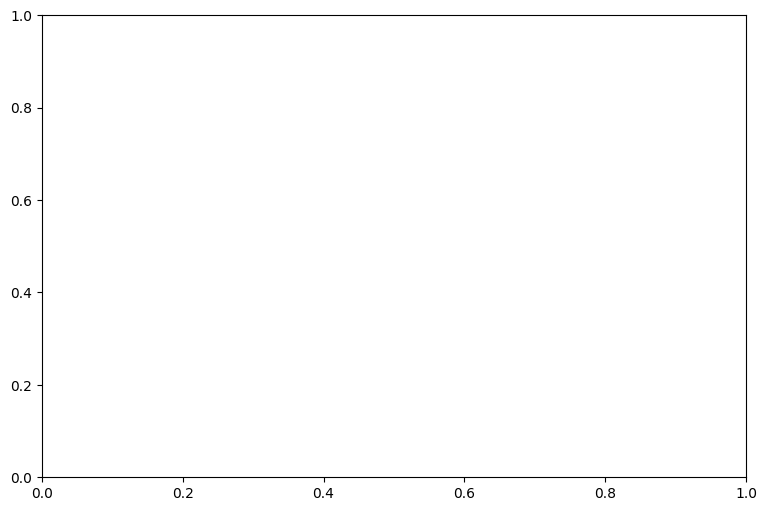

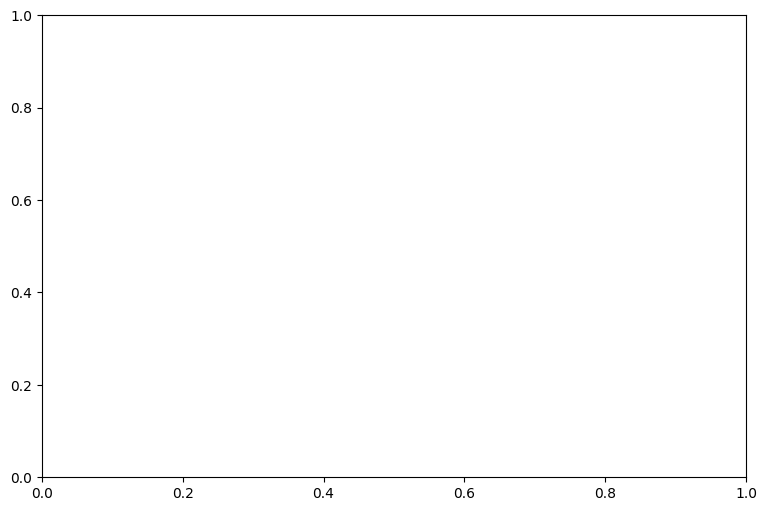

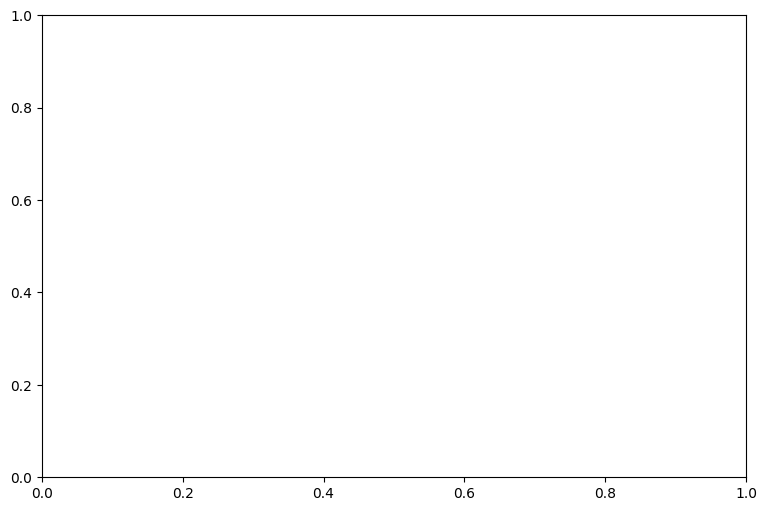

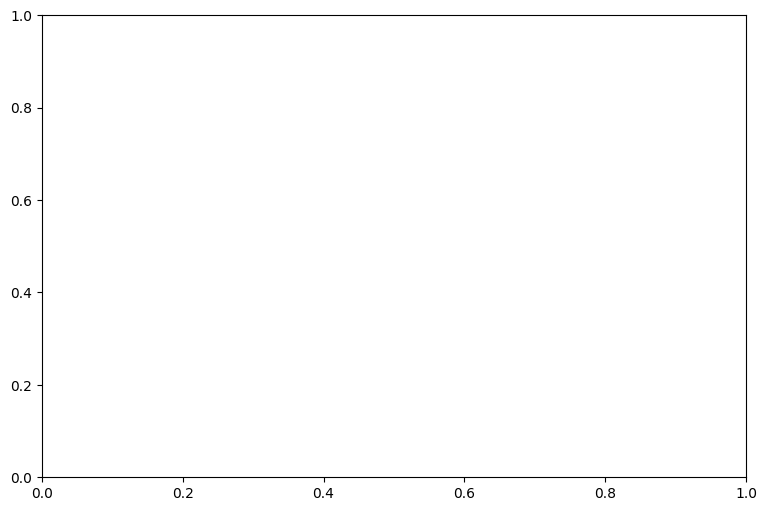

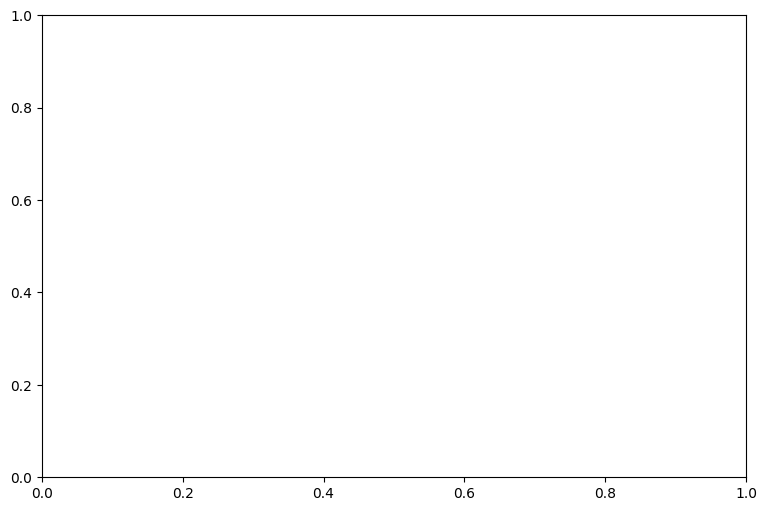

<Figure size 2000x600 with 0 Axes>

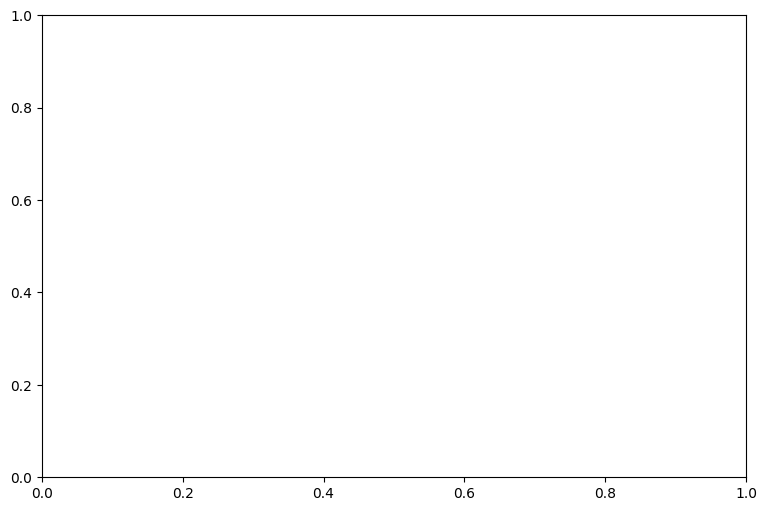

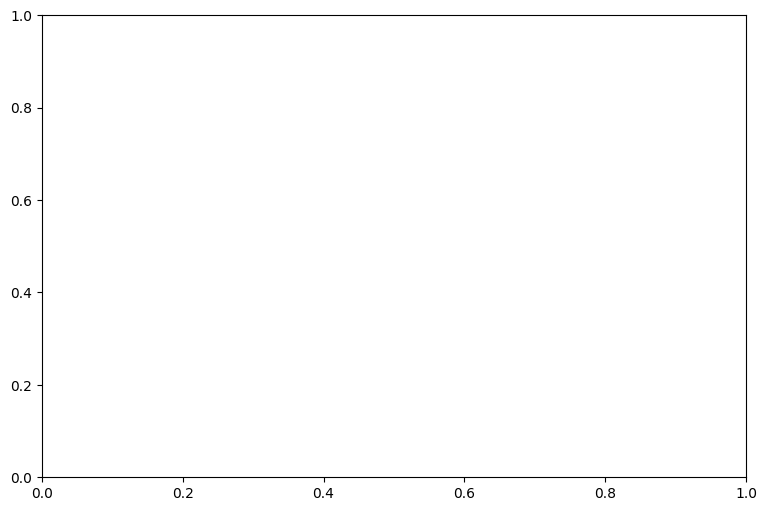

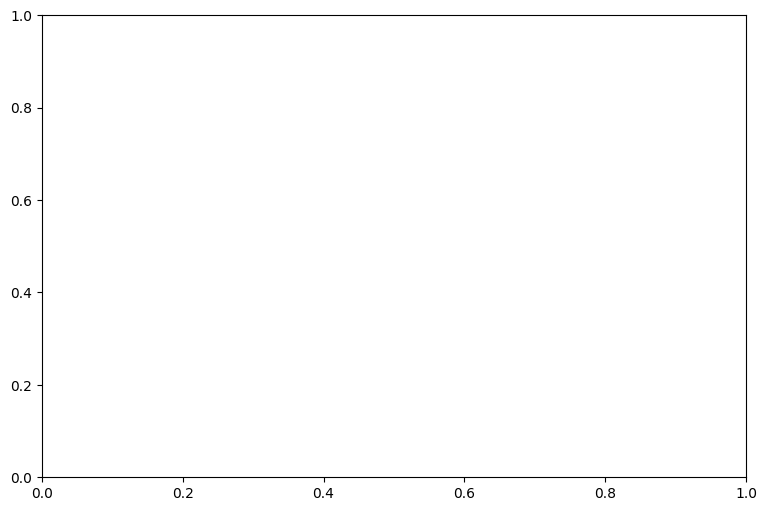

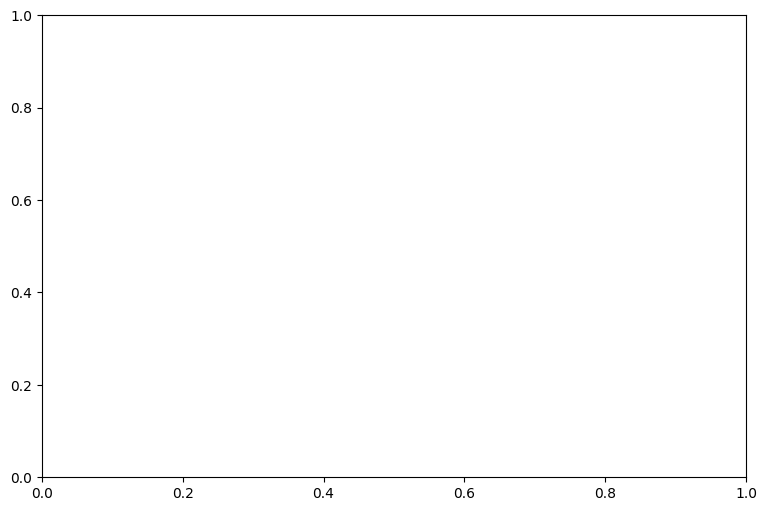

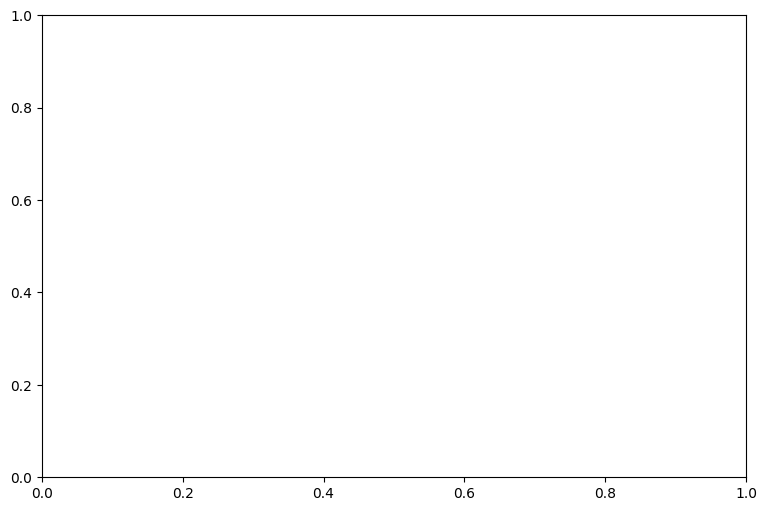

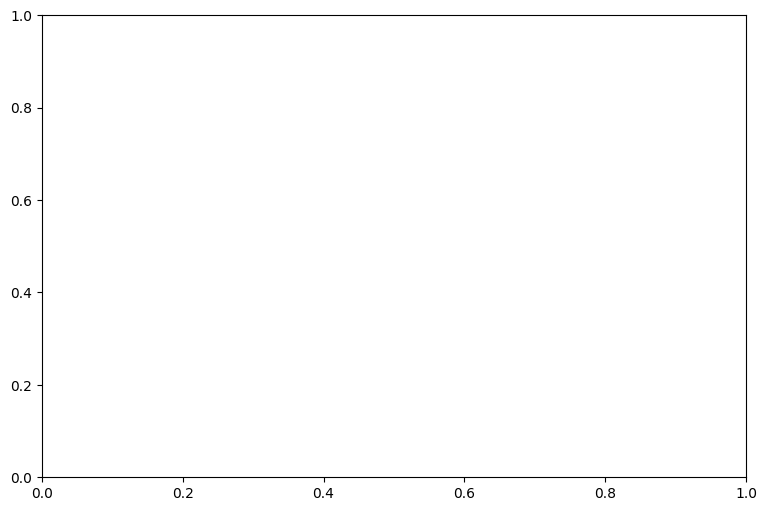

In [6]:

DEVICE = "cuda"

class Args:
    dataset = "xsum"
    dataset_key = "document"
    pct_words_masked = 0.3
    span_length = 2
    n_samples = 400
    n_perturbation_list = "100"
    n_perturbation_rounds = 1
    base_model_name = "meta-llama/Meta-Llama-3-8B"#"meta-llama/Llama-2-7b-chat-hf"
    scoring_model_name = ""
    mask_filling_model_name = "t5-3b"
    batch_size = 50
    chunk_size = 20
    n_similarity_samples = 20
    int8 = False
    half = False
    base_half = True
    do_top_k = True
    top_k = 40
    do_top_p = True
    top_p = 0.96
    output_name = ""
    openai_model = None  # Set this if using OpenAI API
    openai_key = None  # Set API key if using OpenAI
    baselines_only = True
    skip_baselines = False
    buffer_size = 1
    mask_top_p = 1.0
    pre_perturb_pct = 0.0
    pre_perturb_span_length = 5
    random_fills = False
    random_fills_tokens = False
    cache_dir = "./cache"

args = Args()  # Now all script references to `args.` will work


API_TOKEN_COUNTER = 0

if args.openai_model is not None:
    import openai
    assert args.openai_key is not None, "Must provide OpenAI API key as --openai_key"
    openai.api_key = args.openai_key

START_DATE = datetime.datetime.now().strftime('%Y-%m-%d')
START_TIME = datetime.datetime.now().strftime('%H-%M-%S-%f')

# define SAVE_FOLDER as the timestamp - base model name - mask filling model name
# create it if it doesn't exist
precision_string = "int8" if args.int8 else ("fp16" if args.half else "fp32")
sampling_string = "top_k" if args.do_top_k else ("top_p" if args.do_top_p else "temp")
output_subfolder = f"{args.output_name}/" if args.output_name else ""
if args.openai_model is None:
    base_model_name = args.base_model_name.replace('/', '_')
else:
    base_model_name = "openai-" + args.openai_model.replace('/', '_')
scoring_model_string = (f"-{args.scoring_model_name}" if args.scoring_model_name else "").replace('/', '_')
SAVE_FOLDER = f"/scratch/network/jl5951/tmp_results/{output_subfolder}{base_model_name}{scoring_model_string}-{args.mask_filling_model_name}-{sampling_string}/{START_DATE}-{START_TIME}-{precision_string}-{args.pct_words_masked}-{args.n_perturbation_rounds}-{args.dataset}-{args.n_samples}"
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)
print(f"Saving results to absolute path: {os.path.abspath(SAVE_FOLDER)}")

# write args to file
with open(os.path.join(SAVE_FOLDER, "args.json"), "w") as f:
    json.dump(args.__dict__, f, indent=4)

mask_filling_model_name = args.mask_filling_model_name
n_samples = args.n_samples
batch_size = args.batch_size
n_perturbation_list = [int(x) for x in args.n_perturbation_list.split(",")]
n_perturbation_rounds = args.n_perturbation_rounds
n_similarity_samples = args.n_similarity_samples

cache_dir = args.cache_dir
os.environ["XDG_CACHE_HOME"] = cache_dir
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
print(f"Using cache dir {cache_dir}")

GPT2_TOKENIZER = transformers.GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)

# generic generative model
base_model, base_tokenizer = load_base_model_and_tokenizer(args.base_model_name)

# mask filling t5 model
if not args.baselines_only and not args.random_fills:
    int8_kwargs = {}
    half_kwargs = {}
    if args.int8:
        int8_kwargs = dict(load_in_8bit=True, device_map='auto', torch_dtype=torch.bfloat16)
    elif args.half:
        half_kwargs = dict(torch_dtype=torch.bfloat16)
    print(f'Loading mask filling model {mask_filling_model_name}...')
    mask_model = transformers.AutoModelForSeq2SeqLM.from_pretrained(mask_filling_model_name, **int8_kwargs, **half_kwargs, cache_dir=cache_dir)
    
    try:
        n_positions = mask_model.config.n_positions
    except AttributeError:
        n_positions = 512
else:
    n_positions = 512
preproc_tokenizer = transformers.AutoTokenizer.from_pretrained('t5-small', model_max_length=512, cache_dir=cache_dir)
mask_tokenizer = transformers.AutoTokenizer.from_pretrained(mask_filling_model_name, padding_side='left', model_max_length=n_positions, cache_dir=cache_dir)
if args.dataset in ['english', 'german']:
    preproc_tokenizer = mask_tokenizer

load_base_model()

print(f'Loading dataset {args.dataset}...')
data = generate_data(args.dataset, args.dataset_key)
if args.random_fills:
    FILL_DICTIONARY = set()
    for texts in data.values():
        for text in texts:
            FILL_DICTIONARY.update(text.split())
    FILL_DICTIONARY = sorted(list(FILL_DICTIONARY))

if args.scoring_model_name:
    print(f'Loading SCORING model {args.scoring_model_name}...')
    del base_model
    del base_tokenizer
    torch.cuda.empty_cache()
    base_model, base_tokenizer = load_base_model_and_tokenizer(args.scoring_model_name)
    load_base_model()  # Load again because we've deleted/replaced the old model

# write the data to a json file in the save folder
with open(os.path.join(SAVE_FOLDER, "raw_data.json"), "w") as f:
    print(f"Writing raw data to {os.path.join(SAVE_FOLDER, 'raw_data.json')}")
    json.dump(data, f)

if not args.skip_baselines:
    baseline_outputs = [run_baseline_threshold_experiment(get_ll, "likelihood", n_samples=n_samples)]
    if args.openai_model is None:
        rank_criterion = lambda text: -get_rank(text, log=False)
        baseline_outputs.append(run_baseline_threshold_experiment(rank_criterion, "rank", n_samples=n_samples))
        logrank_criterion = lambda text: -get_rank(text, log=True)
        baseline_outputs.append(run_baseline_threshold_experiment(logrank_criterion, "log_rank", n_samples=n_samples))
        entropy_criterion = lambda text: get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(entropy_criterion, "entropy", n_samples=n_samples))
        liketropy_criterion = lambda text: get_ll(text)+get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(liketropy_criterion, "liketropy", n_samples=n_samples))
        binocular_criterion = lambda text: get_ll(text)/get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(binocular_criterion, "binocular", n_samples=n_samples))
    
    baseline_outputs.append(eval_supervised(data, model='roberta-base-openai-detector'))
    baseline_outputs.append(eval_supervised(data, model='roberta-large-openai-detector'))

outputs = []

if not args.baselines_only:
    # run perturbation experiments
    for n_perturbations in n_perturbation_list:
        perturbation_results = get_perturbation_results(args.span_length, n_perturbations, n_samples)
        for perturbation_mode in ['d', 'z']:
            output = run_perturbation_experiment(
                perturbation_results, perturbation_mode, span_length=args.span_length, n_perturbations=n_perturbations, n_samples=n_samples)
            outputs.append(output)
            with open(os.path.join(SAVE_FOLDER, f"perturbation_{n_perturbations}_{perturbation_mode}_results.json"), "w") as f:
                json.dump(output, f)

if not args.skip_baselines:
    # write likelihood threshold results to a file
    with open(os.path.join(SAVE_FOLDER, f"likelihood_threshold_results.json"), "w") as f:
        json.dump(baseline_outputs[0], f)

    if args.openai_model is None:
        # write rank threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"rank_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[1], f)

        # write log rank threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"logrank_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[2], f)

        # write entropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"entropy_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[3], f)

        # write liketropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"liketropy_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[4], f)

        # write liketropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"binocular_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[5], f)
    
    
    # write supervised results to a file
    with open(os.path.join(SAVE_FOLDER, f"roberta-base-openai-detector_results.json"), "w") as f:
        json.dump(baseline_outputs[-2], f)
    
    # write supervised results to a file
    with open(os.path.join(SAVE_FOLDER, f"roberta-large-openai-detector_results.json"), "w") as f:
        json.dump(baseline_outputs[-1], f)

    outputs += baseline_outputs

save_roc_curves(outputs)
save_ll_histograms(outputs)
save_llr_histograms(outputs)

# move results folder from tmp_results/ to results/, making sure necessary directories exist
new_folder = SAVE_FOLDER.replace("/scratch/network/jl5951/tmp_results", "/scratch/network/jl5951/results")
if not os.path.exists(os.path.dirname(new_folder)):
    os.makedirs(os.path.dirname(new_folder))
os.rename(SAVE_FOLDER, new_folder)

print(f"Used an *estimated* {API_TOKEN_COUNTER} API tokens (may be inaccurate)")




# LLAMA squad

Saving results to absolute path: /scratch/network/jl5951/tmp_results/meta-llama_Meta-Llama-3-8B-t5-3b-top_k/2025-03-24-01-38-59-359475-fp32-0.3-1-squad-400
Using cache dir ./cache
Loading BASE model meta-llama/Meta-Llama-3-8B...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

MOVING BASE MODEL TO GPU...DONE (4.86s)
Loading dataset squad...


README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (597 > 512). Running this sequence through the model will result in indexing errors


Total number of samples: 312
Average number of words: 282.31410256410254
Generating samples for batch 0 of 6
Generating samples for batch 1 of 6
Generating samples for batch 2 of 6
Generating samples for batch 3 of 6
Generating samples for batch 4 of 6
Generating samples for batch 5 of 6
Writing raw data to /scratch/network/jl5951/tmp_results/meta-llama_Meta-Llama-3-8B-t5-3b-top_k/2025-03-24-01-38-59-359475-fp32-0.3-1-squad-400/raw_data.json


Computing likelihood criterion: 100%|██████████| 8/8 [00:53<00:00,  6.68s/it]


likelihood_threshold ROC AUC: 0.8998999999999999, PR AUC: 0.8061503308413123, TP@low FPR: 0.0033333333333333335


Computing rank criterion: 100%|██████████| 8/8 [00:54<00:00,  6.84s/it]


rank_threshold ROC AUC: 0.7113111111111111, PR AUC: 0.7209574807330899, TP@low FPR: 0.06666666666666667


Computing log_rank criterion: 100%|██████████| 8/8 [00:54<00:00,  6.84s/it]


log_rank_threshold ROC AUC: 0.9287, PR AUC: 0.8450778927477469, TP@low FPR: 0.016666666666666666


Computing entropy criterion: 100%|██████████| 8/8 [00:53<00:00,  6.69s/it]


entropy_threshold ROC AUC: 0.3836555555555555, PR AUC: 0.41904920494806797, TP@low FPR: 0.0033333333333333335


Computing liketropy criterion: 100%|██████████| 8/8 [01:46<00:00, 13.35s/it]


liketropy_threshold ROC AUC: 0.9945666666666666, PR AUC: 0.9952744684915766, TP@low FPR: 0.9533333333333334


Computing binocular criterion: 100%|██████████| 8/8 [01:46<00:00, 13.35s/it]
Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


binocular_threshold ROC AUC: 0.997, PR AUC: 0.9966176328232964, TP@low FPR: 0.96
Beginning supervised evaluation with roberta-base-openai-detector...


Evaluating fake: 100%|██████████| 6/6 [00:00<00:00, 16.45it/s]


roberta-base-openai-detector ROC AUC: 0.9674222222222222, PR AUC: 0.9722443738308757
Beginning supervised evaluation with roberta-large-openai-detector...


Some weights of the model checkpoint at roberta-large-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Evaluating fake: 100%|██████████| 6/6 [00:01<00:00,  5.73it/s]


roberta-large-openai-detector ROC AUC: 0.9589000000000001, PR AUC: 0.9656947060977352
likelihood_threshold roc_auc: 0.900
rank_threshold roc_auc: 0.711
log_rank_threshold roc_auc: 0.929
entropy_threshold roc_auc: 0.384
liketropy_threshold roc_auc: 0.995
binocular_threshold roc_auc: 0.997
roberta-base-openai-detector roc_auc: 0.967
roberta-large-openai-detector roc_auc: 0.959
Used an *estimated* 0 API tokens (may be inaccurate)


<Figure size 1000x700 with 0 Axes>

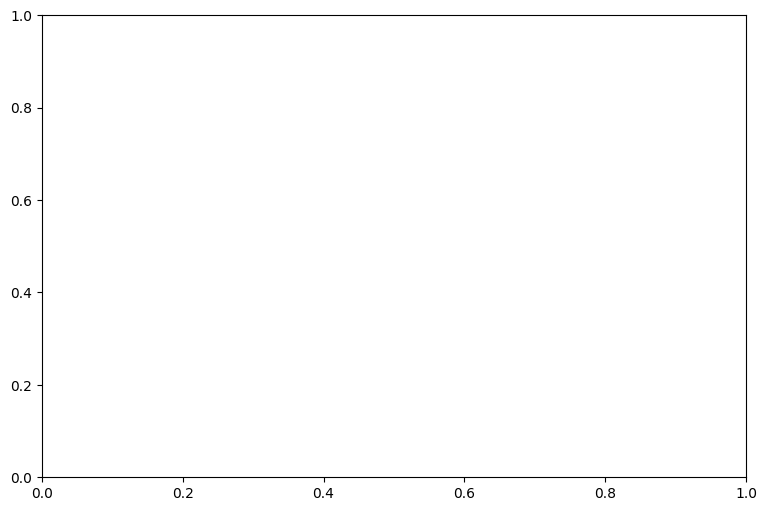

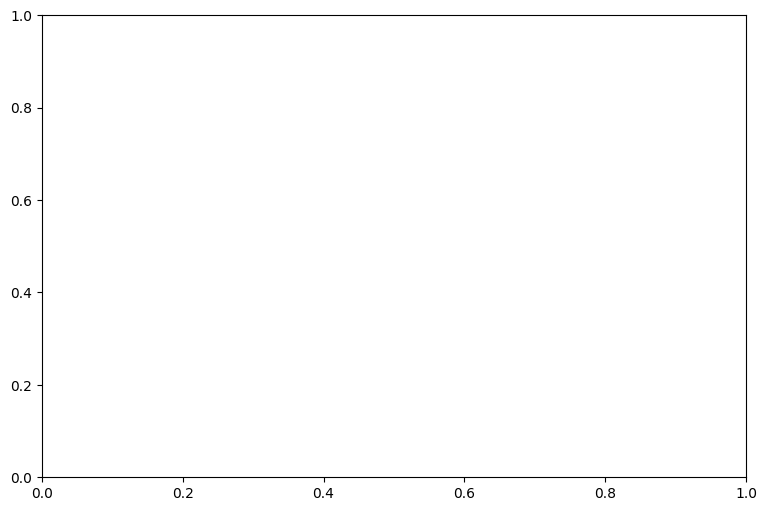

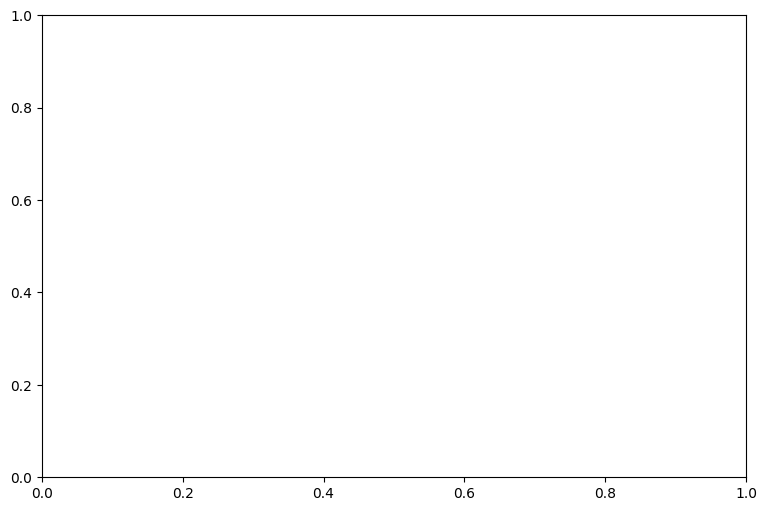

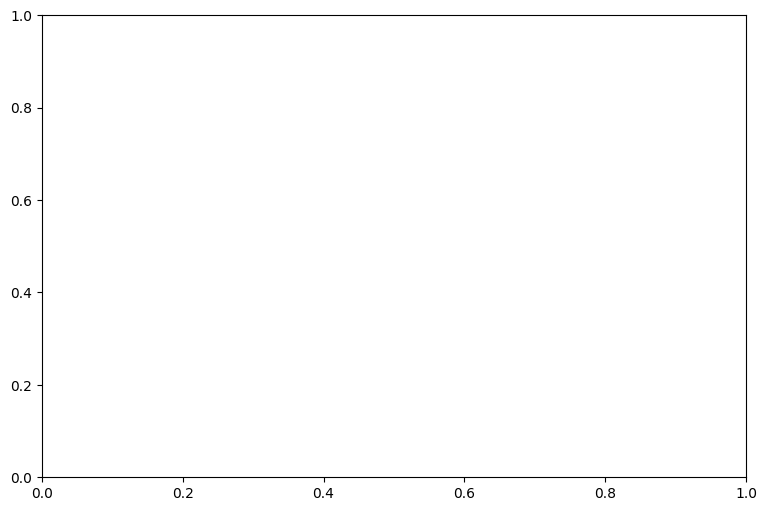

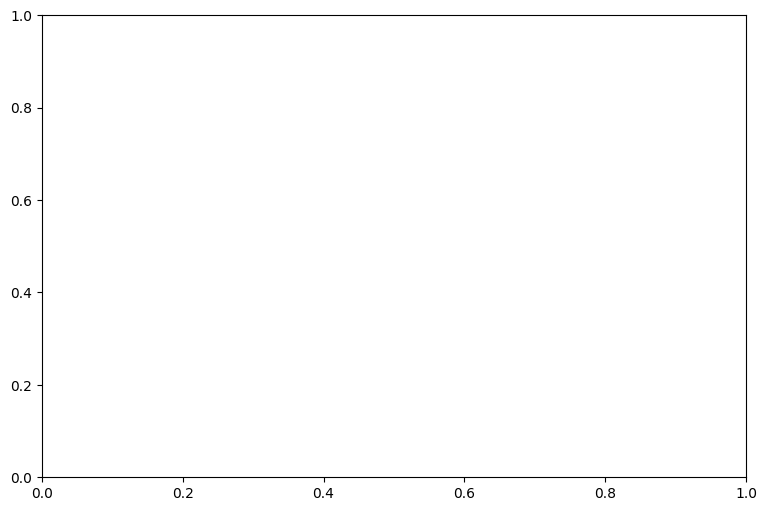

<Figure size 2000x600 with 0 Axes>

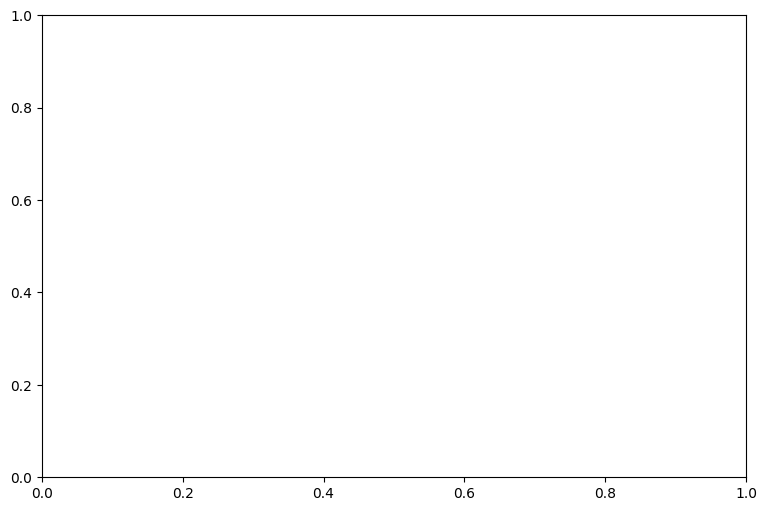

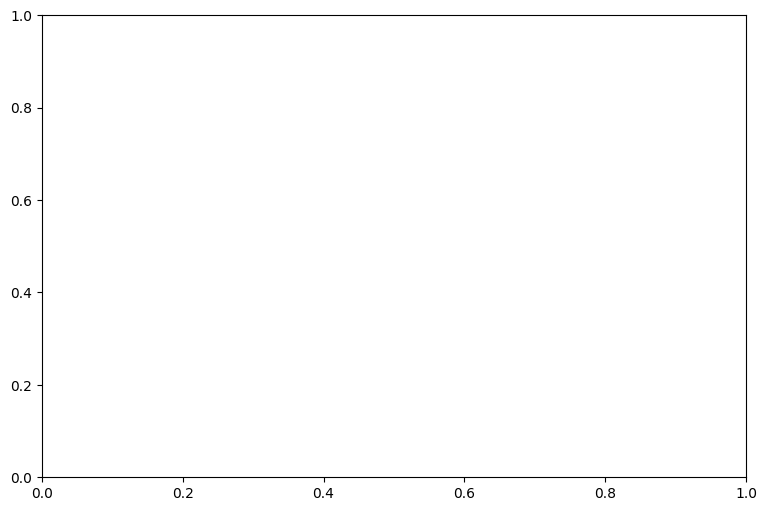

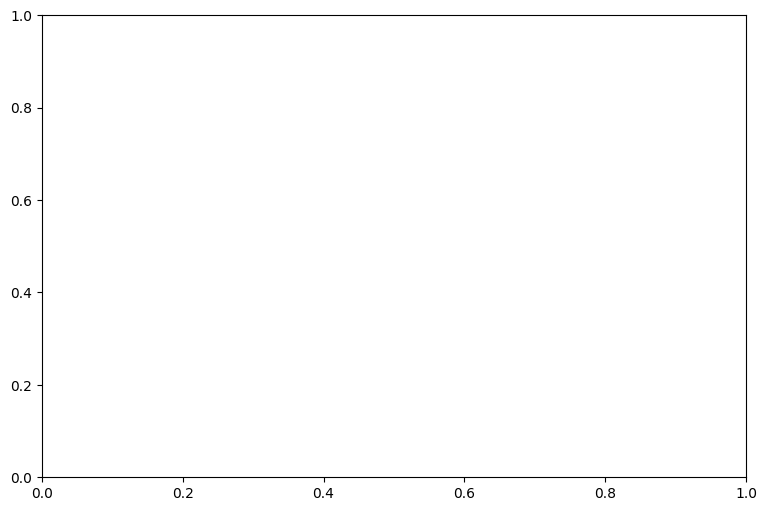

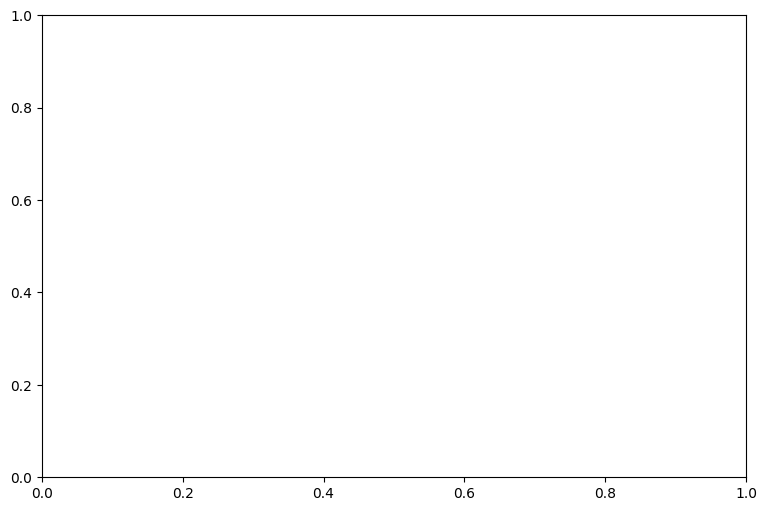

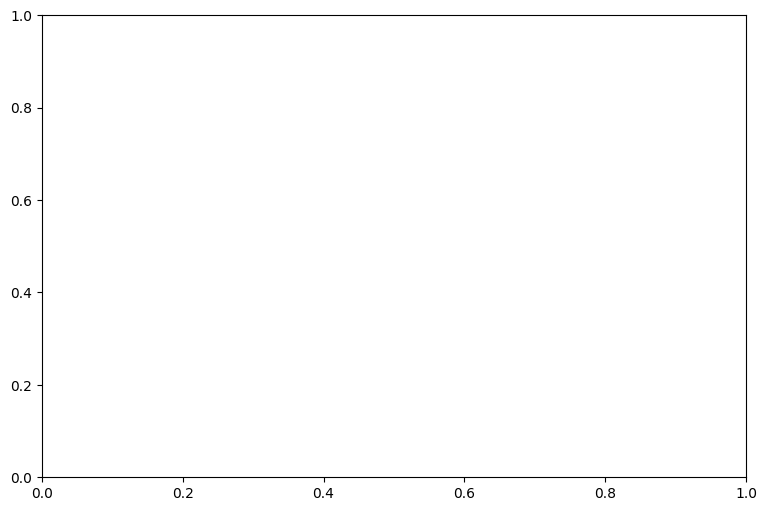

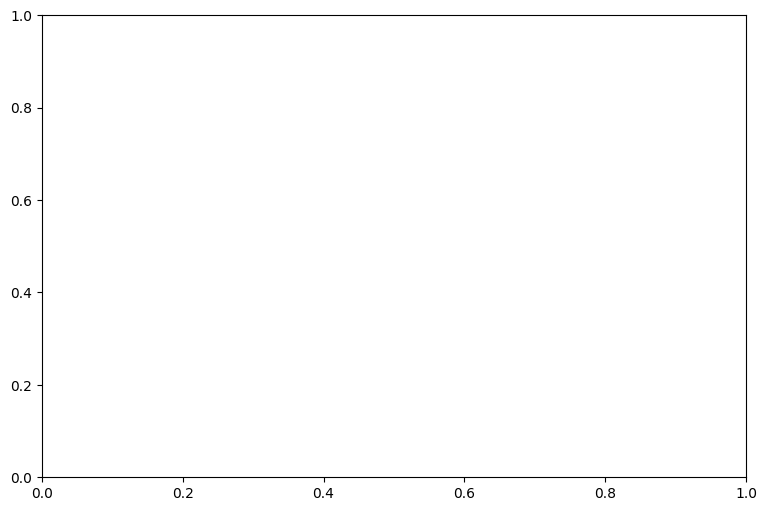

In [7]:

DEVICE = "cuda"

class Args:
    dataset = "squad"
    dataset_key = "context"
    pct_words_masked = 0.3
    span_length = 2
    n_samples = 400
    n_perturbation_list = "100"
    n_perturbation_rounds = 1
    base_model_name = "meta-llama/Meta-Llama-3-8B"#"meta-llama/Llama-2-7b-chat-hf"
    scoring_model_name = ""
    mask_filling_model_name = "t5-3b"
    batch_size = 50
    chunk_size = 20
    n_similarity_samples = 20
    int8 = False
    half = False
    base_half = True
    do_top_k = True
    top_k = 40
    do_top_p = True
    top_p = 0.96
    output_name = ""
    openai_model = None  # Set this if using OpenAI API
    openai_key = None  # Set API key if using OpenAI
    baselines_only = True
    skip_baselines = False
    buffer_size = 1
    mask_top_p = 1.0
    pre_perturb_pct = 0.0
    pre_perturb_span_length = 5
    random_fills = False
    random_fills_tokens = False
    cache_dir = "./cache"


args = Args()  # Now all script references to `args.` will work


API_TOKEN_COUNTER = 0

if args.openai_model is not None:
    import openai
    assert args.openai_key is not None, "Must provide OpenAI API key as --openai_key"
    openai.api_key = args.openai_key

START_DATE = datetime.datetime.now().strftime('%Y-%m-%d')
START_TIME = datetime.datetime.now().strftime('%H-%M-%S-%f')

# define SAVE_FOLDER as the timestamp - base model name - mask filling model name
# create it if it doesn't exist
precision_string = "int8" if args.int8 else ("fp16" if args.half else "fp32")
sampling_string = "top_k" if args.do_top_k else ("top_p" if args.do_top_p else "temp")
output_subfolder = f"{args.output_name}/" if args.output_name else ""
if args.openai_model is None:
    base_model_name = args.base_model_name.replace('/', '_')
else:
    base_model_name = "openai-" + args.openai_model.replace('/', '_')
scoring_model_string = (f"-{args.scoring_model_name}" if args.scoring_model_name else "").replace('/', '_')
SAVE_FOLDER = f"/scratch/network/jl5951/tmp_results/{output_subfolder}{base_model_name}{scoring_model_string}-{args.mask_filling_model_name}-{sampling_string}/{START_DATE}-{START_TIME}-{precision_string}-{args.pct_words_masked}-{args.n_perturbation_rounds}-{args.dataset}-{args.n_samples}"
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)
print(f"Saving results to absolute path: {os.path.abspath(SAVE_FOLDER)}")

# write args to file
with open(os.path.join(SAVE_FOLDER, "args.json"), "w") as f:
    json.dump(args.__dict__, f, indent=4)

mask_filling_model_name = args.mask_filling_model_name
n_samples = args.n_samples
batch_size = args.batch_size
n_perturbation_list = [int(x) for x in args.n_perturbation_list.split(",")]
n_perturbation_rounds = args.n_perturbation_rounds
n_similarity_samples = args.n_similarity_samples

cache_dir = args.cache_dir
os.environ["XDG_CACHE_HOME"] = cache_dir
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
print(f"Using cache dir {cache_dir}")

GPT2_TOKENIZER = transformers.GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)

# generic generative model
base_model, base_tokenizer = load_base_model_and_tokenizer(args.base_model_name)

# mask filling t5 model
if not args.baselines_only and not args.random_fills:
    int8_kwargs = {}
    half_kwargs = {}
    if args.int8:
        int8_kwargs = dict(load_in_8bit=True, device_map='auto', torch_dtype=torch.bfloat16)
    elif args.half:
        half_kwargs = dict(torch_dtype=torch.bfloat16)
    print(f'Loading mask filling model {mask_filling_model_name}...')
    mask_model = transformers.AutoModelForSeq2SeqLM.from_pretrained(mask_filling_model_name, **int8_kwargs, **half_kwargs, cache_dir=cache_dir)
    
    try:
        n_positions = mask_model.config.n_positions
    except AttributeError:
        n_positions = 512
else:
    n_positions = 512
preproc_tokenizer = transformers.AutoTokenizer.from_pretrained('t5-small', model_max_length=512, cache_dir=cache_dir)
mask_tokenizer = transformers.AutoTokenizer.from_pretrained(mask_filling_model_name, padding_side='left', model_max_length=n_positions, cache_dir=cache_dir)
if args.dataset in ['english', 'german']:
    preproc_tokenizer = mask_tokenizer

load_base_model()

print(f'Loading dataset {args.dataset}...')
data = generate_data(args.dataset, args.dataset_key)
if args.random_fills:
    FILL_DICTIONARY = set()
    for texts in data.values():
        for text in texts:
            FILL_DICTIONARY.update(text.split())
    FILL_DICTIONARY = sorted(list(FILL_DICTIONARY))

if args.scoring_model_name:
    print(f'Loading SCORING model {args.scoring_model_name}...')
    del base_model
    del base_tokenizer
    torch.cuda.empty_cache()
    base_model, base_tokenizer = load_base_model_and_tokenizer(args.scoring_model_name)
    load_base_model()  # Load again because we've deleted/replaced the old model

# write the data to a json file in the save folder
with open(os.path.join(SAVE_FOLDER, "raw_data.json"), "w") as f:
    print(f"Writing raw data to {os.path.join(SAVE_FOLDER, 'raw_data.json')}")
    json.dump(data, f)

if not args.skip_baselines:
    baseline_outputs = [run_baseline_threshold_experiment(get_ll, "likelihood", n_samples=n_samples)]
    if args.openai_model is None:
        rank_criterion = lambda text: -get_rank(text, log=False)
        baseline_outputs.append(run_baseline_threshold_experiment(rank_criterion, "rank", n_samples=n_samples))
        logrank_criterion = lambda text: -get_rank(text, log=True)
        baseline_outputs.append(run_baseline_threshold_experiment(logrank_criterion, "log_rank", n_samples=n_samples))
        entropy_criterion = lambda text: get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(entropy_criterion, "entropy", n_samples=n_samples))
        liketropy_criterion = lambda text: abs(get_ll(text)+get_entropy(text))
        baseline_outputs.append(run_baseline_threshold_experiment(liketropy_criterion, "liketropy", n_samples=n_samples))
        binocular_criterion = lambda text: get_ll(text)/get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(binocular_criterion, "binocular", n_samples=n_samples))
    
    baseline_outputs.append(eval_supervised(data, model='roberta-base-openai-detector'))
    baseline_outputs.append(eval_supervised(data, model='roberta-large-openai-detector'))

outputs = []

if not args.baselines_only:
    # run perturbation experiments
    for n_perturbations in n_perturbation_list:
        perturbation_results = get_perturbation_results(args.span_length, n_perturbations, n_samples)
        for perturbation_mode in ['d', 'z']:
            output = run_perturbation_experiment(
                perturbation_results, perturbation_mode, span_length=args.span_length, n_perturbations=n_perturbations, n_samples=n_samples)
            outputs.append(output)
            with open(os.path.join(SAVE_FOLDER, f"perturbation_{n_perturbations}_{perturbation_mode}_results.json"), "w") as f:
                json.dump(output, f)

if not args.skip_baselines:
    # write likelihood threshold results to a file
    with open(os.path.join(SAVE_FOLDER, f"likelihood_threshold_results.json"), "w") as f:
        json.dump(baseline_outputs[0], f)

    if args.openai_model is None:
        # write rank threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"rank_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[1], f)

        # write log rank threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"logrank_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[2], f)

        # write entropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"entropy_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[3], f)

        # write liketropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"liketropy_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[4], f)

        # write liketropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"binocular_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[5], f)
    
    
    # write supervised results to a file
    with open(os.path.join(SAVE_FOLDER, f"roberta-base-openai-detector_results.json"), "w") as f:
        json.dump(baseline_outputs[-2], f)
    
    # write supervised results to a file
    with open(os.path.join(SAVE_FOLDER, f"roberta-large-openai-detector_results.json"), "w") as f:
        json.dump(baseline_outputs[-1], f)

    outputs += baseline_outputs

save_roc_curves(outputs)
save_ll_histograms(outputs)
save_llr_histograms(outputs)

# move results folder from tmp_results/ to results/, making sure necessary directories exist
new_folder = SAVE_FOLDER.replace("/scratch/network/jl5951/tmp_results", "/scratch/network/jl5951/results")
if not os.path.exists(os.path.dirname(new_folder)):
    os.makedirs(os.path.dirname(new_folder))
os.rename(SAVE_FOLDER, new_folder)

print(f"Used an *estimated* {API_TOKEN_COUNTER} API tokens (may be inaccurate)")



# LLAMA writing

Saving results to absolute path: /scratch/network/jl5951/tmp_results/meta-llama_Meta-Llama-3-8B-t5-3b-top_k/2025-03-24-01-47-21-071722-fp32-0.3-1-writing-200
Using cache dir ./cache
Loading BASE model meta-llama/Meta-Llama-3-8B...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

MOVING BASE MODEL TO GPU...DONE (5.17s)
Loading dataset writing...


Token indices sequence length is longer than the specified maximum sequence length for this model (706 > 512). Running this sequence through the model will result in indexing errors


Total number of samples: 1011
Average number of words: 309.6142433234421
Generating samples for batch 0 of 4
Generating samples for batch 1 of 4
Generating samples for batch 2 of 4
Generating samples for batch 3 of 4
Writing raw data to /scratch/network/jl5951/tmp_results/meta-llama_Meta-Llama-3-8B-t5-3b-top_k/2025-03-24-01-47-21-071722-fp32-0.3-1-writing-200/raw_data.json


Computing likelihood criterion: 100%|██████████| 4/4 [00:35<00:00,  8.92s/it]


likelihood_threshold ROC AUC: 1.0, PR AUC: 1.0, TP@low FPR: 1.0


Computing rank criterion: 100%|██████████| 4/4 [00:36<00:00,  9.14s/it]


rank_threshold ROC AUC: 0.8235, PR AUC: 0.8666063974476839, TP@low FPR: 0.49


Computing log_rank criterion: 100%|██████████| 4/4 [00:36<00:00,  9.14s/it]


log_rank_threshold ROC AUC: 1.0, PR AUC: 1.0, TP@low FPR: 1.0


Computing entropy criterion: 100%|██████████| 4/4 [00:35<00:00,  8.94s/it]


entropy_threshold ROC AUC: 0.041800000000000004, PR AUC: 0.3095214813824745, TP@low FPR: 0.0


Computing liketropy criterion: 100%|██████████| 4/4 [01:11<00:00, 17.85s/it]


liketropy_threshold ROC AUC: 0.9871, PR AUC: 0.9892565847608125, TP@low FPR: 0.895


Computing binocular criterion: 100%|██████████| 4/4 [01:11<00:00, 17.85s/it]
Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


binocular_threshold ROC AUC: 0.9925, PR AUC: 0.9949271907627565, TP@low FPR: 0.975
Beginning supervised evaluation with roberta-base-openai-detector...


Evaluating fake: 100%|██████████| 4/4 [00:00<00:00, 14.34it/s]
Some weights of the model checkpoint at roberta-large-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


roberta-base-openai-detector ROC AUC: 0.979025, PR AUC: 0.9857874740827199
Beginning supervised evaluation with roberta-large-openai-detector...


Evaluating fake: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


roberta-large-openai-detector ROC AUC: 0.96835, PR AUC: 0.9713605163252707
likelihood_threshold roc_auc: 1.000
rank_threshold roc_auc: 0.824
log_rank_threshold roc_auc: 1.000
entropy_threshold roc_auc: 0.042
liketropy_threshold roc_auc: 0.987
binocular_threshold roc_auc: 0.993
roberta-base-openai-detector roc_auc: 0.979
roberta-large-openai-detector roc_auc: 0.968
Used an *estimated* 0 API tokens (may be inaccurate)


<Figure size 1000x700 with 0 Axes>

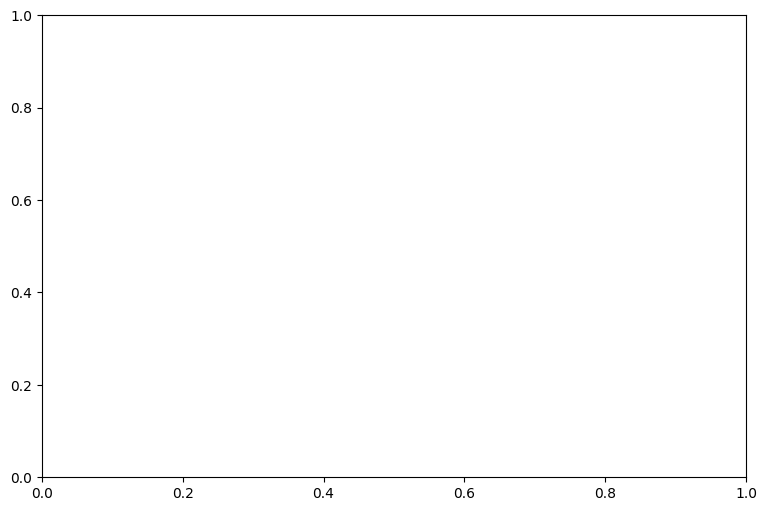

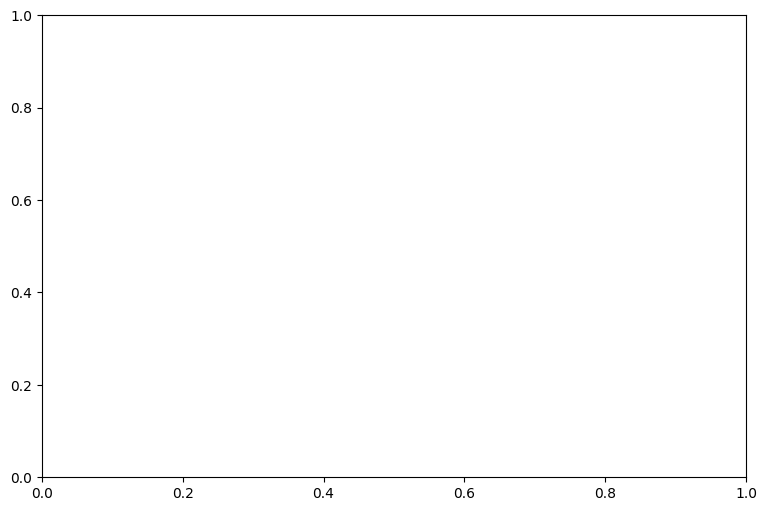

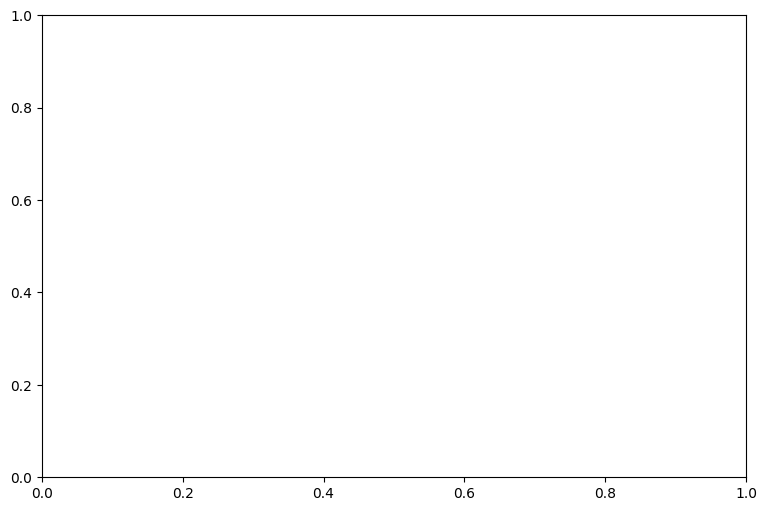

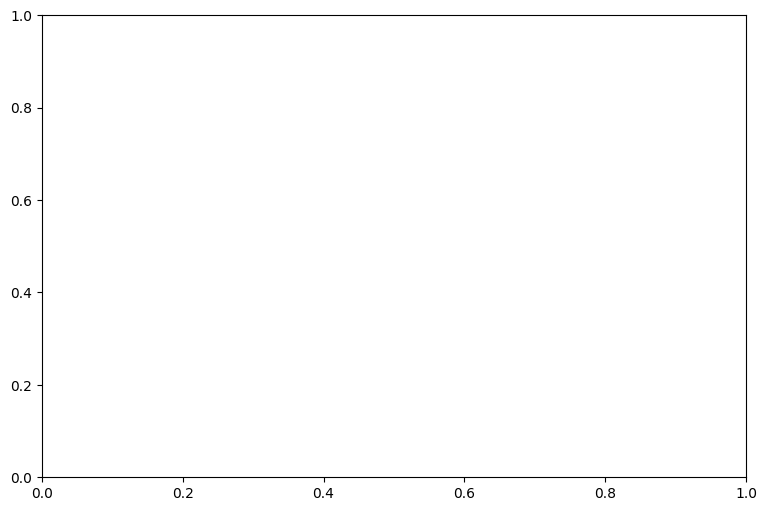

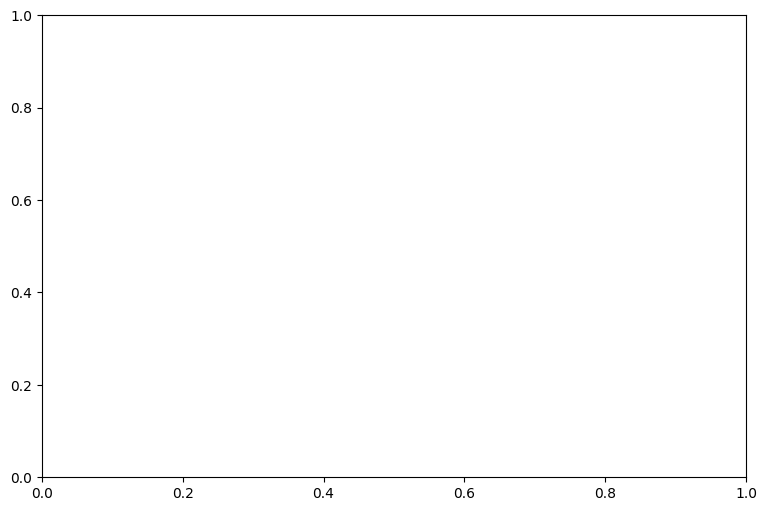

<Figure size 2000x600 with 0 Axes>

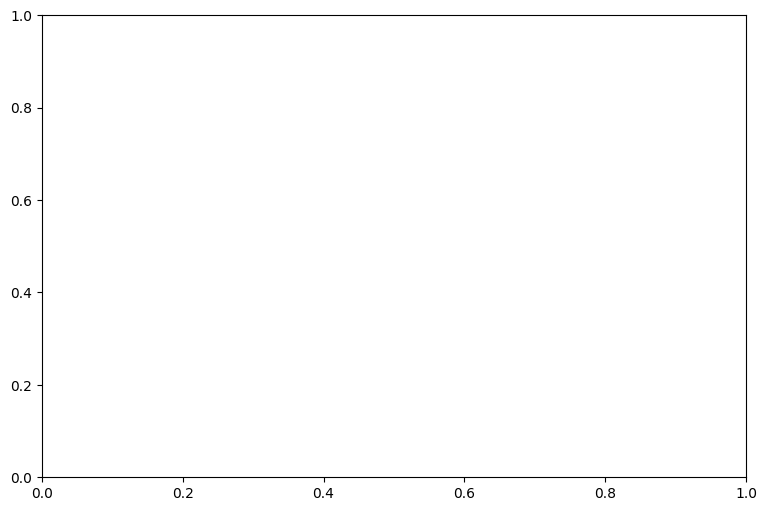

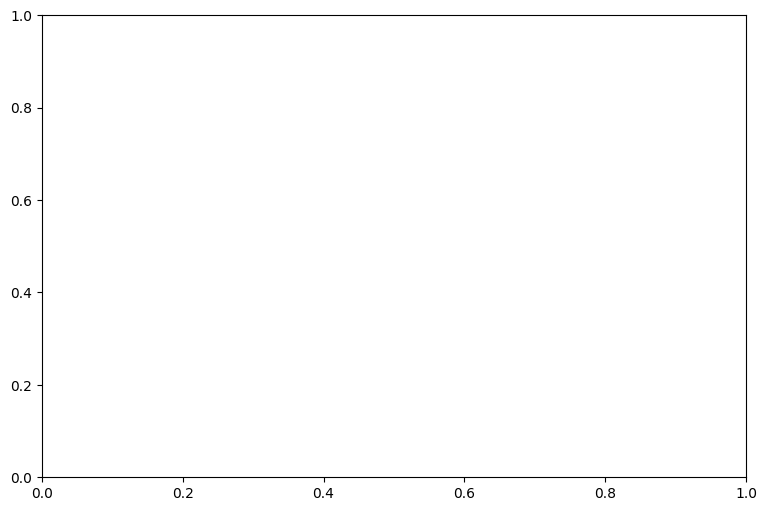

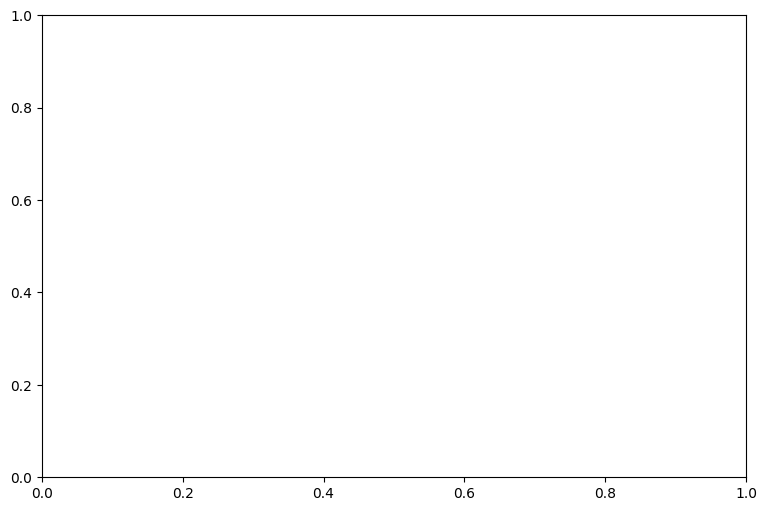

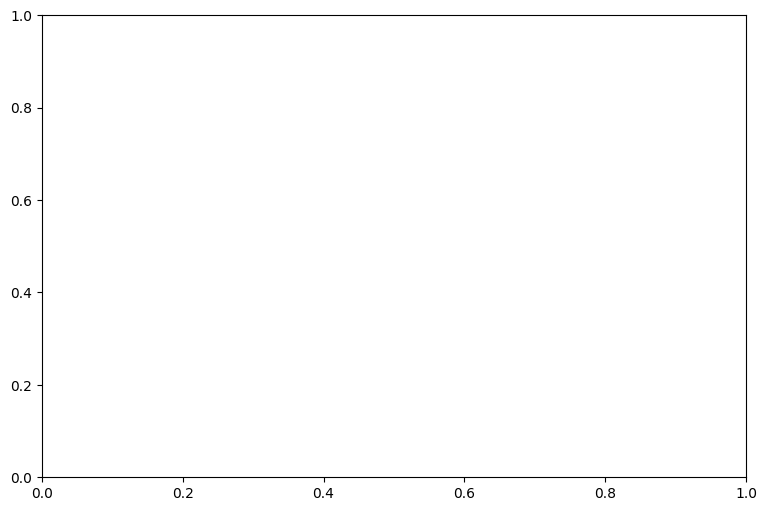

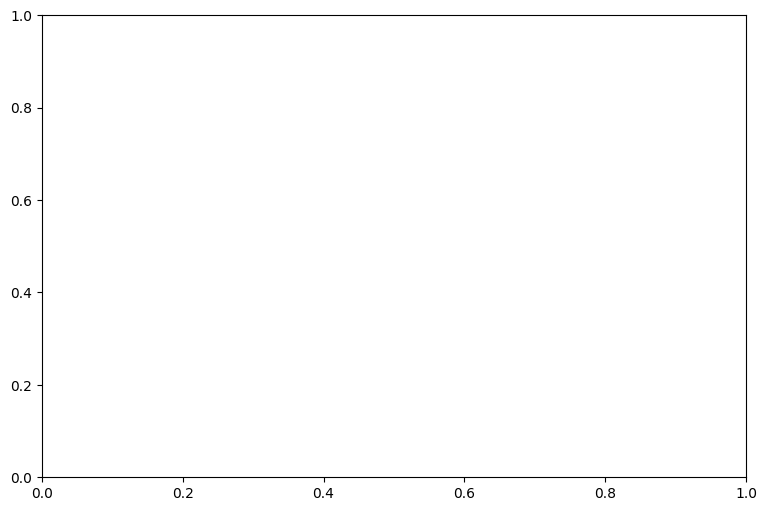

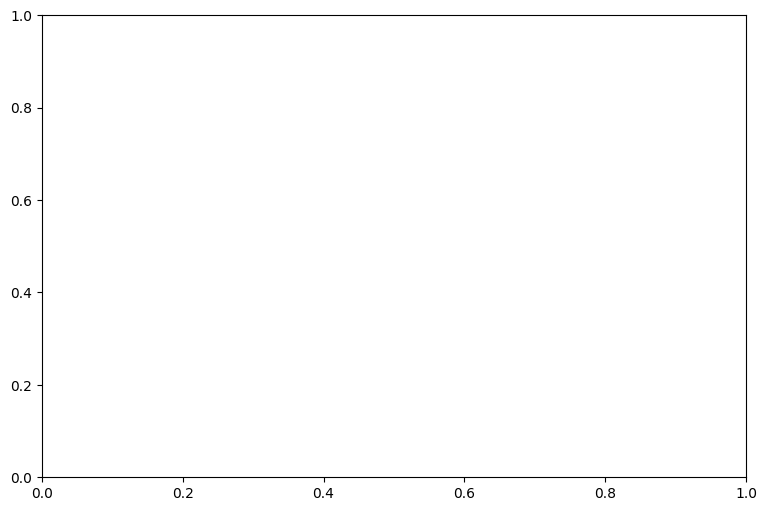

In [8]:

DEVICE = "cuda"

class Args:
    dataset = "writing"
    dataset_key = "story"
    pct_words_masked = 0.3
    span_length = 2
    n_samples = 200
    n_perturbation_list = "400"
    n_perturbation_rounds = 1
    base_model_name = "meta-llama/Meta-Llama-3-8B"#"meta-llama/Llama-2-7b-chat-hf"
    scoring_model_name = ""
    mask_filling_model_name = "t5-3b"
    batch_size = 50
    chunk_size = 20
    n_similarity_samples = 20
    int8 = False
    half = False
    base_half = True
    do_top_k = True
    top_k = 40
    do_top_p = True
    top_p = 0.96
    output_name = ""
    openai_model = None  # Set this if using OpenAI API
    openai_key = None  # Set API key if using OpenAI
    baselines_only = True
    skip_baselines = False
    buffer_size = 1
    mask_top_p = 1.0
    pre_perturb_pct = 0.0
    pre_perturb_span_length = 5
    random_fills = False
    random_fills_tokens = False
    cache_dir = "./cache"

args = Args()  # Now all script references to `args.` will work


API_TOKEN_COUNTER = 0

if args.openai_model is not None:
    import openai
    assert args.openai_key is not None, "Must provide OpenAI API key as --openai_key"
    openai.api_key = args.openai_key

START_DATE = datetime.datetime.now().strftime('%Y-%m-%d')
START_TIME = datetime.datetime.now().strftime('%H-%M-%S-%f')

# define SAVE_FOLDER as the timestamp - base model name - mask filling model name
# create it if it doesn't exist
precision_string = "int8" if args.int8 else ("fp16" if args.half else "fp32")
sampling_string = "top_k" if args.do_top_k else ("top_p" if args.do_top_p else "temp")
output_subfolder = f"{args.output_name}/" if args.output_name else ""
if args.openai_model is None:
    base_model_name = args.base_model_name.replace('/', '_')
else:
    base_model_name = "openai-" + args.openai_model.replace('/', '_')
scoring_model_string = (f"-{args.scoring_model_name}" if args.scoring_model_name else "").replace('/', '_')
SAVE_FOLDER = f"/scratch/network/jl5951/tmp_results/{output_subfolder}{base_model_name}{scoring_model_string}-{args.mask_filling_model_name}-{sampling_string}/{START_DATE}-{START_TIME}-{precision_string}-{args.pct_words_masked}-{args.n_perturbation_rounds}-{args.dataset}-{args.n_samples}"
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)
print(f"Saving results to absolute path: {os.path.abspath(SAVE_FOLDER)}")

# write args to file
with open(os.path.join(SAVE_FOLDER, "args.json"), "w") as f:
    json.dump(args.__dict__, f, indent=4)

mask_filling_model_name = args.mask_filling_model_name
n_samples = args.n_samples
batch_size = args.batch_size
n_perturbation_list = [int(x) for x in args.n_perturbation_list.split(",")]
n_perturbation_rounds = args.n_perturbation_rounds
n_similarity_samples = args.n_similarity_samples

cache_dir = args.cache_dir
os.environ["XDG_CACHE_HOME"] = cache_dir
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
print(f"Using cache dir {cache_dir}")

GPT2_TOKENIZER = transformers.GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)

# generic generative model
base_model, base_tokenizer = load_base_model_and_tokenizer(args.base_model_name)

# mask filling t5 model
if not args.baselines_only and not args.random_fills:
    int8_kwargs = {}
    half_kwargs = {}
    if args.int8:
        int8_kwargs = dict(load_in_8bit=True, device_map='auto', torch_dtype=torch.bfloat16)
    elif args.half:
        half_kwargs = dict(torch_dtype=torch.bfloat16)
    print(f'Loading mask filling model {mask_filling_model_name}...')
    mask_model = transformers.AutoModelForSeq2SeqLM.from_pretrained(mask_filling_model_name, **int8_kwargs, **half_kwargs, cache_dir=cache_dir)
    
    try:
        n_positions = mask_model.config.n_positions
    except AttributeError:
        n_positions = 512
else:
    n_positions = 512
preproc_tokenizer = transformers.AutoTokenizer.from_pretrained('t5-small', model_max_length=512, cache_dir=cache_dir)
mask_tokenizer = transformers.AutoTokenizer.from_pretrained(mask_filling_model_name, padding_side='left', model_max_length=n_positions, cache_dir=cache_dir)
if args.dataset in ['english', 'german']:
    preproc_tokenizer = mask_tokenizer

load_base_model()

print(f'Loading dataset {args.dataset}...')
data = generate_data(args.dataset, args.dataset_key)
if args.random_fills:
    FILL_DICTIONARY = set()
    for texts in data.values():
        for text in texts:
            FILL_DICTIONARY.update(text.split())
    FILL_DICTIONARY = sorted(list(FILL_DICTIONARY))

if args.scoring_model_name:
    print(f'Loading SCORING model {args.scoring_model_name}...')
    del base_model
    del base_tokenizer
    torch.cuda.empty_cache()
    base_model, base_tokenizer = load_base_model_and_tokenizer(args.scoring_model_name)
    load_base_model()  # Load again because we've deleted/replaced the old model

# write the data to a json file in the save folder
with open(os.path.join(SAVE_FOLDER, "raw_data.json"), "w") as f:
    print(f"Writing raw data to {os.path.join(SAVE_FOLDER, 'raw_data.json')}")
    json.dump(data, f)

if not args.skip_baselines:
    baseline_outputs = [run_baseline_threshold_experiment(get_ll, "likelihood", n_samples=n_samples)]
    if args.openai_model is None:
        rank_criterion = lambda text: -get_rank(text, log=False)
        baseline_outputs.append(run_baseline_threshold_experiment(rank_criterion, "rank", n_samples=n_samples))
        logrank_criterion = lambda text: -get_rank(text, log=True)
        baseline_outputs.append(run_baseline_threshold_experiment(logrank_criterion, "log_rank", n_samples=n_samples))
        entropy_criterion = lambda text: get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(entropy_criterion, "entropy", n_samples=n_samples))
        liketropy_criterion = lambda text: get_ll(text)+get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(liketropy_criterion, "liketropy", n_samples=n_samples))
        binocular_criterion = lambda text: get_ll(text)/get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(binocular_criterion, "binocular", n_samples=n_samples))
    
    baseline_outputs.append(eval_supervised(data, model='roberta-base-openai-detector'))
    baseline_outputs.append(eval_supervised(data, model='roberta-large-openai-detector'))

outputs = []

if not args.baselines_only:
    # run perturbation experiments
    for n_perturbations in n_perturbation_list:
        perturbation_results = get_perturbation_results(args.span_length, n_perturbations, n_samples)
        for perturbation_mode in ['d', 'z']:
            output = run_perturbation_experiment(
                perturbation_results, perturbation_mode, span_length=args.span_length, n_perturbations=n_perturbations, n_samples=n_samples)
            outputs.append(output)
            with open(os.path.join(SAVE_FOLDER, f"perturbation_{n_perturbations}_{perturbation_mode}_results.json"), "w") as f:
                json.dump(output, f)

if not args.skip_baselines:
    # write likelihood threshold results to a file
    with open(os.path.join(SAVE_FOLDER, f"likelihood_threshold_results.json"), "w") as f:
        json.dump(baseline_outputs[0], f)

    if args.openai_model is None:
        # write rank threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"rank_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[1], f)

        # write log rank threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"logrank_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[2], f)

        # write entropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"entropy_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[3], f)

        # write liketropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"liketropy_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[4], f)

        # write liketropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"binocular_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[5], f)
    
    
    # write supervised results to a file
    with open(os.path.join(SAVE_FOLDER, f"roberta-base-openai-detector_results.json"), "w") as f:
        json.dump(baseline_outputs[-2], f)
    
    # write supervised results to a file
    with open(os.path.join(SAVE_FOLDER, f"roberta-large-openai-detector_results.json"), "w") as f:
        json.dump(baseline_outputs[-1], f)

    outputs += baseline_outputs

save_roc_curves(outputs)
save_ll_histograms(outputs)
save_llr_histograms(outputs)

# move results folder from tmp_results/ to results/, making sure necessary directories exist
new_folder = SAVE_FOLDER.replace("/scratch/network/jl5951/tmp_results", "/scratch/network/jl5951/results")
if not os.path.exists(os.path.dirname(new_folder)):
    os.makedirs(os.path.dirname(new_folder))
os.rename(SAVE_FOLDER, new_folder)

print(f"Used an *estimated* {API_TOKEN_COUNTER} API tokens (may be inaccurate)")



# neox Xsum

Saving results to absolute path: /scratch/network/jl5951/tmp_results/KoboldAI_GPT-NeoX-20B-Erebus-t5-3b-top_k/2025-03-24-01-53-02-456996-fp32-0.3-1-xsum-400
Using cache dir ./cache
Loading BASE model KoboldAI/GPT-NeoX-20B-Erebus...


config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/57.7k [00:00<?, ?B/s]

Fetching 23 files:   0%|          | 0/23 [00:00<?, ?it/s]

pytorch_model-00006-of-00023.bin:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

pytorch_model-00001-of-00023.bin:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

pytorch_model-00005-of-00023.bin:   0%|          | 0.00/1.90G [00:00<?, ?B/s]

pytorch_model-00004-of-00023.bin:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

pytorch_model-00003-of-00023.bin:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

pytorch_model-00002-of-00023.bin:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

pytorch_model-00007-of-00023.bin:   0%|          | 0.00/1.76G [00:00<?, ?B/s]

pytorch_model-00008-of-00023.bin:   0%|          | 0.00/1.90G [00:00<?, ?B/s]

pytorch_model-00009-of-00023.bin:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

pytorch_model-00010-of-00023.bin:   0%|          | 0.00/1.83G [00:00<?, ?B/s]

pytorch_model-00012-of-00023.bin:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

pytorch_model-00011-of-00023.bin:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

pytorch_model-00013-of-00023.bin:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

pytorch_model-00014-of-00023.bin:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

pytorch_model-00015-of-00023.bin:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

pytorch_model-00016-of-00023.bin:   0%|          | 0.00/1.90G [00:00<?, ?B/s]

pytorch_model-00017-of-00023.bin:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

pytorch_model-00018-of-00023.bin:   0%|          | 0.00/1.44G [00:00<?, ?B/s]

pytorch_model-00019-of-00023.bin:   0%|          | 0.00/1.83G [00:00<?, ?B/s]

pytorch_model-00020-of-00023.bin:   0%|          | 0.00/1.81G [00:00<?, ?B/s]

pytorch_model-00021-of-00023.bin:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

pytorch_model-00022-of-00023.bin:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

pytorch_model-00023-of-00023.bin:   0%|          | 0.00/302M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/23 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/157 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/457k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/91.0 [00:00<?, ?B/s]

MOVING BASE MODEL TO GPU...DONE (12.45s)
Loading dataset xsum...


Token indices sequence length is longer than the specified maximum sequence length for this model (853 > 512). Running this sequence through the model will result in indexing errors


Total number of samples: 1829
Average number of words: 306.9710224166211
Generating samples for batch 0 of 8
Generating samples for batch 1 of 8
Generating samples for batch 2 of 8
Generating samples for batch 3 of 8
Generating samples for batch 4 of 8
Generating samples for batch 5 of 8
Generating samples for batch 6 of 8
Generating samples for batch 7 of 8
Writing raw data to /scratch/network/jl5951/tmp_results/KoboldAI_GPT-NeoX-20B-Erebus-t5-3b-top_k/2025-03-24-01-53-02-456996-fp32-0.3-1-xsum-400/raw_data.json


Computing likelihood criterion: 100%|██████████| 8/8 [03:49<00:00, 28.69s/it]


likelihood_threshold ROC AUC: 0.8104250000000001, PR AUC: 0.7593956829395186, TP@low FPR: 0.0225


Computing rank criterion: 100%|██████████| 8/8 [03:50<00:00, 28.77s/it]


rank_threshold ROC AUC: 0.6842750000000001, PR AUC: 0.7132972229340468, TP@low FPR: 0.055


Computing log_rank criterion: 100%|██████████| 8/8 [03:50<00:00, 28.78s/it]


log_rank_threshold ROC AUC: 0.8515406249999999, PR AUC: 0.8081714386788719, TP@low FPR: 0.045


Computing entropy criterion: 100%|██████████| 8/8 [03:49<00:00, 28.69s/it]


entropy_threshold ROC AUC: 0.7324312500000001, PR AUC: 0.7362695202373797, TP@low FPR: 0.09


Computing liketropy criterion: 100%|██████████| 8/8 [07:38<00:00, 57.36s/it]


liketropy_threshold ROC AUC: 0.997725, PR AUC: 0.9978236331371628, TP@low FPR: 0.955


Computing binocular criterion: 100%|██████████| 8/8 [07:38<00:00, 57.37s/it]
Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


binocular_threshold ROC AUC: 0.99468125, PR AUC: 0.9935968240512547, TP@low FPR: 0.89
Beginning supervised evaluation with roberta-base-openai-detector...


Evaluating fake: 100%|██████████| 8/8 [00:00<00:00, 17.31it/s]


roberta-base-openai-detector ROC AUC: 0.951190625, PR AUC: 0.9446026244354326
Beginning supervised evaluation with roberta-large-openai-detector...


Some weights of the model checkpoint at roberta-large-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Evaluating fake: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


roberta-large-openai-detector ROC AUC: 0.9732999999999999, PR AUC: 0.9740358830314486
likelihood_threshold roc_auc: 0.810
rank_threshold roc_auc: 0.684
log_rank_threshold roc_auc: 0.852
entropy_threshold roc_auc: 0.732
liketropy_threshold roc_auc: 0.998
binocular_threshold roc_auc: 0.995
roberta-base-openai-detector roc_auc: 0.951
roberta-large-openai-detector roc_auc: 0.973
Used an *estimated* 0 API tokens (may be inaccurate)


<Figure size 1000x700 with 0 Axes>

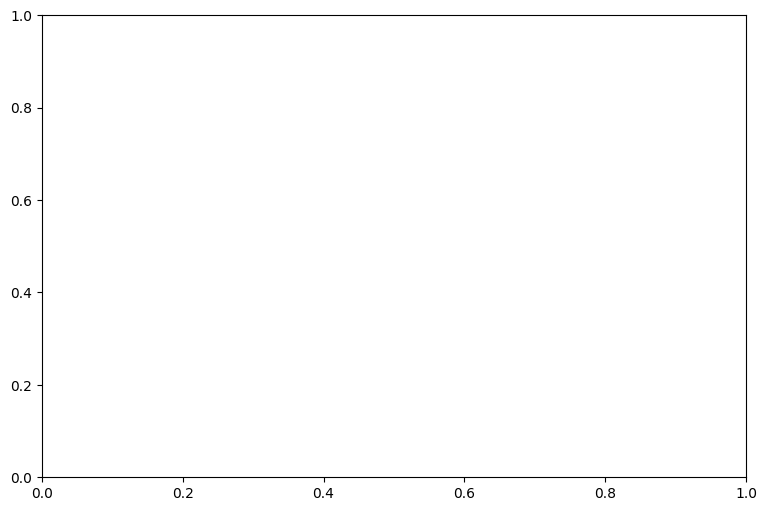

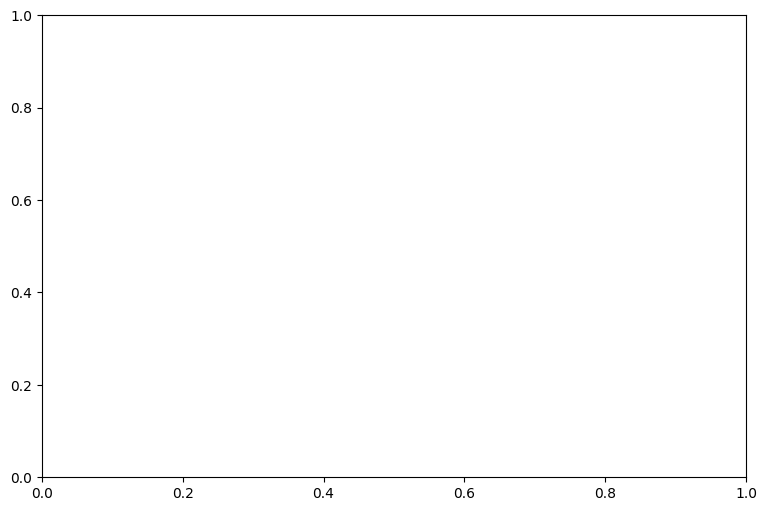

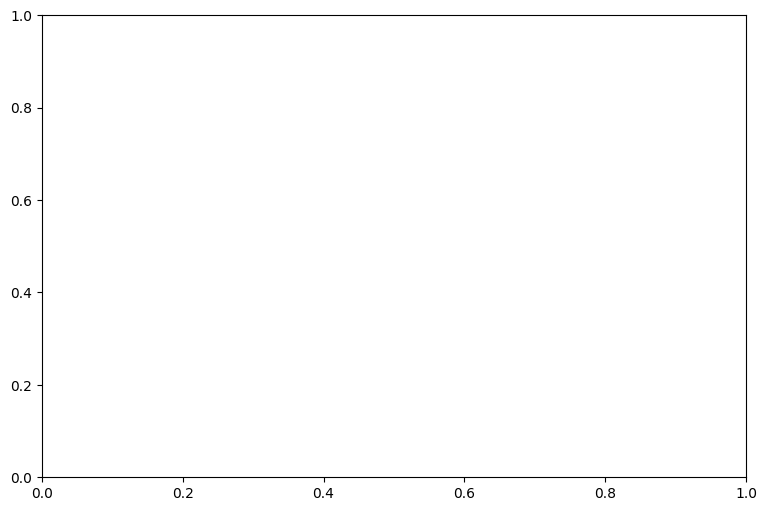

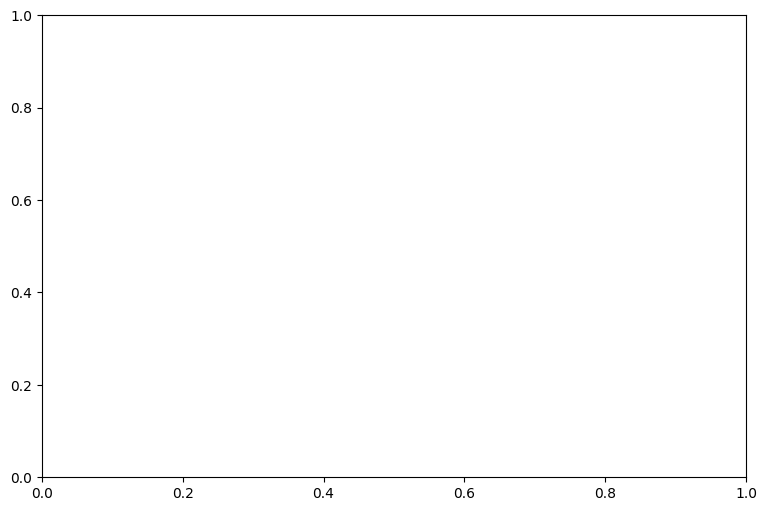

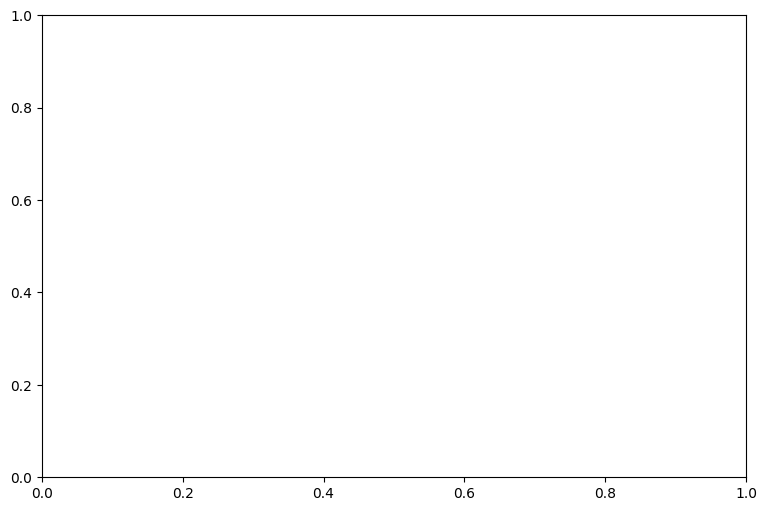

<Figure size 2000x600 with 0 Axes>

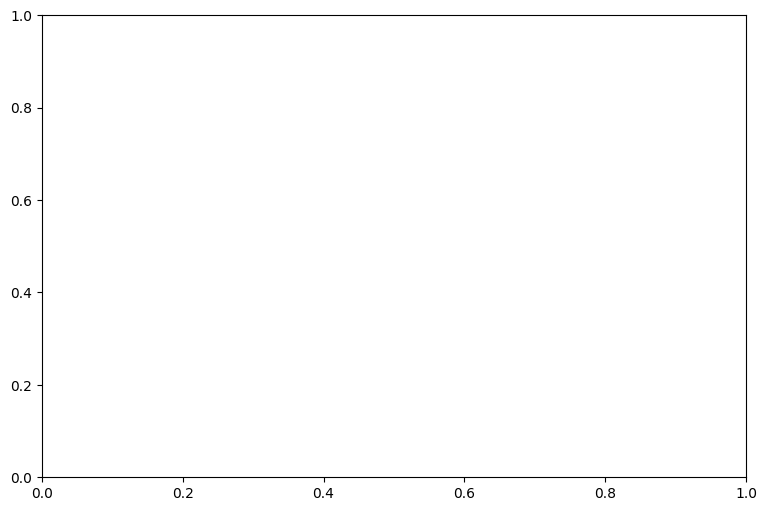

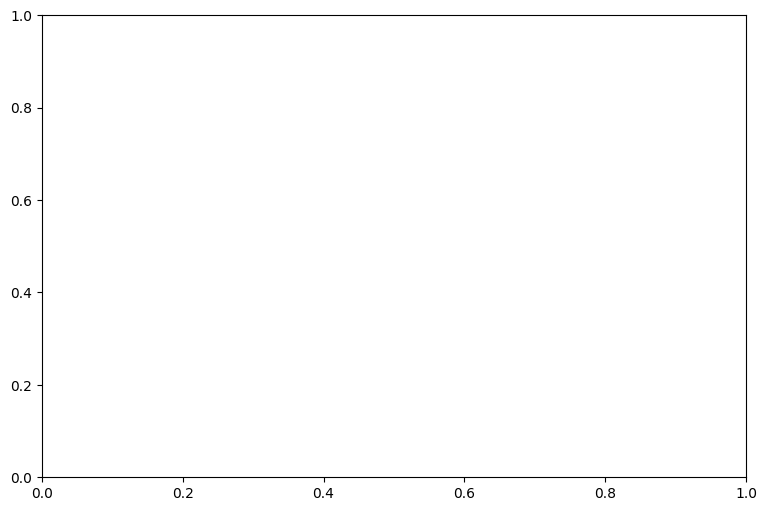

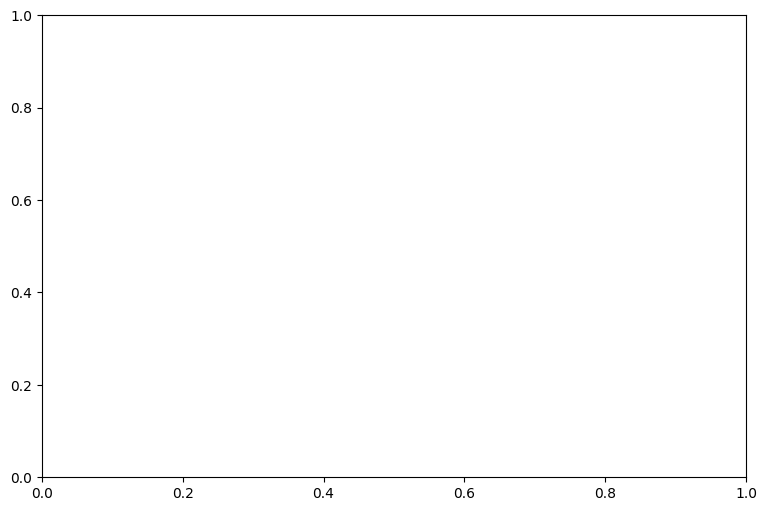

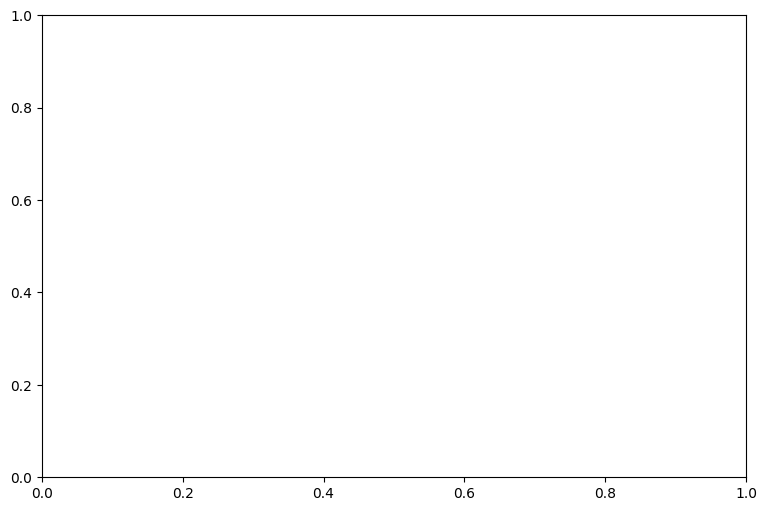

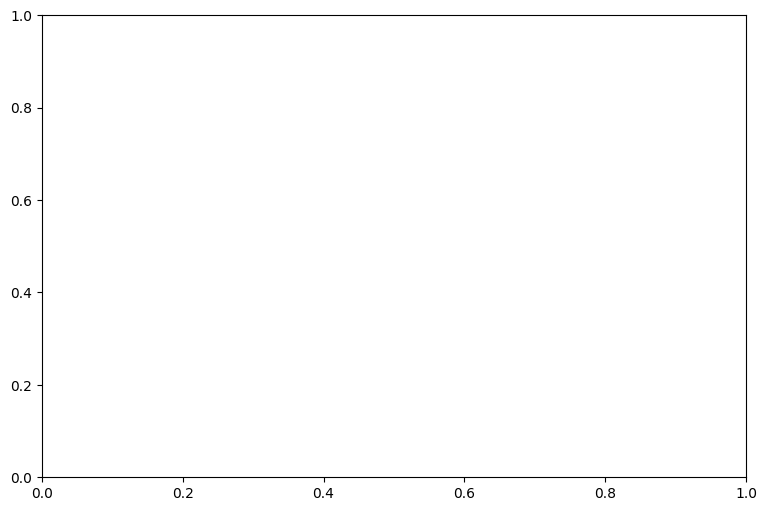

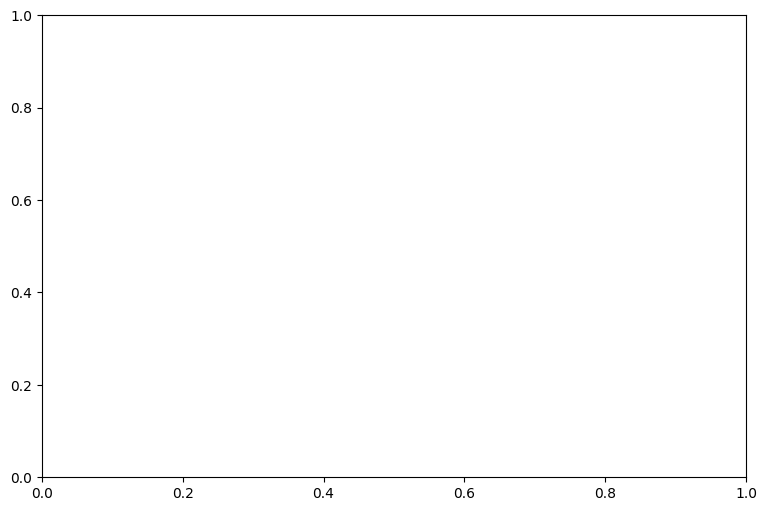

In [9]:

DEVICE = "cuda"

class Args:
    dataset = "xsum"
    dataset_key = "document"
    pct_words_masked = 0.3
    span_length = 2
    n_samples = 400
    n_perturbation_list = "100"
    n_perturbation_rounds = 1
    base_model_name = "KoboldAI/GPT-NeoX-20B-Erebus"#"meta-llama/Llama-2-7b-chat-hf"
    scoring_model_name = ""
    mask_filling_model_name = "t5-3b"
    batch_size = 50
    chunk_size = 20
    n_similarity_samples = 20
    int8 = False
    half = False
    base_half = True
    do_top_k = True
    top_k = 40
    do_top_p = True
    top_p = 0.96
    output_name = ""
    openai_model = None  # Set this if using OpenAI API
    openai_key = None  # Set API key if using OpenAI
    baselines_only = True
    skip_baselines = False
    buffer_size = 1
    mask_top_p = 1.0
    pre_perturb_pct = 0.0
    pre_perturb_span_length = 5
    random_fills = False
    random_fills_tokens = False
    cache_dir = "./cache"

args = Args()  # Now all script references to `args.` will work


API_TOKEN_COUNTER = 0

if args.openai_model is not None:
    import openai
    assert args.openai_key is not None, "Must provide OpenAI API key as --openai_key"
    openai.api_key = args.openai_key

START_DATE = datetime.datetime.now().strftime('%Y-%m-%d')
START_TIME = datetime.datetime.now().strftime('%H-%M-%S-%f')

# define SAVE_FOLDER as the timestamp - base model name - mask filling model name
# create it if it doesn't exist
precision_string = "int8" if args.int8 else ("fp16" if args.half else "fp32")
sampling_string = "top_k" if args.do_top_k else ("top_p" if args.do_top_p else "temp")
output_subfolder = f"{args.output_name}/" if args.output_name else ""
if args.openai_model is None:
    base_model_name = args.base_model_name.replace('/', '_')
else:
    base_model_name = "openai-" + args.openai_model.replace('/', '_')
scoring_model_string = (f"-{args.scoring_model_name}" if args.scoring_model_name else "").replace('/', '_')
SAVE_FOLDER = f"/scratch/network/jl5951/tmp_results/{output_subfolder}{base_model_name}{scoring_model_string}-{args.mask_filling_model_name}-{sampling_string}/{START_DATE}-{START_TIME}-{precision_string}-{args.pct_words_masked}-{args.n_perturbation_rounds}-{args.dataset}-{args.n_samples}"
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)
print(f"Saving results to absolute path: {os.path.abspath(SAVE_FOLDER)}")

# write args to file
with open(os.path.join(SAVE_FOLDER, "args.json"), "w") as f:
    json.dump(args.__dict__, f, indent=4)

mask_filling_model_name = args.mask_filling_model_name
n_samples = args.n_samples
batch_size = args.batch_size
n_perturbation_list = [int(x) for x in args.n_perturbation_list.split(",")]
n_perturbation_rounds = args.n_perturbation_rounds
n_similarity_samples = args.n_similarity_samples

cache_dir = args.cache_dir
os.environ["XDG_CACHE_HOME"] = cache_dir
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
print(f"Using cache dir {cache_dir}")

GPT2_TOKENIZER = transformers.GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)

# generic generative model
base_model, base_tokenizer = load_base_model_and_tokenizer(args.base_model_name)

# mask filling t5 model
if not args.baselines_only and not args.random_fills:
    int8_kwargs = {}
    half_kwargs = {}
    if args.int8:
        int8_kwargs = dict(load_in_8bit=True, device_map='auto', torch_dtype=torch.bfloat16)
    elif args.half:
        half_kwargs = dict(torch_dtype=torch.bfloat16)
    print(f'Loading mask filling model {mask_filling_model_name}...')
    mask_model = transformers.AutoModelForSeq2SeqLM.from_pretrained(mask_filling_model_name, **int8_kwargs, **half_kwargs, cache_dir=cache_dir)
    
    try:
        n_positions = mask_model.config.n_positions
    except AttributeError:
        n_positions = 512
else:
    n_positions = 512
preproc_tokenizer = transformers.AutoTokenizer.from_pretrained('t5-small', model_max_length=512, cache_dir=cache_dir)
mask_tokenizer = transformers.AutoTokenizer.from_pretrained(mask_filling_model_name, padding_side='left', model_max_length=n_positions, cache_dir=cache_dir)
if args.dataset in ['english', 'german']:
    preproc_tokenizer = mask_tokenizer

load_base_model()

print(f'Loading dataset {args.dataset}...')
data = generate_data(args.dataset, args.dataset_key)
if args.random_fills:
    FILL_DICTIONARY = set()
    for texts in data.values():
        for text in texts:
            FILL_DICTIONARY.update(text.split())
    FILL_DICTIONARY = sorted(list(FILL_DICTIONARY))

if args.scoring_model_name:
    print(f'Loading SCORING model {args.scoring_model_name}...')
    del base_model
    del base_tokenizer
    torch.cuda.empty_cache()
    base_model, base_tokenizer = load_base_model_and_tokenizer(args.scoring_model_name)
    load_base_model()  # Load again because we've deleted/replaced the old model

# write the data to a json file in the save folder
with open(os.path.join(SAVE_FOLDER, "raw_data.json"), "w") as f:
    print(f"Writing raw data to {os.path.join(SAVE_FOLDER, 'raw_data.json')}")
    json.dump(data, f)

if not args.skip_baselines:
    baseline_outputs = [run_baseline_threshold_experiment(get_ll, "likelihood", n_samples=n_samples)]
    if args.openai_model is None:
        rank_criterion = lambda text: -get_rank(text, log=False)
        baseline_outputs.append(run_baseline_threshold_experiment(rank_criterion, "rank", n_samples=n_samples))
        logrank_criterion = lambda text: -get_rank(text, log=True)
        baseline_outputs.append(run_baseline_threshold_experiment(logrank_criterion, "log_rank", n_samples=n_samples))
        entropy_criterion = lambda text: get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(entropy_criterion, "entropy", n_samples=n_samples))
        liketropy_criterion = lambda text: get_ll(text)+get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(liketropy_criterion, "liketropy", n_samples=n_samples))
        binocular_criterion = lambda text: get_ll(text)/get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(binocular_criterion, "binocular", n_samples=n_samples))
    
    baseline_outputs.append(eval_supervised(data, model='roberta-base-openai-detector'))
    baseline_outputs.append(eval_supervised(data, model='roberta-large-openai-detector'))

outputs = []

if not args.baselines_only:
    # run perturbation experiments
    for n_perturbations in n_perturbation_list:
        perturbation_results = get_perturbation_results(args.span_length, n_perturbations, n_samples)
        for perturbation_mode in ['d', 'z']:
            output = run_perturbation_experiment(
                perturbation_results, perturbation_mode, span_length=args.span_length, n_perturbations=n_perturbations, n_samples=n_samples)
            outputs.append(output)
            with open(os.path.join(SAVE_FOLDER, f"perturbation_{n_perturbations}_{perturbation_mode}_results.json"), "w") as f:
                json.dump(output, f)

if not args.skip_baselines:
    # write likelihood threshold results to a file
    with open(os.path.join(SAVE_FOLDER, f"likelihood_threshold_results.json"), "w") as f:
        json.dump(baseline_outputs[0], f)

    if args.openai_model is None:
        # write rank threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"rank_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[1], f)

        # write log rank threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"logrank_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[2], f)

        # write entropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"entropy_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[3], f)

        # write liketropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"liketropy_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[4], f)

        # write liketropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"binocular_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[5], f)
    
    
    # write supervised results to a file
    with open(os.path.join(SAVE_FOLDER, f"roberta-base-openai-detector_results.json"), "w") as f:
        json.dump(baseline_outputs[-2], f)
    
    # write supervised results to a file
    with open(os.path.join(SAVE_FOLDER, f"roberta-large-openai-detector_results.json"), "w") as f:
        json.dump(baseline_outputs[-1], f)

    outputs += baseline_outputs

save_roc_curves(outputs)
save_ll_histograms(outputs)
save_llr_histograms(outputs)

# move results folder from tmp_results/ to results/, making sure necessary directories exist
new_folder = SAVE_FOLDER.replace("/scratch/network/jl5951/tmp_results", "/scratch/network/jl5951/results")
if not os.path.exists(os.path.dirname(new_folder)):
    os.makedirs(os.path.dirname(new_folder))
os.rename(SAVE_FOLDER, new_folder)

print(f"Used an *estimated* {API_TOKEN_COUNTER} API tokens (may be inaccurate)")



# Neox squad

Saving results to absolute path: /scratch/network/jl5951/tmp_results/KoboldAI_GPT-NeoX-20B-Erebus-t5-3b-top_k/2025-03-24-02-28-02-551153-fp32-0.3-1-squad-400
Using cache dir ./cache
Loading BASE model KoboldAI/GPT-NeoX-20B-Erebus...


Loading checkpoint shards:   0%|          | 0/23 [00:00<?, ?it/s]

MOVING BASE MODEL TO GPU...DONE (12.38s)
Loading dataset squad...


Token indices sequence length is longer than the specified maximum sequence length for this model (597 > 512). Running this sequence through the model will result in indexing errors


Total number of samples: 312
Average number of words: 282.31410256410254
Generating samples for batch 0 of 6
Generating samples for batch 1 of 6
Generating samples for batch 2 of 6
Generating samples for batch 3 of 6
Generating samples for batch 4 of 6
Generating samples for batch 5 of 6
Writing raw data to /scratch/network/jl5951/tmp_results/KoboldAI_GPT-NeoX-20B-Erebus-t5-3b-top_k/2025-03-24-02-28-02-551153-fp32-0.3-1-squad-400/raw_data.json


Computing likelihood criterion: 100%|██████████| 8/8 [02:56<00:00, 22.12s/it]


likelihood_threshold ROC AUC: 0.7676777777777777, PR AUC: 0.6992693481858556, TP@low FPR: 0.04666666666666667


Computing rank criterion: 100%|██████████| 8/8 [02:57<00:00, 22.19s/it]


rank_threshold ROC AUC: 0.7134666666666667, PR AUC: 0.7541417413645854, TP@low FPR: 0.18


Computing log_rank criterion: 100%|██████████| 8/8 [02:57<00:00, 22.19s/it]


log_rank_threshold ROC AUC: 0.8188333333333333, PR AUC: 0.7554408769604275, TP@low FPR: 0.06333333333333334


Computing entropy criterion: 100%|██████████| 8/8 [02:56<00:00, 22.12s/it]


entropy_threshold ROC AUC: 0.6585833333333333, PR AUC: 0.6347405158450612, TP@low FPR: 0.043333333333333335


Computing liketropy criterion: 100%|██████████| 8/8 [05:53<00:00, 44.23s/it]


liketropy_threshold ROC AUC: 0.9956555555555555, PR AUC: 0.9955535242149132, TP@low FPR: 0.9233333333333333


Computing binocular criterion: 100%|██████████| 8/8 [05:53<00:00, 44.24s/it]


binocular_threshold ROC AUC: 0.9938, PR AUC: 0.9929735250546037, TP@low FPR: 0.8633333333333333
Beginning supervised evaluation with roberta-base-openai-detector...


Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Evaluating fake: 100%|██████████| 6/6 [00:00<00:00, 16.87it/s]


roberta-base-openai-detector ROC AUC: 0.9287888888888889, PR AUC: 0.9377765232972526
Beginning supervised evaluation with roberta-large-openai-detector...


Some weights of the model checkpoint at roberta-large-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Evaluating fake: 100%|██████████| 6/6 [00:01<00:00,  5.78it/s]


roberta-large-openai-detector ROC AUC: 0.945211111111111, PR AUC: 0.9479427962179067
likelihood_threshold roc_auc: 0.768
rank_threshold roc_auc: 0.713
log_rank_threshold roc_auc: 0.819
entropy_threshold roc_auc: 0.659
liketropy_threshold roc_auc: 0.996
binocular_threshold roc_auc: 0.994
roberta-base-openai-detector roc_auc: 0.929
roberta-large-openai-detector roc_auc: 0.945
Used an *estimated* 0 API tokens (may be inaccurate)


<Figure size 1000x700 with 0 Axes>

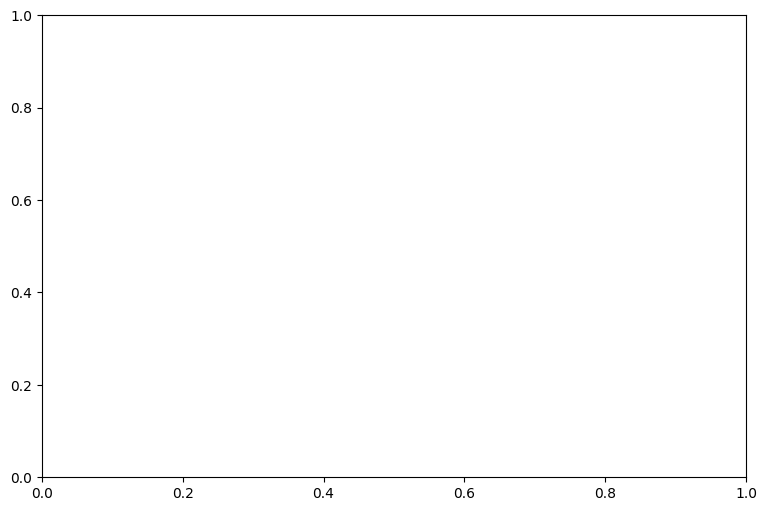

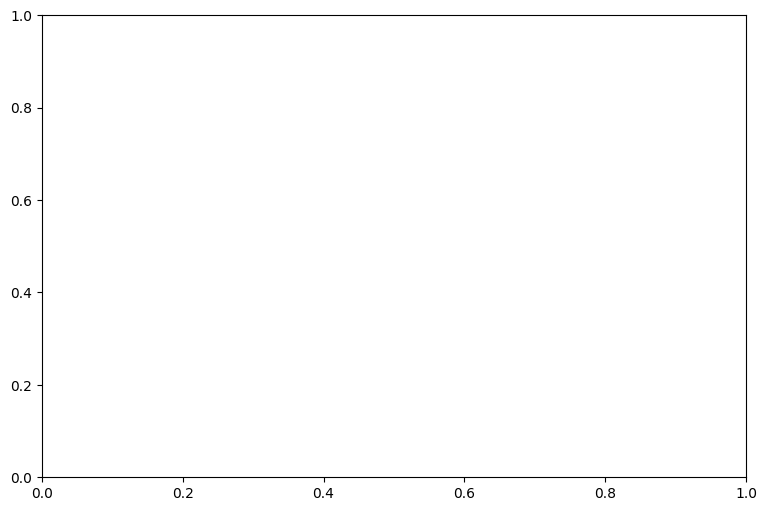

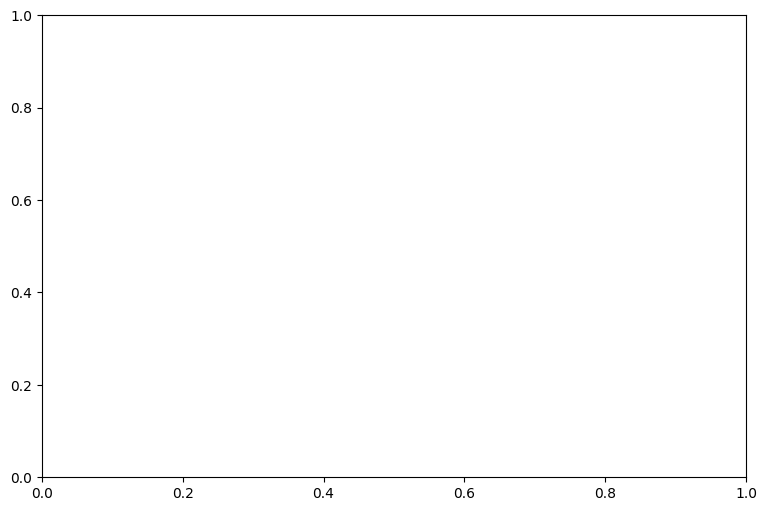

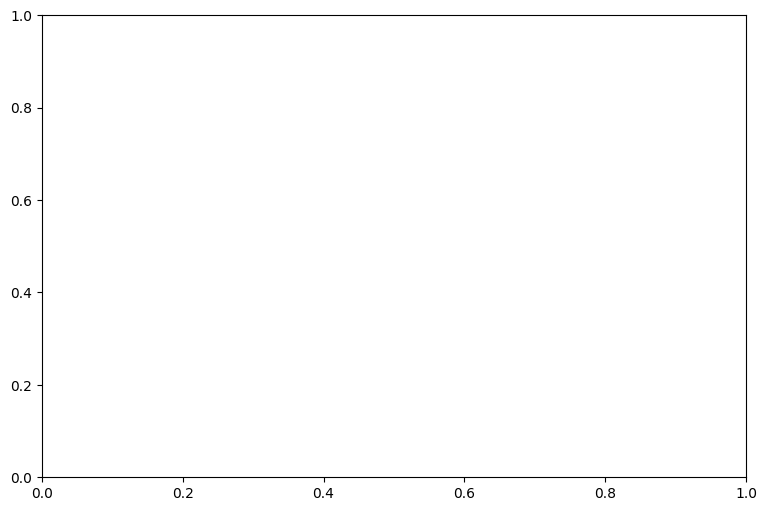

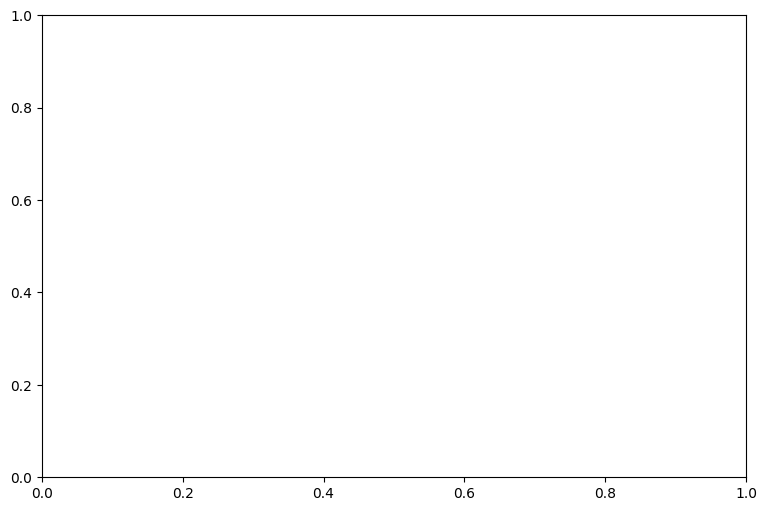

<Figure size 2000x600 with 0 Axes>

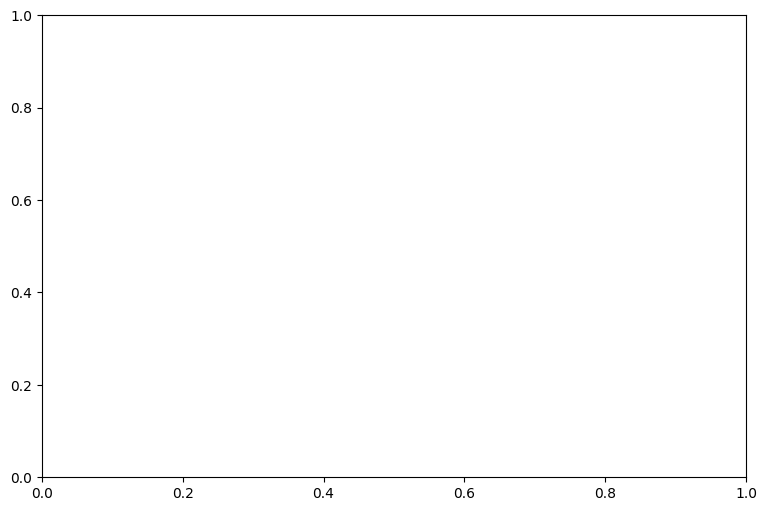

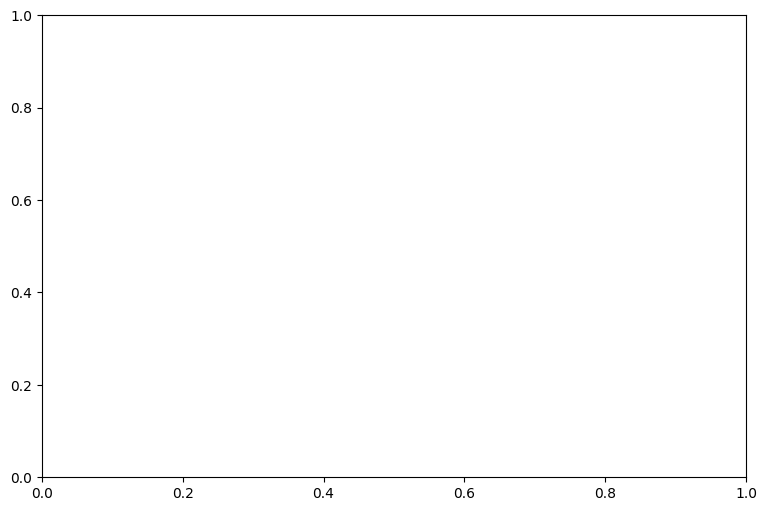

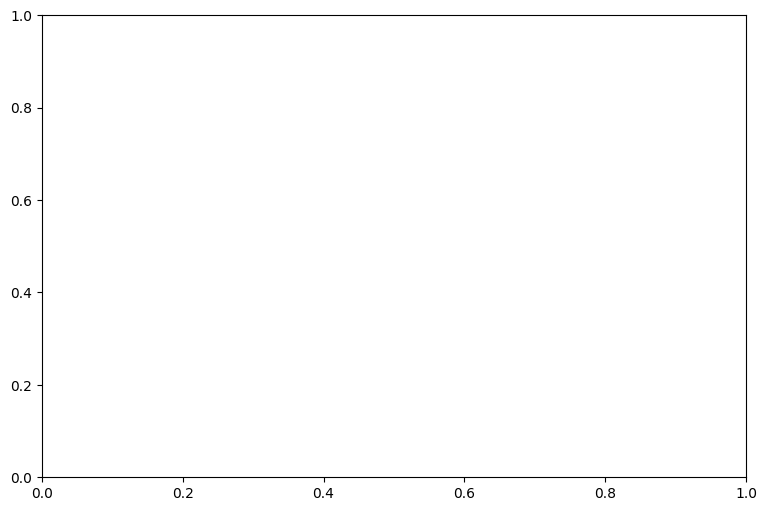

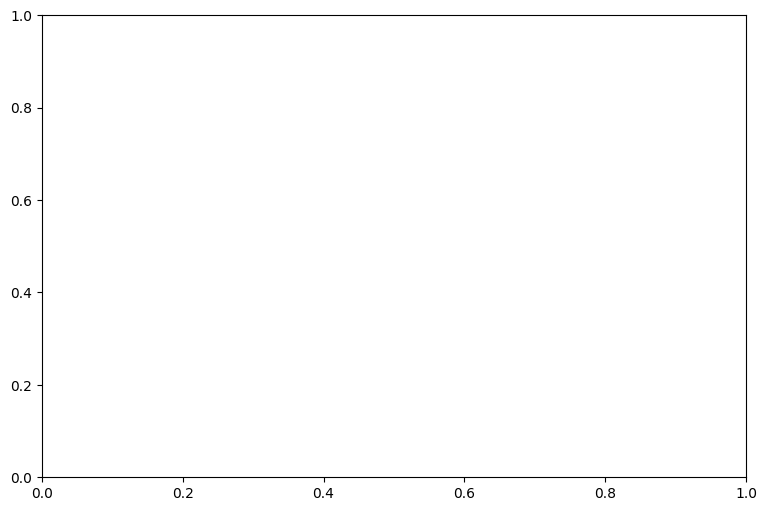

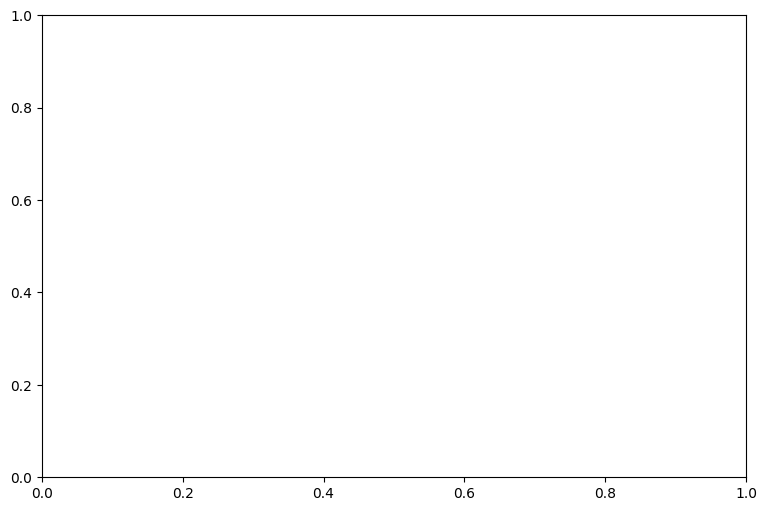

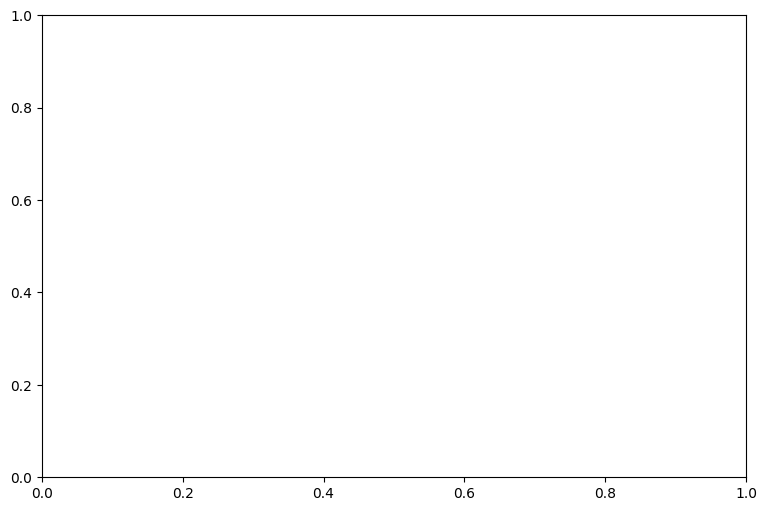

In [10]:

DEVICE = "cuda"

class Args:
    dataset = "squad"
    dataset_key = "context"
    pct_words_masked = 0.3
    span_length = 2
    n_samples = 400
    n_perturbation_list = "100"
    n_perturbation_rounds = 1
    base_model_name = "KoboldAI/GPT-NeoX-20B-Erebus"#"meta-llama/Llama-2-7b-chat-hf"
    scoring_model_name = ""
    mask_filling_model_name = "t5-3b"
    batch_size = 50
    chunk_size = 20
    n_similarity_samples = 20
    int8 = False
    half = False
    base_half = True
    do_top_k = True
    top_k = 40
    do_top_p = True
    top_p = 0.96
    output_name = ""
    openai_model = None  # Set this if using OpenAI API
    openai_key = None  # Set API key if using OpenAI
    baselines_only = True
    skip_baselines = False
    buffer_size = 1
    mask_top_p = 1.0
    pre_perturb_pct = 0.0
    pre_perturb_span_length = 5
    random_fills = False
    random_fills_tokens = False
    cache_dir = "./cache"

args = Args()  # Now all script references to `args.` will work


API_TOKEN_COUNTER = 0

if args.openai_model is not None:
    import openai
    assert args.openai_key is not None, "Must provide OpenAI API key as --openai_key"
    openai.api_key = args.openai_key

START_DATE = datetime.datetime.now().strftime('%Y-%m-%d')
START_TIME = datetime.datetime.now().strftime('%H-%M-%S-%f')

# define SAVE_FOLDER as the timestamp - base model name - mask filling model name
# create it if it doesn't exist
precision_string = "int8" if args.int8 else ("fp16" if args.half else "fp32")
sampling_string = "top_k" if args.do_top_k else ("top_p" if args.do_top_p else "temp")
output_subfolder = f"{args.output_name}/" if args.output_name else ""
if args.openai_model is None:
    base_model_name = args.base_model_name.replace('/', '_')
else:
    base_model_name = "openai-" + args.openai_model.replace('/', '_')
scoring_model_string = (f"-{args.scoring_model_name}" if args.scoring_model_name else "").replace('/', '_')
SAVE_FOLDER = f"/scratch/network/jl5951/tmp_results/{output_subfolder}{base_model_name}{scoring_model_string}-{args.mask_filling_model_name}-{sampling_string}/{START_DATE}-{START_TIME}-{precision_string}-{args.pct_words_masked}-{args.n_perturbation_rounds}-{args.dataset}-{args.n_samples}"
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)
print(f"Saving results to absolute path: {os.path.abspath(SAVE_FOLDER)}")

# write args to file
with open(os.path.join(SAVE_FOLDER, "args.json"), "w") as f:
    json.dump(args.__dict__, f, indent=4)

mask_filling_model_name = args.mask_filling_model_name
n_samples = args.n_samples
batch_size = args.batch_size
n_perturbation_list = [int(x) for x in args.n_perturbation_list.split(",")]
n_perturbation_rounds = args.n_perturbation_rounds
n_similarity_samples = args.n_similarity_samples

cache_dir = args.cache_dir
os.environ["XDG_CACHE_HOME"] = cache_dir
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
print(f"Using cache dir {cache_dir}")

GPT2_TOKENIZER = transformers.GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)

# generic generative model
base_model, base_tokenizer = load_base_model_and_tokenizer(args.base_model_name)

# mask filling t5 model
if not args.baselines_only and not args.random_fills:
    int8_kwargs = {}
    half_kwargs = {}
    if args.int8:
        int8_kwargs = dict(load_in_8bit=True, device_map='auto', torch_dtype=torch.bfloat16)
    elif args.half:
        half_kwargs = dict(torch_dtype=torch.bfloat16)
    print(f'Loading mask filling model {mask_filling_model_name}...')
    mask_model = transformers.AutoModelForSeq2SeqLM.from_pretrained(mask_filling_model_name, **int8_kwargs, **half_kwargs, cache_dir=cache_dir)
    
    try:
        n_positions = mask_model.config.n_positions
    except AttributeError:
        n_positions = 512
else:
    n_positions = 512
preproc_tokenizer = transformers.AutoTokenizer.from_pretrained('t5-small', model_max_length=512, cache_dir=cache_dir)
mask_tokenizer = transformers.AutoTokenizer.from_pretrained(mask_filling_model_name, padding_side='left', model_max_length=n_positions, cache_dir=cache_dir)
if args.dataset in ['english', 'german']:
    preproc_tokenizer = mask_tokenizer

load_base_model()

print(f'Loading dataset {args.dataset}...')
data = generate_data(args.dataset, args.dataset_key)
if args.random_fills:
    FILL_DICTIONARY = set()
    for texts in data.values():
        for text in texts:
            FILL_DICTIONARY.update(text.split())
    FILL_DICTIONARY = sorted(list(FILL_DICTIONARY))

if args.scoring_model_name:
    print(f'Loading SCORING model {args.scoring_model_name}...')
    del base_model
    del base_tokenizer
    torch.cuda.empty_cache()
    base_model, base_tokenizer = load_base_model_and_tokenizer(args.scoring_model_name)
    load_base_model()  # Load again because we've deleted/replaced the old model

# write the data to a json file in the save folder
with open(os.path.join(SAVE_FOLDER, "raw_data.json"), "w") as f:
    print(f"Writing raw data to {os.path.join(SAVE_FOLDER, 'raw_data.json')}")
    json.dump(data, f)

if not args.skip_baselines:
    baseline_outputs = [run_baseline_threshold_experiment(get_ll, "likelihood", n_samples=n_samples)]
    if args.openai_model is None:
        rank_criterion = lambda text: -get_rank(text, log=False)
        baseline_outputs.append(run_baseline_threshold_experiment(rank_criterion, "rank", n_samples=n_samples))
        logrank_criterion = lambda text: -get_rank(text, log=True)
        baseline_outputs.append(run_baseline_threshold_experiment(logrank_criterion, "log_rank", n_samples=n_samples))
        entropy_criterion = lambda text: get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(entropy_criterion, "entropy", n_samples=n_samples))
        liketropy_criterion = lambda text: get_ll(text)+get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(liketropy_criterion, "liketropy", n_samples=n_samples))
        binocular_criterion = lambda text: get_ll(text)/get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(binocular_criterion, "binocular", n_samples=n_samples))
    
    baseline_outputs.append(eval_supervised(data, model='roberta-base-openai-detector'))
    baseline_outputs.append(eval_supervised(data, model='roberta-large-openai-detector'))

outputs = []

if not args.baselines_only:
    # run perturbation experiments
    for n_perturbations in n_perturbation_list:
        perturbation_results = get_perturbation_results(args.span_length, n_perturbations, n_samples)
        for perturbation_mode in ['d', 'z']:
            output = run_perturbation_experiment(
                perturbation_results, perturbation_mode, span_length=args.span_length, n_perturbations=n_perturbations, n_samples=n_samples)
            outputs.append(output)
            with open(os.path.join(SAVE_FOLDER, f"perturbation_{n_perturbations}_{perturbation_mode}_results.json"), "w") as f:
                json.dump(output, f)

if not args.skip_baselines:
    # write likelihood threshold results to a file
    with open(os.path.join(SAVE_FOLDER, f"likelihood_threshold_results.json"), "w") as f:
        json.dump(baseline_outputs[0], f)

    if args.openai_model is None:
        # write rank threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"rank_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[1], f)

        # write log rank threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"logrank_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[2], f)

        # write entropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"entropy_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[3], f)

        # write liketropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"liketropy_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[4], f)

        # write liketropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"binocular_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[5], f)
    
    
    # write supervised results to a file
    with open(os.path.join(SAVE_FOLDER, f"roberta-base-openai-detector_results.json"), "w") as f:
        json.dump(baseline_outputs[-2], f)
    
    # write supervised results to a file
    with open(os.path.join(SAVE_FOLDER, f"roberta-large-openai-detector_results.json"), "w") as f:
        json.dump(baseline_outputs[-1], f)

    outputs += baseline_outputs

save_roc_curves(outputs)
save_ll_histograms(outputs)
save_llr_histograms(outputs)

# move results folder from tmp_results/ to results/, making sure necessary directories exist
new_folder = SAVE_FOLDER.replace("/scratch/network/jl5951/tmp_results", "/scratch/network/jl5951/results")
if not os.path.exists(os.path.dirname(new_folder)):
    os.makedirs(os.path.dirname(new_folder))
os.rename(SAVE_FOLDER, new_folder)

print(f"Used an *estimated* {API_TOKEN_COUNTER} API tokens (may be inaccurate)")



# Neox writing

Saving results to absolute path: /scratch/network/jl5951/tmp_results/KoboldAI_GPT-NeoX-20B-Erebus-t5-3b-top_k/2025-03-24-02-54-28-242370-fp32-0.3-1-writing-400
Using cache dir ./cache
Loading BASE model KoboldAI/GPT-NeoX-20B-Erebus...


Loading checkpoint shards:   0%|          | 0/23 [00:00<?, ?it/s]

MOVING BASE MODEL TO GPU...DONE (14.62s)
Loading dataset writing...


Token indices sequence length is longer than the specified maximum sequence length for this model (706 > 512). Running this sequence through the model will result in indexing errors


Total number of samples: 1011
Average number of words: 309.6142433234421
Generating samples for batch 0 of 8
Generating samples for batch 1 of 8
Generating samples for batch 2 of 8
Generating samples for batch 3 of 8
Generating samples for batch 4 of 8
Generating samples for batch 5 of 8
Generating samples for batch 6 of 8
Generating samples for batch 7 of 8
Writing raw data to /scratch/network/jl5951/tmp_results/KoboldAI_GPT-NeoX-20B-Erebus-t5-3b-top_k/2025-03-24-02-54-28-242370-fp32-0.3-1-writing-400/raw_data.json


Computing likelihood criterion: 100%|██████████| 8/8 [03:52<00:00, 29.10s/it]


likelihood_threshold ROC AUC: 0.96924375, PR AUC: 0.9564062828402475, TP@low FPR: 0.4625


Computing rank criterion: 100%|██████████| 8/8 [03:53<00:00, 29.18s/it]


rank_threshold ROC AUC: 0.7943, PR AUC: 0.8473276894038176, TP@low FPR: 0.3925


Computing log_rank criterion: 100%|██████████| 8/8 [03:53<00:00, 29.18s/it]


log_rank_threshold ROC AUC: 0.9770125000000001, PR AUC: 0.9668266084851924, TP@low FPR: 0.5375


Computing entropy criterion: 100%|██████████| 8/8 [03:52<00:00, 29.09s/it]


entropy_threshold ROC AUC: 0.3560875, PR AUC: 0.3984747560485836, TP@low FPR: 0.0


Computing liketropy criterion: 100%|██████████| 8/8 [07:45<00:00, 58.17s/it]


liketropy_threshold ROC AUC: 0.99941875, PR AUC: 0.9994346399229967, TP@low FPR: 0.985


Computing binocular criterion: 100%|██████████| 8/8 [07:45<00:00, 58.17s/it]
Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


binocular_threshold ROC AUC: 0.999575, PR AUC: 0.9995717397366927, TP@low FPR: 0.985
Beginning supervised evaluation with roberta-base-openai-detector...


Evaluating fake: 100%|██████████| 8/8 [00:00<00:00, 17.17it/s]


roberta-base-openai-detector ROC AUC: 0.9505999999999999, PR AUC: 0.9579397474577402
Beginning supervised evaluation with roberta-large-openai-detector...


Some weights of the model checkpoint at roberta-large-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Evaluating fake: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


roberta-large-openai-detector ROC AUC: 0.9382874999999999, PR AUC: 0.9442889220312694
likelihood_threshold roc_auc: 0.969
rank_threshold roc_auc: 0.794
log_rank_threshold roc_auc: 0.977
entropy_threshold roc_auc: 0.356
liketropy_threshold roc_auc: 0.999
binocular_threshold roc_auc: 1.000
roberta-base-openai-detector roc_auc: 0.951
roberta-large-openai-detector roc_auc: 0.938
Used an *estimated* 0 API tokens (may be inaccurate)


<Figure size 1000x700 with 0 Axes>

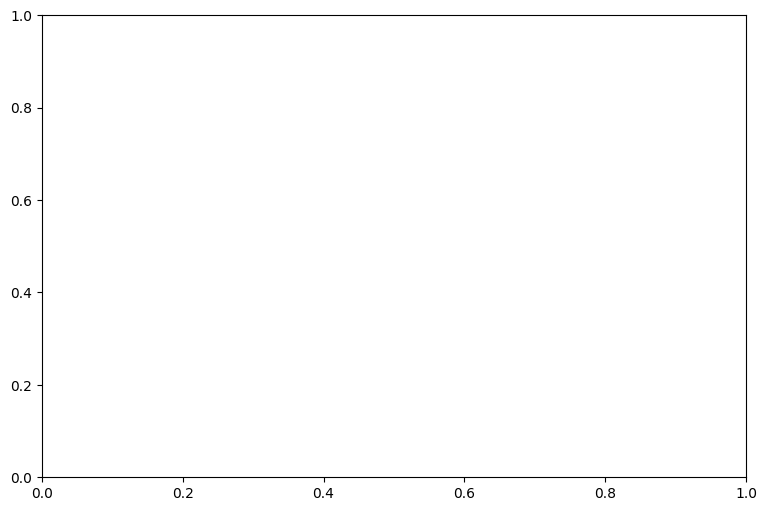

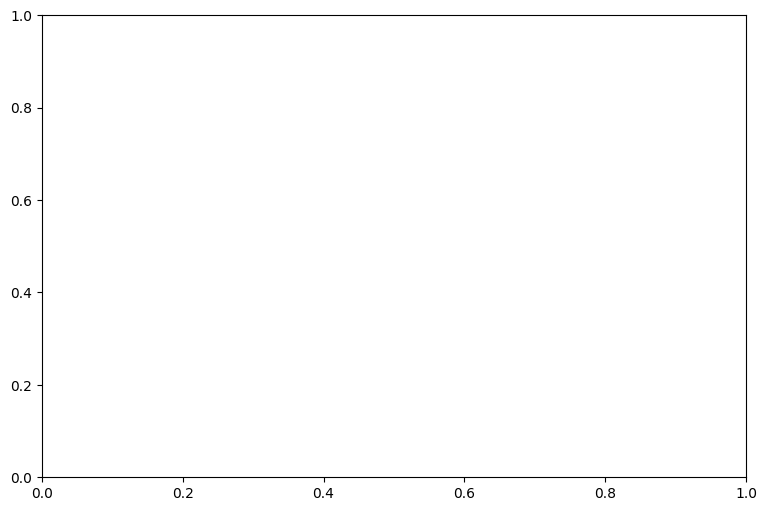

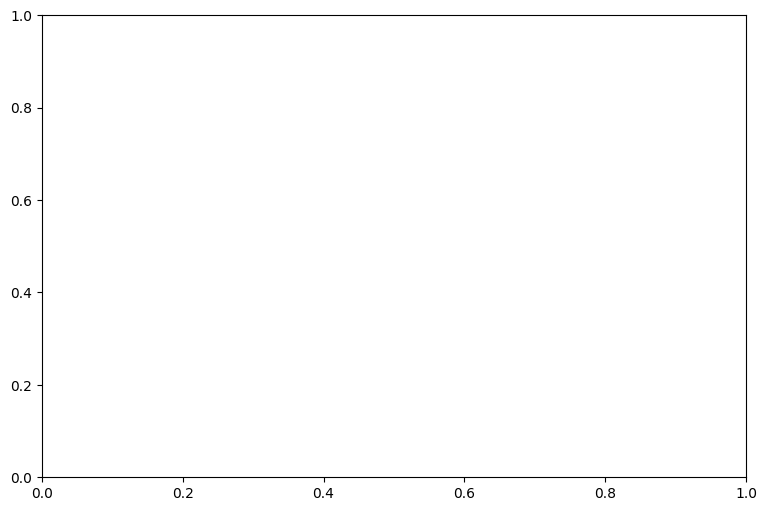

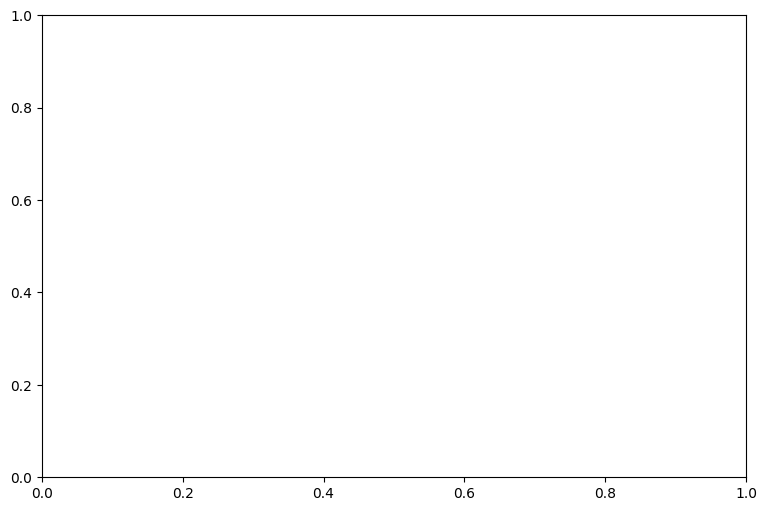

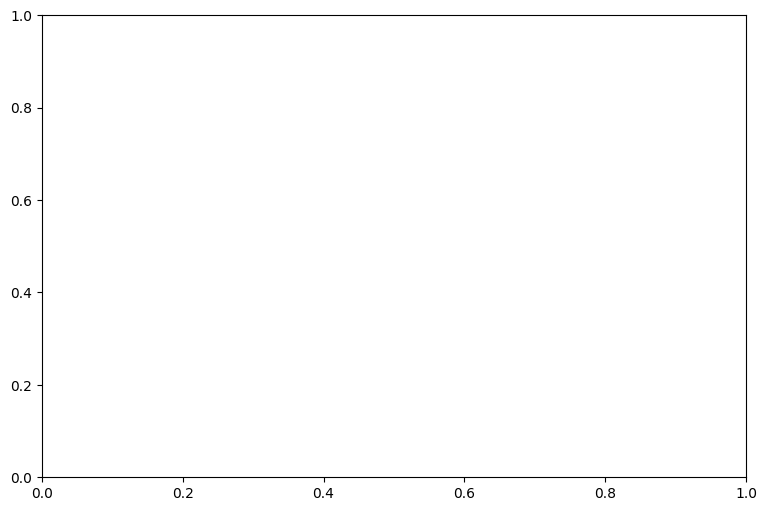

<Figure size 2000x600 with 0 Axes>

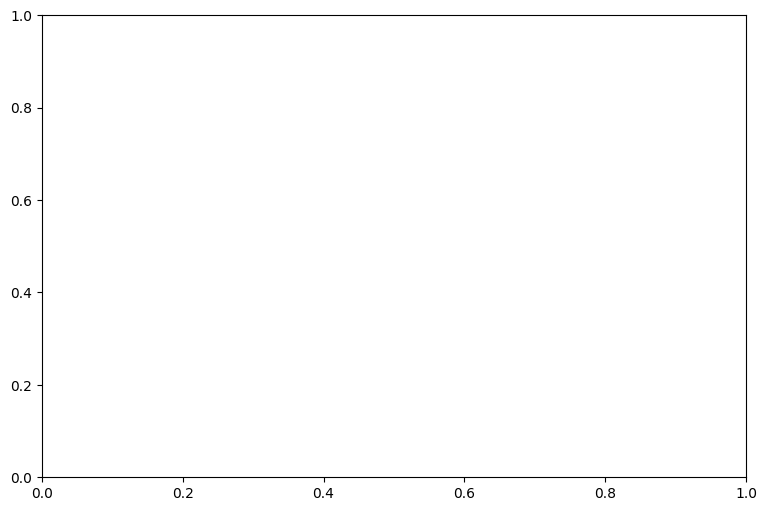

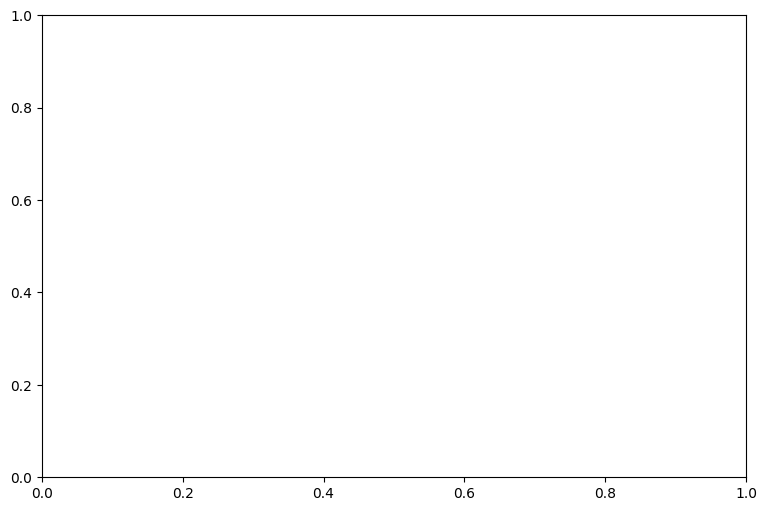

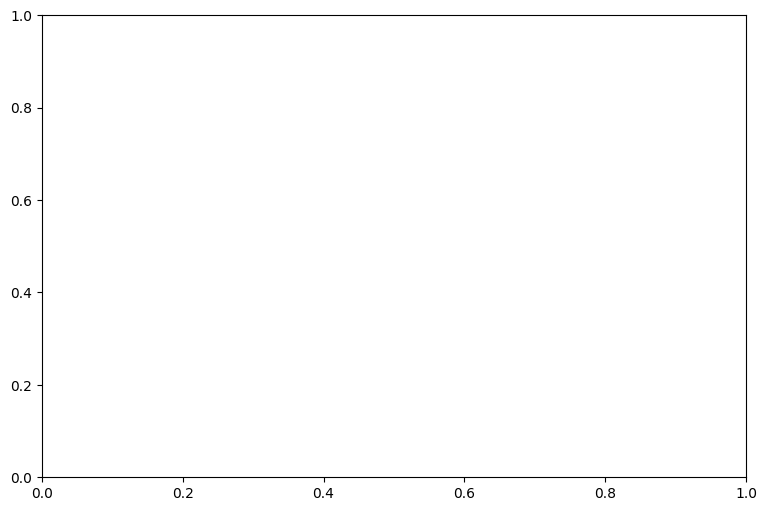

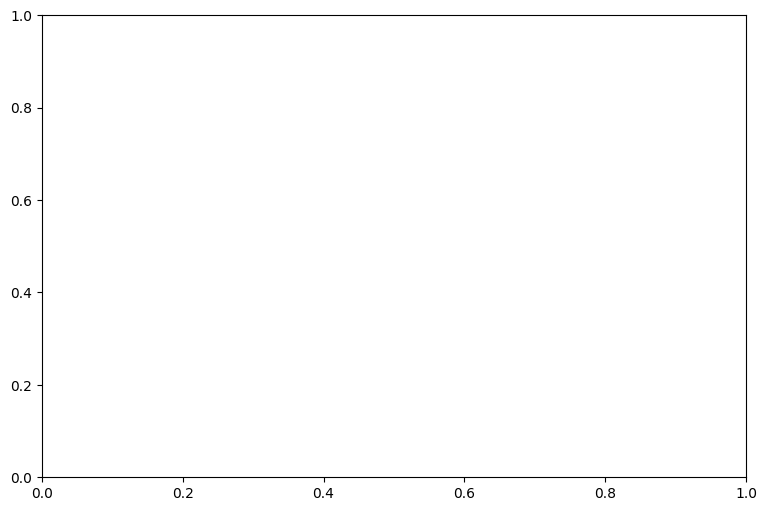

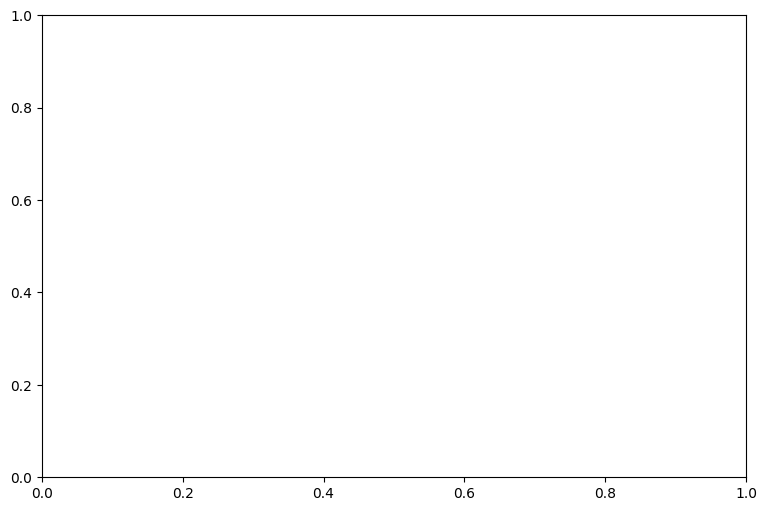

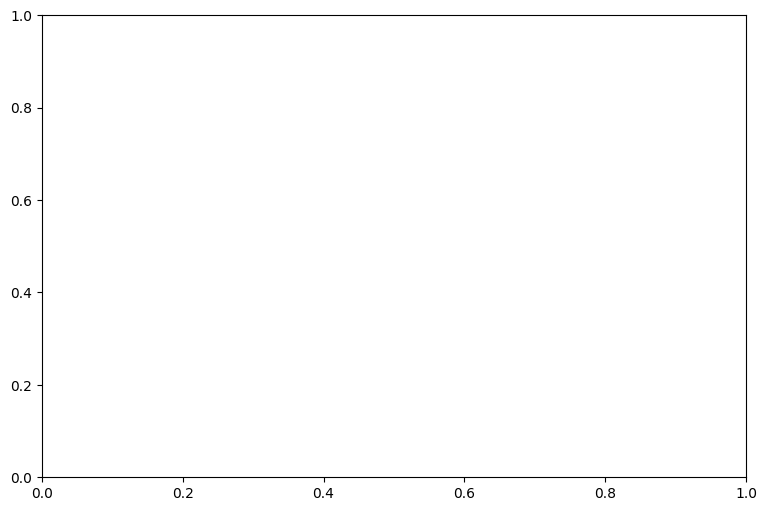

In [11]:

DEVICE = "cuda"

class Args:
    dataset = "writing"
    dataset_key = "story"
    pct_words_masked = 0.3
    span_length = 2
    n_samples = 400
    n_perturbation_list = "100"
    n_perturbation_rounds = 1
    base_model_name = "KoboldAI/GPT-NeoX-20B-Erebus"#"meta-llama/Llama-2-7b-chat-hf"
    scoring_model_name = ""
    mask_filling_model_name = "t5-3b"
    batch_size = 50
    chunk_size = 20
    n_similarity_samples = 20
    int8 = False
    half = False
    base_half = True
    do_top_k = True
    top_k = 40
    do_top_p = True
    top_p = 0.96
    output_name = ""
    openai_model = None  # Set this if using OpenAI API
    openai_key = None  # Set API key if using OpenAI
    baselines_only = True
    skip_baselines = False
    buffer_size = 1
    mask_top_p = 1.0
    pre_perturb_pct = 0.0
    pre_perturb_span_length = 5
    random_fills = False
    random_fills_tokens = False
    cache_dir = "./cache"

args = Args()  # Now all script references to `args.` will work


API_TOKEN_COUNTER = 0

if args.openai_model is not None:
    import openai
    assert args.openai_key is not None, "Must provide OpenAI API key as --openai_key"
    openai.api_key = args.openai_key

START_DATE = datetime.datetime.now().strftime('%Y-%m-%d')
START_TIME = datetime.datetime.now().strftime('%H-%M-%S-%f')

# define SAVE_FOLDER as the timestamp - base model name - mask filling model name
# create it if it doesn't exist
precision_string = "int8" if args.int8 else ("fp16" if args.half else "fp32")
sampling_string = "top_k" if args.do_top_k else ("top_p" if args.do_top_p else "temp")
output_subfolder = f"{args.output_name}/" if args.output_name else ""
if args.openai_model is None:
    base_model_name = args.base_model_name.replace('/', '_')
else:
    base_model_name = "openai-" + args.openai_model.replace('/', '_')
scoring_model_string = (f"-{args.scoring_model_name}" if args.scoring_model_name else "").replace('/', '_')
SAVE_FOLDER = f"/scratch/network/jl5951/tmp_results/{output_subfolder}{base_model_name}{scoring_model_string}-{args.mask_filling_model_name}-{sampling_string}/{START_DATE}-{START_TIME}-{precision_string}-{args.pct_words_masked}-{args.n_perturbation_rounds}-{args.dataset}-{args.n_samples}"
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)
print(f"Saving results to absolute path: {os.path.abspath(SAVE_FOLDER)}")

# write args to file
with open(os.path.join(SAVE_FOLDER, "args.json"), "w") as f:
    json.dump(args.__dict__, f, indent=4)

mask_filling_model_name = args.mask_filling_model_name
n_samples = args.n_samples
batch_size = args.batch_size
n_perturbation_list = [int(x) for x in args.n_perturbation_list.split(",")]
n_perturbation_rounds = args.n_perturbation_rounds
n_similarity_samples = args.n_similarity_samples

cache_dir = args.cache_dir
os.environ["XDG_CACHE_HOME"] = cache_dir
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
print(f"Using cache dir {cache_dir}")

GPT2_TOKENIZER = transformers.GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)

# generic generative model
base_model, base_tokenizer = load_base_model_and_tokenizer(args.base_model_name)

# mask filling t5 model
if not args.baselines_only and not args.random_fills:
    int8_kwargs = {}
    half_kwargs = {}
    if args.int8:
        int8_kwargs = dict(load_in_8bit=True, device_map='auto', torch_dtype=torch.bfloat16)
    elif args.half:
        half_kwargs = dict(torch_dtype=torch.bfloat16)
    print(f'Loading mask filling model {mask_filling_model_name}...')
    mask_model = transformers.AutoModelForSeq2SeqLM.from_pretrained(mask_filling_model_name, **int8_kwargs, **half_kwargs, cache_dir=cache_dir)
    
    try:
        n_positions = mask_model.config.n_positions
    except AttributeError:
        n_positions = 512
else:
    n_positions = 512
preproc_tokenizer = transformers.AutoTokenizer.from_pretrained('t5-small', model_max_length=512, cache_dir=cache_dir)
mask_tokenizer = transformers.AutoTokenizer.from_pretrained(mask_filling_model_name, padding_side='left', model_max_length=n_positions, cache_dir=cache_dir)
if args.dataset in ['english', 'german']:
    preproc_tokenizer = mask_tokenizer

load_base_model()

print(f'Loading dataset {args.dataset}...')
data = generate_data(args.dataset, args.dataset_key)
if args.random_fills:
    FILL_DICTIONARY = set()
    for texts in data.values():
        for text in texts:
            FILL_DICTIONARY.update(text.split())
    FILL_DICTIONARY = sorted(list(FILL_DICTIONARY))

if args.scoring_model_name:
    print(f'Loading SCORING model {args.scoring_model_name}...')
    del base_model
    del base_tokenizer
    torch.cuda.empty_cache()
    base_model, base_tokenizer = load_base_model_and_tokenizer(args.scoring_model_name)
    load_base_model()  # Load again because we've deleted/replaced the old model

# write the data to a json file in the save folder
with open(os.path.join(SAVE_FOLDER, "raw_data.json"), "w") as f:
    print(f"Writing raw data to {os.path.join(SAVE_FOLDER, 'raw_data.json')}")
    json.dump(data, f)

if not args.skip_baselines:
    baseline_outputs = [run_baseline_threshold_experiment(get_ll, "likelihood", n_samples=n_samples)]
    if args.openai_model is None:
        rank_criterion = lambda text: -get_rank(text, log=False)
        baseline_outputs.append(run_baseline_threshold_experiment(rank_criterion, "rank", n_samples=n_samples))
        logrank_criterion = lambda text: -get_rank(text, log=True)
        baseline_outputs.append(run_baseline_threshold_experiment(logrank_criterion, "log_rank", n_samples=n_samples))
        entropy_criterion = lambda text: get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(entropy_criterion, "entropy", n_samples=n_samples))
        liketropy_criterion = lambda text: get_ll(text)+get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(liketropy_criterion, "liketropy", n_samples=n_samples))
        binocular_criterion = lambda text: get_ll(text)/get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(binocular_criterion, "binocular", n_samples=n_samples))
    
    baseline_outputs.append(eval_supervised(data, model='roberta-base-openai-detector'))
    baseline_outputs.append(eval_supervised(data, model='roberta-large-openai-detector'))

outputs = []

if not args.baselines_only:
    # run perturbation experiments
    for n_perturbations in n_perturbation_list:
        perturbation_results = get_perturbation_results(args.span_length, n_perturbations, n_samples)
        for perturbation_mode in ['d', 'z']:
            output = run_perturbation_experiment(
                perturbation_results, perturbation_mode, span_length=args.span_length, n_perturbations=n_perturbations, n_samples=n_samples)
            outputs.append(output)
            with open(os.path.join(SAVE_FOLDER, f"perturbation_{n_perturbations}_{perturbation_mode}_results.json"), "w") as f:
                json.dump(output, f)

if not args.skip_baselines:
    # write likelihood threshold results to a file
    with open(os.path.join(SAVE_FOLDER, f"likelihood_threshold_results.json"), "w") as f:
        json.dump(baseline_outputs[0], f)

    if args.openai_model is None:
        # write rank threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"rank_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[1], f)

        # write log rank threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"logrank_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[2], f)

        # write entropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"entropy_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[3], f)

        # write liketropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"liketropy_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[4], f)

        # write liketropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"binocular_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[5], f)
    
    
    # write supervised results to a file
    with open(os.path.join(SAVE_FOLDER, f"roberta-base-openai-detector_results.json"), "w") as f:
        json.dump(baseline_outputs[-2], f)
    
    # write supervised results to a file
    with open(os.path.join(SAVE_FOLDER, f"roberta-large-openai-detector_results.json"), "w") as f:
        json.dump(baseline_outputs[-1], f)

    outputs += baseline_outputs

save_roc_curves(outputs)
save_ll_histograms(outputs)
save_llr_histograms(outputs)

# move results folder from tmp_results/ to results/, making sure necessary directories exist
new_folder = SAVE_FOLDER.replace("/scratch/network/jl5951/tmp_results", "/scratch/network/jl5951/results")
if not os.path.exists(os.path.dirname(new_folder)):
    os.makedirs(os.path.dirname(new_folder))
os.rename(SAVE_FOLDER, new_folder)

print(f"Used an *estimated* {API_TOKEN_COUNTER} API tokens (may be inaccurate)")



# Qwen Xsum

Saving results to absolute path: /scratch/network/jl5951/tmp_results/Qwen_QwQ-32B-t5-3b-top_k/2025-03-24-03-36-46-558852-fp32-0.3-1-xsum-400
Using cache dir ./cache
Loading BASE model Qwen/QwQ-32B...


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

model-00006-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00001-of-00014.safetensors:   0%|          | 0.00/4.89G [00:00<?, ?B/s]

model-00005-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00002-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00004-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00003-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00008-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00007-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00013-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00012-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00009-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00010-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00011-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00014-of-00014.safetensors:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `eager`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/8.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

MOVING BASE MODEL TO GPU...DONE (30.49s)
Loading dataset xsum...


Token indices sequence length is longer than the specified maximum sequence length for this model (853 > 512). Running this sequence through the model will result in indexing errors


Total number of samples: 1829
Average number of words: 306.9710224166211
Generating samples for batch 0 of 8
Generating samples for batch 1 of 8
Generating samples for batch 2 of 8
Generating samples for batch 3 of 8
Generating samples for batch 4 of 8
Generating samples for batch 5 of 8
Generating samples for batch 6 of 8
Generating samples for batch 7 of 8
Writing raw data to /scratch/network/jl5951/tmp_results/Qwen_QwQ-32B-t5-3b-top_k/2025-03-24-03-36-46-558852-fp32-0.3-1-xsum-400/raw_data.json


Computing likelihood criterion: 100%|██████████| 8/8 [04:41<00:00, 35.15s/it]


likelihood_threshold ROC AUC: 0.99695625, PR AUC: 0.9933619146829299, TP@low FPR: 0.99


Computing rank criterion: 100%|██████████| 8/8 [04:43<00:00, 35.41s/it]


rank_threshold ROC AUC: 0.685675, PR AUC: 0.7328991241724107, TP@low FPR: 0.2


Computing log_rank criterion: 100%|██████████| 8/8 [04:43<00:00, 35.42s/it]


log_rank_threshold ROC AUC: 0.9979375, PR AUC: 0.9966005646240753, TP@low FPR: 0.995


Computing entropy criterion: 100%|██████████| 8/8 [04:41<00:00, 35.19s/it]


entropy_threshold ROC AUC: 0.41025625, PR AUC: 0.4740806487662256, TP@low FPR: 0.0125


Computing liketropy criterion: 100%|██████████| 8/8 [09:23<00:00, 70.39s/it]


liketropy_threshold ROC AUC: 0.99994375, PR AUC: 0.9999438192815518, TP@low FPR: 1.0


Computing binocular criterion: 100%|██████████| 8/8 [09:23<00:00, 70.39s/it]
Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


binocular_threshold ROC AUC: 0.99944375, PR AUC: 0.9994662035266838, TP@low FPR: 0.9875
Beginning supervised evaluation with roberta-base-openai-detector...


Evaluating fake: 100%|██████████| 8/8 [00:00<00:00, 16.34it/s]
Some weights of the model checkpoint at roberta-large-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


roberta-base-openai-detector ROC AUC: 0.91174375, PR AUC: 0.9216356198346618
Beginning supervised evaluation with roberta-large-openai-detector...


Evaluating fake: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]


roberta-large-openai-detector ROC AUC: 0.908825, PR AUC: 0.9212841023758165
likelihood_threshold roc_auc: 0.997
rank_threshold roc_auc: 0.686
log_rank_threshold roc_auc: 0.998
entropy_threshold roc_auc: 0.410
liketropy_threshold roc_auc: 1.000
binocular_threshold roc_auc: 0.999
roberta-base-openai-detector roc_auc: 0.912
roberta-large-openai-detector roc_auc: 0.909
Used an *estimated* 0 API tokens (may be inaccurate)


<Figure size 1000x700 with 0 Axes>

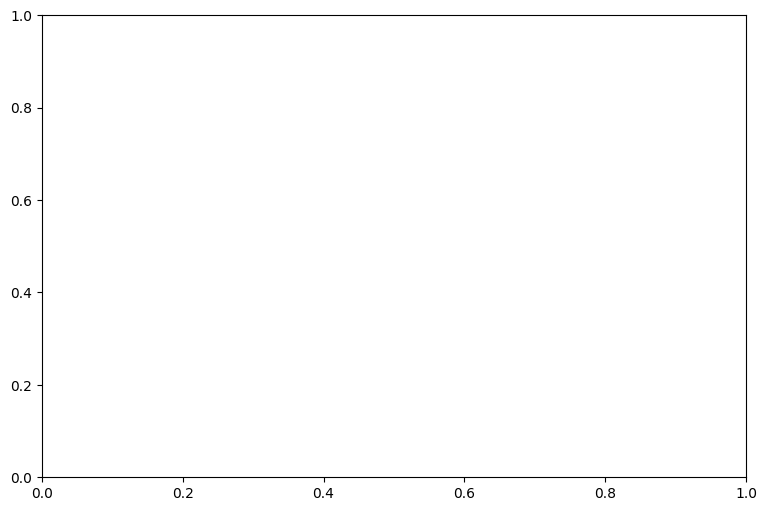

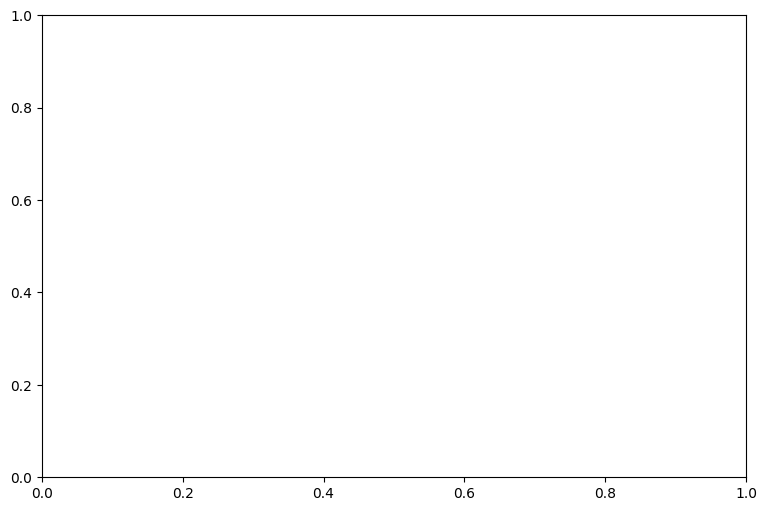

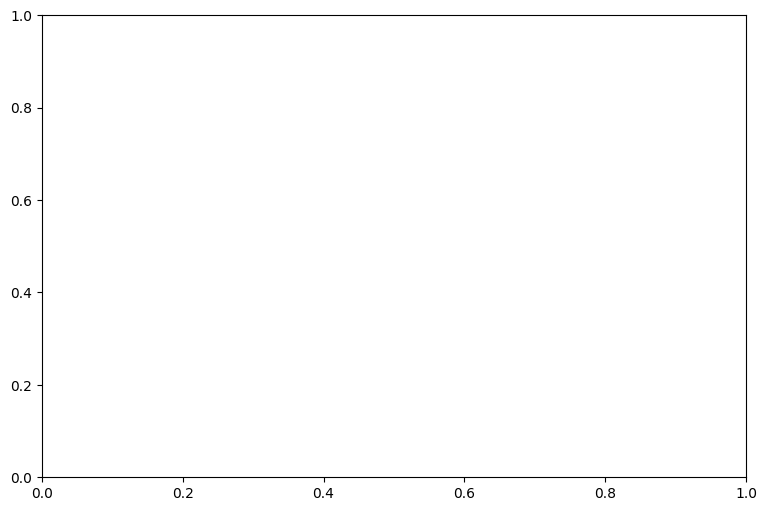

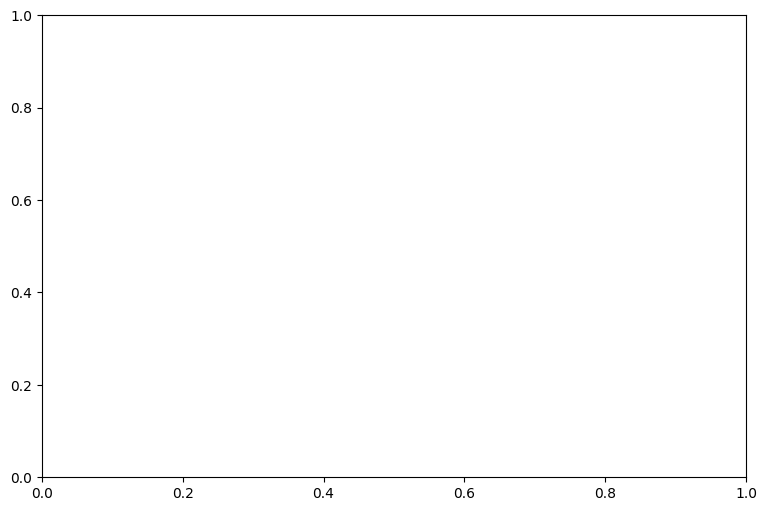

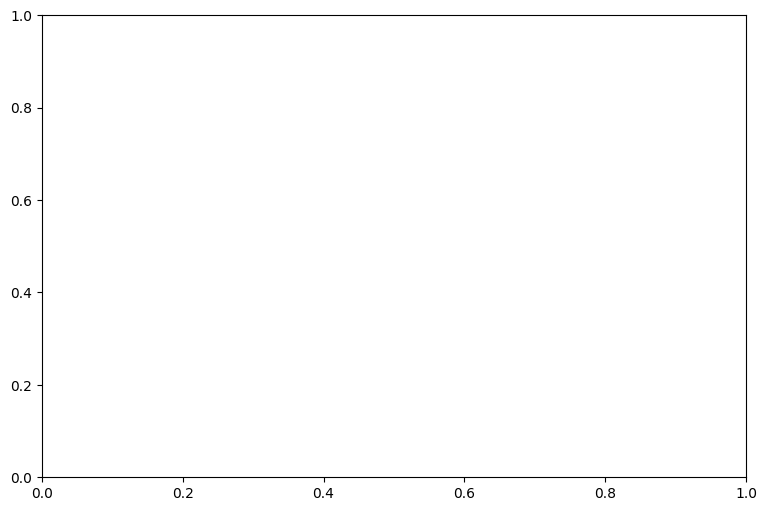

<Figure size 2000x600 with 0 Axes>

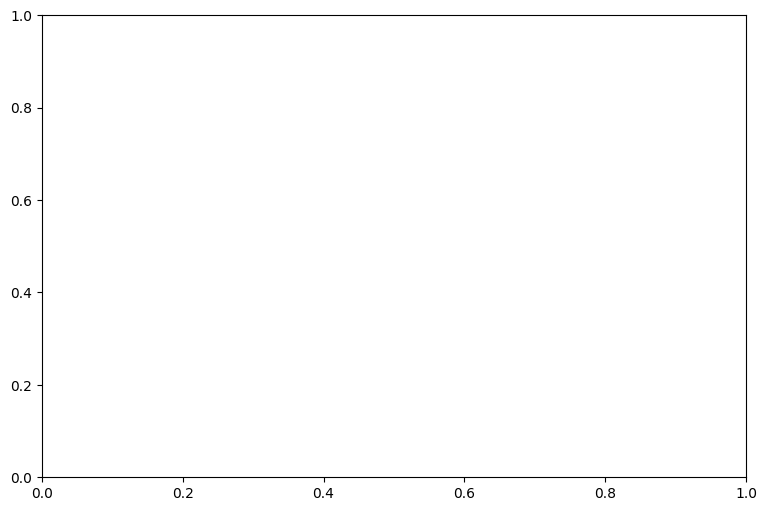

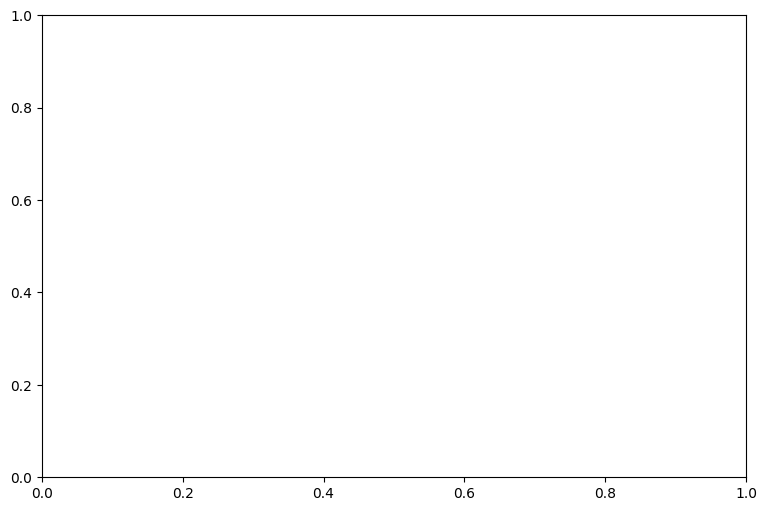

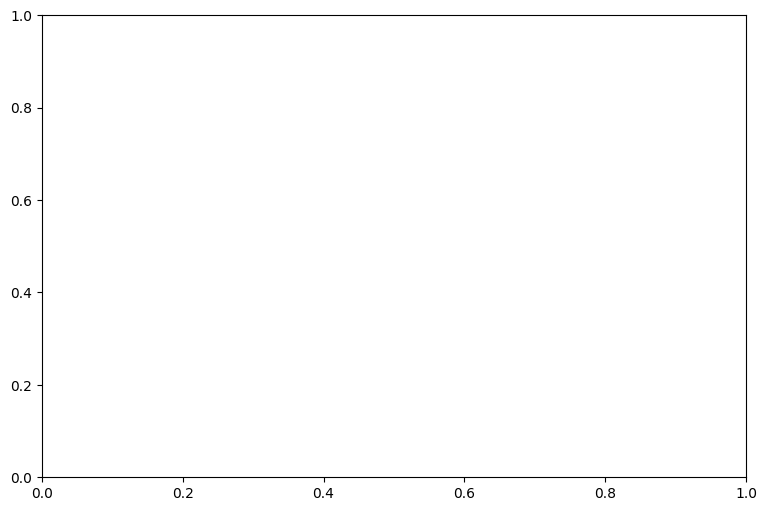

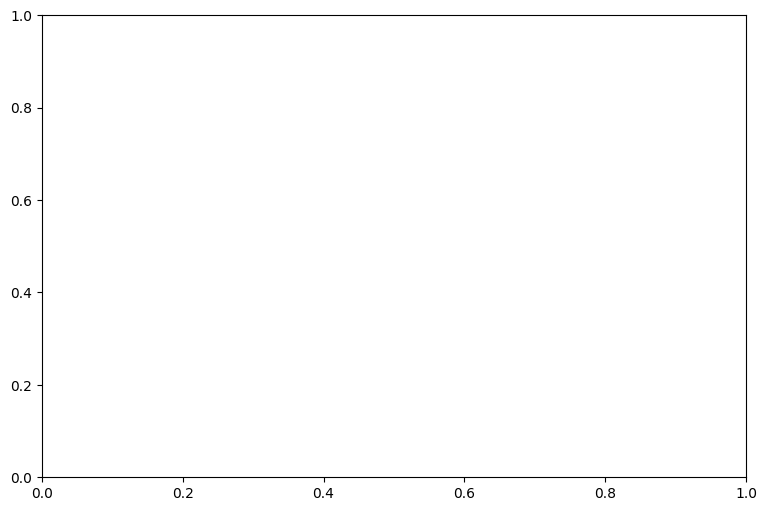

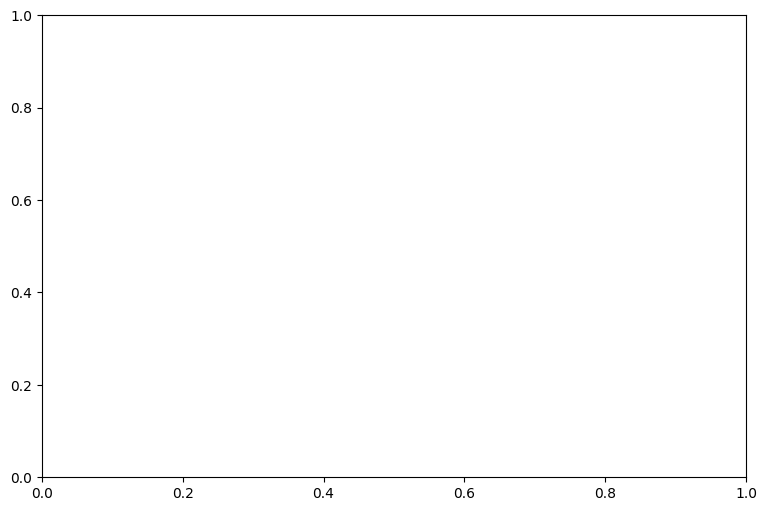

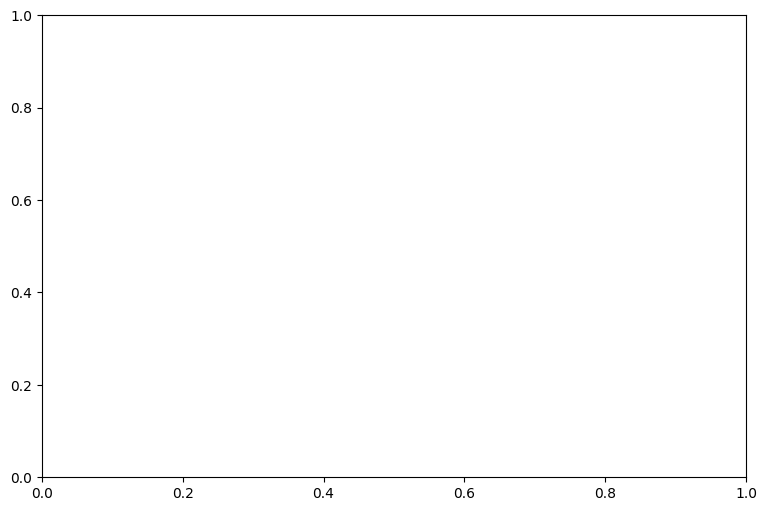

In [4]:
DEVICE = "cuda"

class Args:
    dataset = "xsum"
    dataset_key = "document"
    pct_words_masked = 0.3
    span_length = 2
    n_samples = 400
    n_perturbation_list = "100"
    n_perturbation_rounds = 1
    base_model_name = "Qwen/QwQ-32B"#"meta-llama/Llama-2-7b-chat-hf"
    scoring_model_name = ""
    mask_filling_model_name = "t5-3b"
    batch_size = 50
    chunk_size = 20
    n_similarity_samples = 20
    int8 = False
    half = False
    base_half = True
    do_top_k = True
    top_k = 40
    do_top_p = True
    top_p = 0.96
    output_name = ""
    openai_model = None  # Set this if using OpenAI API
    openai_key = None  # Set API key if using OpenAI
    baselines_only = True
    skip_baselines = False
    buffer_size = 1
    mask_top_p = 1.0
    pre_perturb_pct = 0.0
    pre_perturb_span_length = 5
    random_fills = False
    random_fills_tokens = False
    cache_dir = "./cache"


args = Args()  # Now all script references to `args.` will work


API_TOKEN_COUNTER = 0

if args.openai_model is not None:
    import openai
    assert args.openai_key is not None, "Must provide OpenAI API key as --openai_key"
    openai.api_key = args.openai_key

START_DATE = datetime.datetime.now().strftime('%Y-%m-%d')
START_TIME = datetime.datetime.now().strftime('%H-%M-%S-%f')

# define SAVE_FOLDER as the timestamp - base model name - mask filling model name
# create it if it doesn't exist
precision_string = "int8" if args.int8 else ("fp16" if args.half else "fp32")
sampling_string = "top_k" if args.do_top_k else ("top_p" if args.do_top_p else "temp")
output_subfolder = f"{args.output_name}/" if args.output_name else ""
if args.openai_model is None:
    base_model_name = args.base_model_name.replace('/', '_')
else:
    base_model_name = "openai-" + args.openai_model.replace('/', '_')
scoring_model_string = (f"-{args.scoring_model_name}" if args.scoring_model_name else "").replace('/', '_')
SAVE_FOLDER = f"/scratch/network/jl5951/tmp_results/{output_subfolder}{base_model_name}{scoring_model_string}-{args.mask_filling_model_name}-{sampling_string}/{START_DATE}-{START_TIME}-{precision_string}-{args.pct_words_masked}-{args.n_perturbation_rounds}-{args.dataset}-{args.n_samples}"
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)
print(f"Saving results to absolute path: {os.path.abspath(SAVE_FOLDER)}")

# write args to file
with open(os.path.join(SAVE_FOLDER, "args.json"), "w") as f:
    json.dump(args.__dict__, f, indent=4)

mask_filling_model_name = args.mask_filling_model_name
n_samples = args.n_samples
batch_size = args.batch_size
n_perturbation_list = [int(x) for x in args.n_perturbation_list.split(",")]
n_perturbation_rounds = args.n_perturbation_rounds
n_similarity_samples = args.n_similarity_samples

cache_dir = args.cache_dir
os.environ["XDG_CACHE_HOME"] = cache_dir
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
print(f"Using cache dir {cache_dir}")

GPT2_TOKENIZER = transformers.GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)

# generic generative model
base_model, base_tokenizer = load_base_model_and_tokenizer(args.base_model_name)

# mask filling t5 model
if not args.baselines_only and not args.random_fills:
    int8_kwargs = {}
    half_kwargs = {}
    if args.int8:
        int8_kwargs = dict(load_in_8bit=True, device_map='auto', torch_dtype=torch.bfloat16)
    elif args.half:
        half_kwargs = dict(torch_dtype=torch.bfloat16)
    print(f'Loading mask filling model {mask_filling_model_name}...')
    mask_model = transformers.AutoModelForSeq2SeqLM.from_pretrained(mask_filling_model_name, **int8_kwargs, **half_kwargs, cache_dir=cache_dir)
    
    try:
        n_positions = mask_model.config.n_positions
    except AttributeError:
        n_positions = 512
else:
    n_positions = 512
preproc_tokenizer = transformers.AutoTokenizer.from_pretrained('t5-small', model_max_length=512, cache_dir=cache_dir)
mask_tokenizer = transformers.AutoTokenizer.from_pretrained(mask_filling_model_name, padding_side='left', model_max_length=n_positions, cache_dir=cache_dir)
if args.dataset in ['english', 'german']:
    preproc_tokenizer = mask_tokenizer

load_base_model()

print(f'Loading dataset {args.dataset}...')
data = generate_data(args.dataset, args.dataset_key)
if args.random_fills:
    FILL_DICTIONARY = set()
    for texts in data.values():
        for text in texts:
            FILL_DICTIONARY.update(text.split())
    FILL_DICTIONARY = sorted(list(FILL_DICTIONARY))

if args.scoring_model_name:
    print(f'Loading SCORING model {args.scoring_model_name}...')
    del base_model
    del base_tokenizer
    torch.cuda.empty_cache()
    base_model, base_tokenizer = load_base_model_and_tokenizer(args.scoring_model_name)
    load_base_model()  # Load again because we've deleted/replaced the old model

# write the data to a json file in the save folder
with open(os.path.join(SAVE_FOLDER, "raw_data.json"), "w") as f:
    print(f"Writing raw data to {os.path.join(SAVE_FOLDER, 'raw_data.json')}")
    json.dump(data, f)

if not args.skip_baselines:
    baseline_outputs = [run_baseline_threshold_experiment(get_ll, "likelihood", n_samples=n_samples)]
    if args.openai_model is None:
        rank_criterion = lambda text: -get_rank(text, log=False)
        baseline_outputs.append(run_baseline_threshold_experiment(rank_criterion, "rank", n_samples=n_samples))
        logrank_criterion = lambda text: -get_rank(text, log=True)
        baseline_outputs.append(run_baseline_threshold_experiment(logrank_criterion, "log_rank", n_samples=n_samples))
        entropy_criterion = lambda text: get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(entropy_criterion, "entropy", n_samples=n_samples))
        liketropy_criterion = lambda text: get_ll(text)+get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(liketropy_criterion, "liketropy", n_samples=n_samples))
        binocular_criterion = lambda text: get_ll(text)/get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(binocular_criterion, "binocular", n_samples=n_samples))
    
    baseline_outputs.append(eval_supervised(data, model='roberta-base-openai-detector'))
    baseline_outputs.append(eval_supervised(data, model='roberta-large-openai-detector'))

outputs = []

if not args.baselines_only:
    # run perturbation experiments
    for n_perturbations in n_perturbation_list:
        perturbation_results = get_perturbation_results(args.span_length, n_perturbations, n_samples)
        for perturbation_mode in ['d', 'z']:
            output = run_perturbation_experiment(
                perturbation_results, perturbation_mode, span_length=args.span_length, n_perturbations=n_perturbations, n_samples=n_samples)
            outputs.append(output)
            with open(os.path.join(SAVE_FOLDER, f"perturbation_{n_perturbations}_{perturbation_mode}_results.json"), "w") as f:
                json.dump(output, f)

if not args.skip_baselines:
    # write likelihood threshold results to a file
    with open(os.path.join(SAVE_FOLDER, f"likelihood_threshold_results.json"), "w") as f:
        json.dump(baseline_outputs[0], f)

    if args.openai_model is None:
        # write rank threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"rank_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[1], f)

        # write log rank threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"logrank_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[2], f)

        # write entropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"entropy_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[3], f)

        # write liketropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"liketropy_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[4], f)

        # write liketropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"binocular_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[5], f)
    
    
    # write supervised results to a file
    with open(os.path.join(SAVE_FOLDER, f"roberta-base-openai-detector_results.json"), "w") as f:
        json.dump(baseline_outputs[-2], f)
    
    # write supervised results to a file
    with open(os.path.join(SAVE_FOLDER, f"roberta-large-openai-detector_results.json"), "w") as f:
        json.dump(baseline_outputs[-1], f)

    outputs += baseline_outputs

save_roc_curves(outputs)
save_ll_histograms(outputs)
save_llr_histograms(outputs)

# move results folder from tmp_results/ to results/, making sure necessary directories exist
new_folder = SAVE_FOLDER.replace("/scratch/network/jl5951/tmp_results", "/scratch/network/jl5951/results")
if not os.path.exists(os.path.dirname(new_folder)):
    os.makedirs(os.path.dirname(new_folder))
os.rename(SAVE_FOLDER, new_folder)

print(f"Used an *estimated* {API_TOKEN_COUNTER} API tokens (may be inaccurate)")



# qwen squad

Saving results to absolute path: /scratch/network/jl5951/tmp_results/Qwen_QwQ-32B-t5-3b-top_k/2025-03-24-05-10-47-850088-fp32-0.3-1-squad-400
Using cache dir ./cache
Loading BASE model Qwen/QwQ-32B...


Sliding Window Attention is enabled but not implemented for `eager`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

MOVING BASE MODEL TO GPU...DONE (33.34s)
Loading dataset squad...


Token indices sequence length is longer than the specified maximum sequence length for this model (597 > 512). Running this sequence through the model will result in indexing errors


Total number of samples: 312
Average number of words: 282.31410256410254
Generating samples for batch 0 of 6
Generating samples for batch 1 of 6
Generating samples for batch 2 of 6
Generating samples for batch 3 of 6
Generating samples for batch 4 of 6
Generating samples for batch 5 of 6
Writing raw data to /scratch/network/jl5951/tmp_results/Qwen_QwQ-32B-t5-3b-top_k/2025-03-24-05-10-47-850088-fp32-0.3-1-squad-400/raw_data.json


Computing likelihood criterion: 100%|██████████| 8/8 [03:34<00:00, 26.79s/it]


likelihood_threshold ROC AUC: 0.6185055555555556, PR AUC: 0.5225678861569544, TP@low FPR: 0.0033333333333333335


Computing rank criterion: 100%|██████████| 8/8 [03:35<00:00, 26.98s/it]


rank_threshold ROC AUC: 0.5461444444444444, PR AUC: 0.538264823360631, TP@low FPR: 0.006666666666666667


Computing log_rank criterion: 100%|██████████| 8/8 [03:35<00:00, 26.98s/it]


log_rank_threshold ROC AUC: 0.6322944444444445, PR AUC: 0.5435982625596747, TP@low FPR: 0.006666666666666667


Computing entropy criterion: 100%|██████████| 8/8 [03:34<00:00, 26.81s/it]


entropy_threshold ROC AUC: 0.6854277777777777, PR AUC: 0.573187115255744, TP@low FPR: 0.0


Computing liketropy criterion: 100%|██████████| 8/8 [07:09<00:00, 53.63s/it]


liketropy_threshold ROC AUC: 0.9771500000000001, PR AUC: 0.9793939311112192, TP@low FPR: 0.7166666666666667


Computing binocular criterion: 100%|██████████| 8/8 [07:08<00:00, 53.62s/it]
Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


binocular_threshold ROC AUC: 0.9469388888888889, PR AUC: 0.9232797660712386, TP@low FPR: 0.25666666666666665
Beginning supervised evaluation with roberta-base-openai-detector...


Evaluating fake: 100%|██████████| 6/6 [00:00<00:00, 15.35it/s]
Some weights of the model checkpoint at roberta-large-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


roberta-base-openai-detector ROC AUC: 0.68995, PR AUC: 0.7304879020905624
Beginning supervised evaluation with roberta-large-openai-detector...


Evaluating fake: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


roberta-large-openai-detector ROC AUC: 0.679761111111111, PR AUC: 0.7099429551556646
likelihood_threshold roc_auc: 0.619
rank_threshold roc_auc: 0.546
log_rank_threshold roc_auc: 0.632
entropy_threshold roc_auc: 0.685
liketropy_threshold roc_auc: 0.977
binocular_threshold roc_auc: 0.947
roberta-base-openai-detector roc_auc: 0.690
roberta-large-openai-detector roc_auc: 0.680
Used an *estimated* 0 API tokens (may be inaccurate)


<Figure size 1000x700 with 0 Axes>

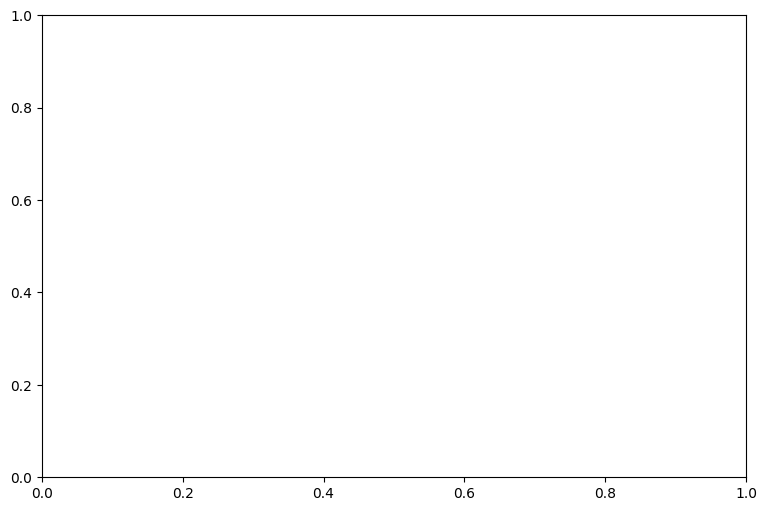

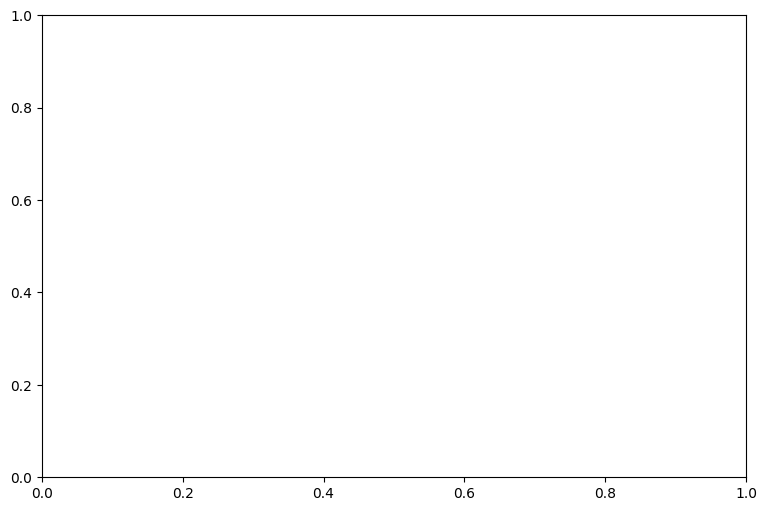

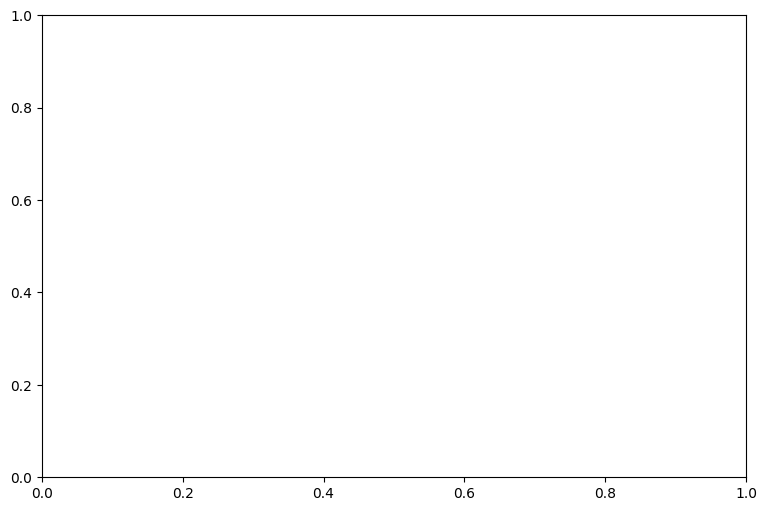

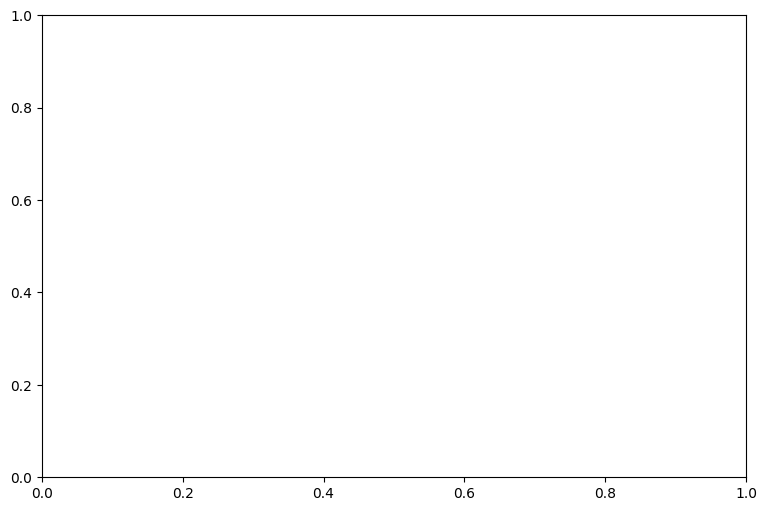

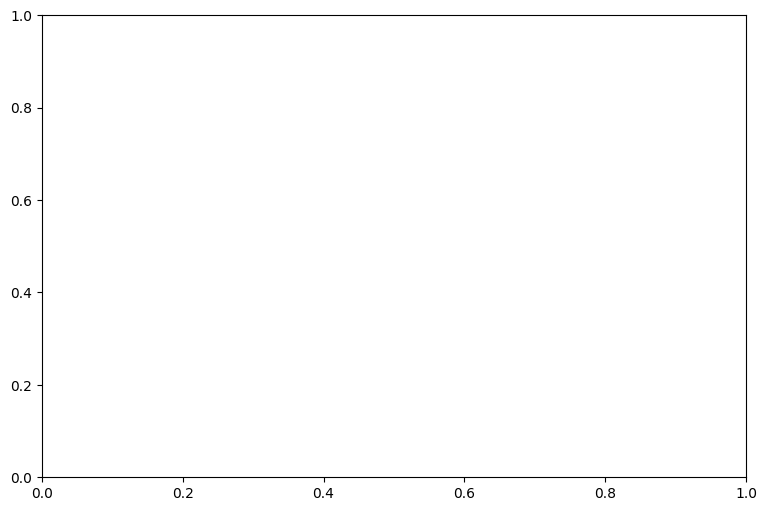

<Figure size 2000x600 with 0 Axes>

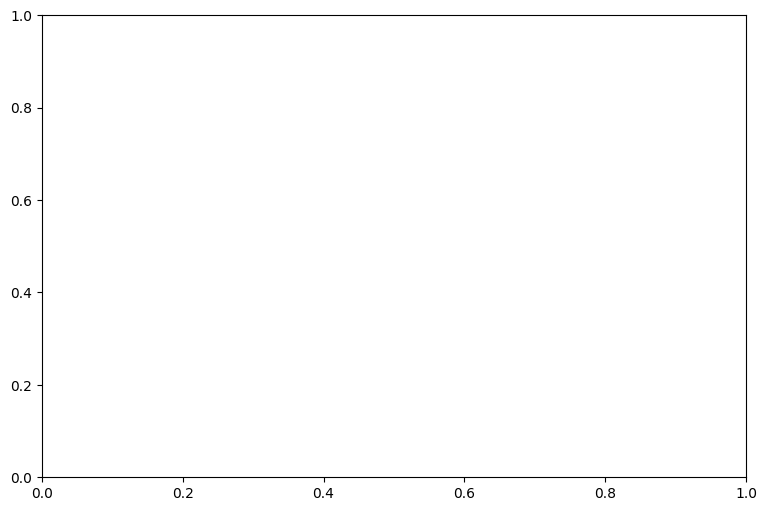

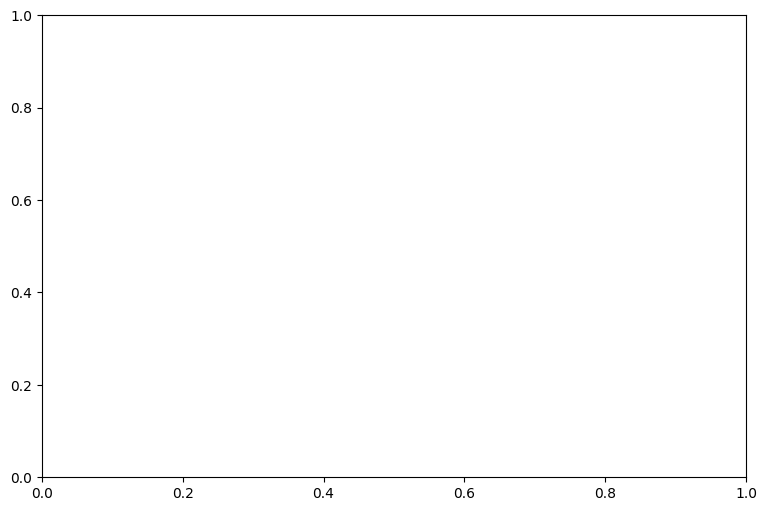

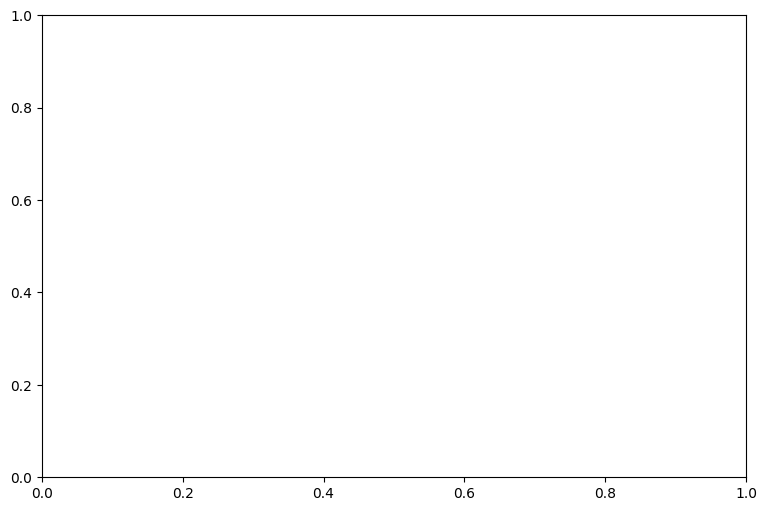

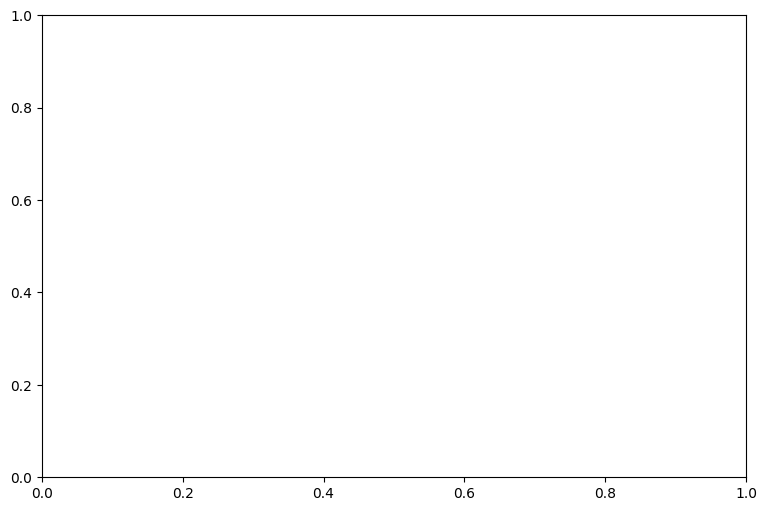

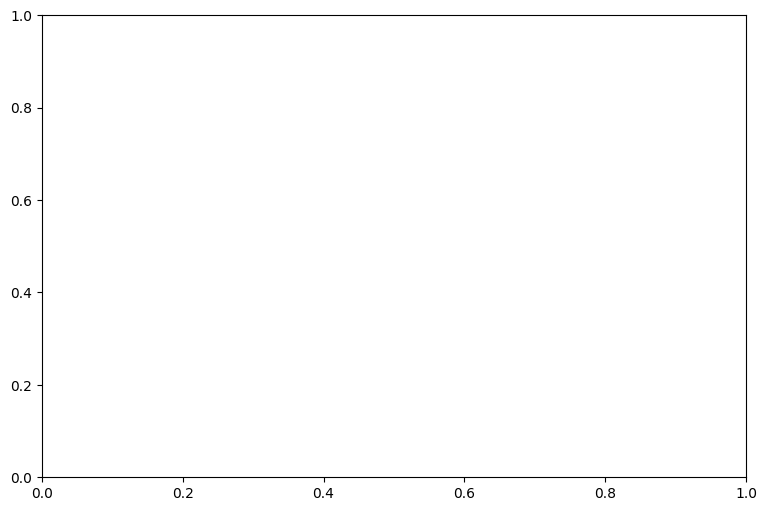

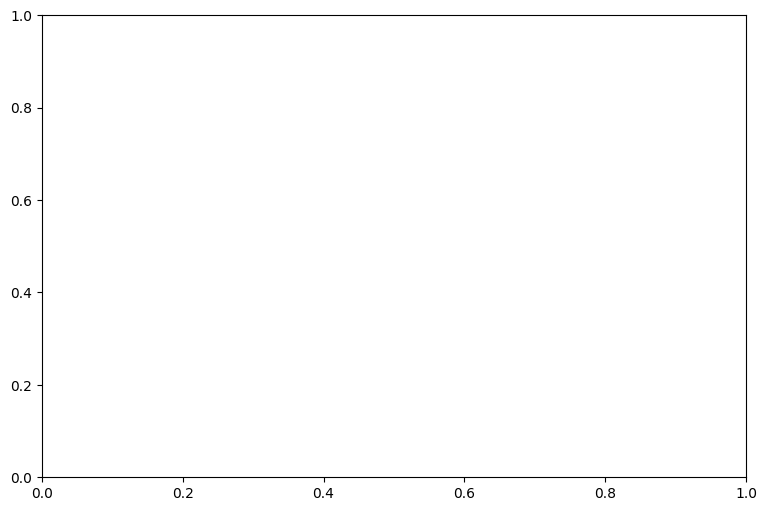

In [4]:
DEVICE = "cuda"

class Args:
    dataset = "squad"
    dataset_key = "context"
    pct_words_masked = 0.3
    span_length = 2
    n_samples = 400
    n_perturbation_list = "100"
    n_perturbation_rounds = 1
    base_model_name = "Qwen/QwQ-32B"#"meta-llama/Llama-2-7b-chat-hf"
    scoring_model_name = ""
    mask_filling_model_name = "t5-3b"
    batch_size = 50
    chunk_size = 20
    n_similarity_samples = 20
    int8 = False
    half = False
    base_half = True
    do_top_k = True
    top_k = 40
    do_top_p = True
    top_p = 0.96
    output_name = ""
    openai_model = None  # Set this if using OpenAI API
    openai_key = None  # Set API key if using OpenAI
    baselines_only = True
    skip_baselines = False
    buffer_size = 1
    mask_top_p = 1.0
    pre_perturb_pct = 0.0
    pre_perturb_span_length = 5
    random_fills = False
    random_fills_tokens = False
    cache_dir = "./cache"

args = Args()  # Now all script references to `args.` will work


API_TOKEN_COUNTER = 0

if args.openai_model is not None:
    import openai
    assert args.openai_key is not None, "Must provide OpenAI API key as --openai_key"
    openai.api_key = args.openai_key

START_DATE = datetime.datetime.now().strftime('%Y-%m-%d')
START_TIME = datetime.datetime.now().strftime('%H-%M-%S-%f')

# define SAVE_FOLDER as the timestamp - base model name - mask filling model name
# create it if it doesn't exist
precision_string = "int8" if args.int8 else ("fp16" if args.half else "fp32")
sampling_string = "top_k" if args.do_top_k else ("top_p" if args.do_top_p else "temp")
output_subfolder = f"{args.output_name}/" if args.output_name else ""
if args.openai_model is None:
    base_model_name = args.base_model_name.replace('/', '_')
else:
    base_model_name = "openai-" + args.openai_model.replace('/', '_')
scoring_model_string = (f"-{args.scoring_model_name}" if args.scoring_model_name else "").replace('/', '_')
SAVE_FOLDER = f"/scratch/network/jl5951/tmp_results/{output_subfolder}{base_model_name}{scoring_model_string}-{args.mask_filling_model_name}-{sampling_string}/{START_DATE}-{START_TIME}-{precision_string}-{args.pct_words_masked}-{args.n_perturbation_rounds}-{args.dataset}-{args.n_samples}"
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)
print(f"Saving results to absolute path: {os.path.abspath(SAVE_FOLDER)}")

# write args to file
with open(os.path.join(SAVE_FOLDER, "args.json"), "w") as f:
    json.dump(args.__dict__, f, indent=4)

mask_filling_model_name = args.mask_filling_model_name
n_samples = args.n_samples
batch_size = args.batch_size
n_perturbation_list = [int(x) for x in args.n_perturbation_list.split(",")]
n_perturbation_rounds = args.n_perturbation_rounds
n_similarity_samples = args.n_similarity_samples

cache_dir = args.cache_dir
os.environ["XDG_CACHE_HOME"] = cache_dir
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
print(f"Using cache dir {cache_dir}")

GPT2_TOKENIZER = transformers.GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)

# generic generative model
base_model, base_tokenizer = load_base_model_and_tokenizer(args.base_model_name)

# mask filling t5 model
if not args.baselines_only and not args.random_fills:
    int8_kwargs = {}
    half_kwargs = {}
    if args.int8:
        int8_kwargs = dict(load_in_8bit=True, device_map='auto', torch_dtype=torch.bfloat16)
    elif args.half:
        half_kwargs = dict(torch_dtype=torch.bfloat16)
    print(f'Loading mask filling model {mask_filling_model_name}...')
    mask_model = transformers.AutoModelForSeq2SeqLM.from_pretrained(mask_filling_model_name, **int8_kwargs, **half_kwargs, cache_dir=cache_dir)
    
    try:
        n_positions = mask_model.config.n_positions
    except AttributeError:
        n_positions = 512
else:
    n_positions = 512
preproc_tokenizer = transformers.AutoTokenizer.from_pretrained('t5-small', model_max_length=512, cache_dir=cache_dir)
mask_tokenizer = transformers.AutoTokenizer.from_pretrained(mask_filling_model_name, padding_side='left', model_max_length=n_positions, cache_dir=cache_dir)
if args.dataset in ['english', 'german']:
    preproc_tokenizer = mask_tokenizer

load_base_model()

print(f'Loading dataset {args.dataset}...')
data = generate_data(args.dataset, args.dataset_key)
if args.random_fills:
    FILL_DICTIONARY = set()
    for texts in data.values():
        for text in texts:
            FILL_DICTIONARY.update(text.split())
    FILL_DICTIONARY = sorted(list(FILL_DICTIONARY))

if args.scoring_model_name:
    print(f'Loading SCORING model {args.scoring_model_name}...')
    del base_model
    del base_tokenizer
    torch.cuda.empty_cache()
    base_model, base_tokenizer = load_base_model_and_tokenizer(args.scoring_model_name)
    load_base_model()  # Load again because we've deleted/replaced the old model

# write the data to a json file in the save folder
with open(os.path.join(SAVE_FOLDER, "raw_data.json"), "w") as f:
    print(f"Writing raw data to {os.path.join(SAVE_FOLDER, 'raw_data.json')}")
    json.dump(data, f)

if not args.skip_baselines:
    baseline_outputs = [run_baseline_threshold_experiment(get_ll, "likelihood", n_samples=n_samples)]
    if args.openai_model is None:
        rank_criterion = lambda text: -get_rank(text, log=False)
        baseline_outputs.append(run_baseline_threshold_experiment(rank_criterion, "rank", n_samples=n_samples))
        logrank_criterion = lambda text: -get_rank(text, log=True)
        baseline_outputs.append(run_baseline_threshold_experiment(logrank_criterion, "log_rank", n_samples=n_samples))
        entropy_criterion = lambda text: get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(entropy_criterion, "entropy", n_samples=n_samples))
        liketropy_criterion = lambda text: get_ll(text)+get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(liketropy_criterion, "liketropy", n_samples=n_samples))
        binocular_criterion = lambda text: get_ll(text)/get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(binocular_criterion, "binocular", n_samples=n_samples))
    
    baseline_outputs.append(eval_supervised(data, model='roberta-base-openai-detector'))
    baseline_outputs.append(eval_supervised(data, model='roberta-large-openai-detector'))

outputs = []

if not args.baselines_only:
    # run perturbation experiments
    for n_perturbations in n_perturbation_list:
        perturbation_results = get_perturbation_results(args.span_length, n_perturbations, n_samples)
        for perturbation_mode in ['d', 'z']:
            output = run_perturbation_experiment(
                perturbation_results, perturbation_mode, span_length=args.span_length, n_perturbations=n_perturbations, n_samples=n_samples)
            outputs.append(output)
            with open(os.path.join(SAVE_FOLDER, f"perturbation_{n_perturbations}_{perturbation_mode}_results.json"), "w") as f:
                json.dump(output, f)

if not args.skip_baselines:
    # write likelihood threshold results to a file
    with open(os.path.join(SAVE_FOLDER, f"likelihood_threshold_results.json"), "w") as f:
        json.dump(baseline_outputs[0], f)

    if args.openai_model is None:
        # write rank threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"rank_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[1], f)

        # write log rank threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"logrank_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[2], f)

        # write entropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"entropy_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[3], f)

        # write liketropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"liketropy_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[4], f)

        # write liketropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"binocular_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[5], f)
    
    
    # write supervised results to a file
    with open(os.path.join(SAVE_FOLDER, f"roberta-base-openai-detector_results.json"), "w") as f:
        json.dump(baseline_outputs[-2], f)
    
    # write supervised results to a file
    with open(os.path.join(SAVE_FOLDER, f"roberta-large-openai-detector_results.json"), "w") as f:
        json.dump(baseline_outputs[-1], f)

    outputs += baseline_outputs

save_roc_curves(outputs)
save_ll_histograms(outputs)
save_llr_histograms(outputs)

# move results folder from tmp_results/ to results/, making sure necessary directories exist
new_folder = SAVE_FOLDER.replace("/scratch/network/jl5951/tmp_results", "/scratch/network/jl5951/results")
if not os.path.exists(os.path.dirname(new_folder)):
    os.makedirs(os.path.dirname(new_folder))
os.rename(SAVE_FOLDER, new_folder)

print(f"Used an *estimated* {API_TOKEN_COUNTER} API tokens (may be inaccurate)")



# Qwen writing

Saving results to absolute path: /scratch/network/jl5951/tmp_results/Qwen_QwQ-32B-t5-3b-top_k/2025-03-24-04-22-14-792110-fp32-0.3-1-writing-400
Using cache dir ./cache
Loading BASE model Qwen/QwQ-32B...


Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

MOVING BASE MODEL TO GPU...DONE (20.39s)
Loading dataset writing...


Token indices sequence length is longer than the specified maximum sequence length for this model (706 > 512). Running this sequence through the model will result in indexing errors


Total number of samples: 1011
Average number of words: 309.6142433234421
Generating samples for batch 0 of 8
Generating samples for batch 1 of 8
Generating samples for batch 2 of 8
Generating samples for batch 3 of 8
Generating samples for batch 4 of 8
Generating samples for batch 5 of 8
Generating samples for batch 6 of 8
Generating samples for batch 7 of 8
Writing raw data to /scratch/network/jl5951/tmp_results/Qwen_QwQ-32B-t5-3b-top_k/2025-03-24-04-22-14-792110-fp32-0.3-1-writing-400/raw_data.json


Computing likelihood criterion: 100%|██████████| 8/8 [04:47<00:00, 35.90s/it]


likelihood_threshold ROC AUC: 0.99998125, PR AUC: 0.9999812264253395, TP@low FPR: 1.0


Computing rank criterion: 100%|██████████| 8/8 [04:49<00:00, 36.14s/it]


rank_threshold ROC AUC: 0.78745625, PR AUC: 0.8372441276621286, TP@low FPR: 0.425


Computing log_rank criterion: 100%|██████████| 8/8 [04:49<00:00, 36.15s/it]


log_rank_threshold ROC AUC: 0.99999375, PR AUC: 0.9999937577930175, TP@low FPR: 1.0


Computing entropy criterion: 100%|██████████| 8/8 [04:47<00:00, 35.91s/it]


entropy_threshold ROC AUC: 0.030968749999999982, PR AUC: 0.3085809886334213, TP@low FPR: 0.0


Computing liketropy criterion: 100%|██████████| 8/8 [09:34<00:00, 71.84s/it]


liketropy_threshold ROC AUC: 0.9999875, PR AUC: 0.9999875466805622, TP@low FPR: 1.0


Computing binocular criterion: 100%|██████████| 8/8 [09:34<00:00, 71.85s/it]
Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


binocular_threshold ROC AUC: 0.99895625, PR AUC: 0.9991351923292822, TP@low FPR: 0.99
Beginning supervised evaluation with roberta-base-openai-detector...


Evaluating fake: 100%|██████████| 8/8 [00:00<00:00, 15.25it/s]


roberta-base-openai-detector ROC AUC: 0.7428687500000001, PR AUC: 0.8018959285573788
Beginning supervised evaluation with roberta-large-openai-detector...


Some weights of the model checkpoint at roberta-large-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Evaluating fake: 100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


roberta-large-openai-detector ROC AUC: 0.6492625000000001, PR AUC: 0.7030369521988973
likelihood_threshold roc_auc: 1.000
rank_threshold roc_auc: 0.787
log_rank_threshold roc_auc: 1.000
entropy_threshold roc_auc: 0.031
liketropy_threshold roc_auc: 1.000
binocular_threshold roc_auc: 0.999
roberta-base-openai-detector roc_auc: 0.743
roberta-large-openai-detector roc_auc: 0.649
Used an *estimated* 0 API tokens (may be inaccurate)


<Figure size 1000x700 with 0 Axes>

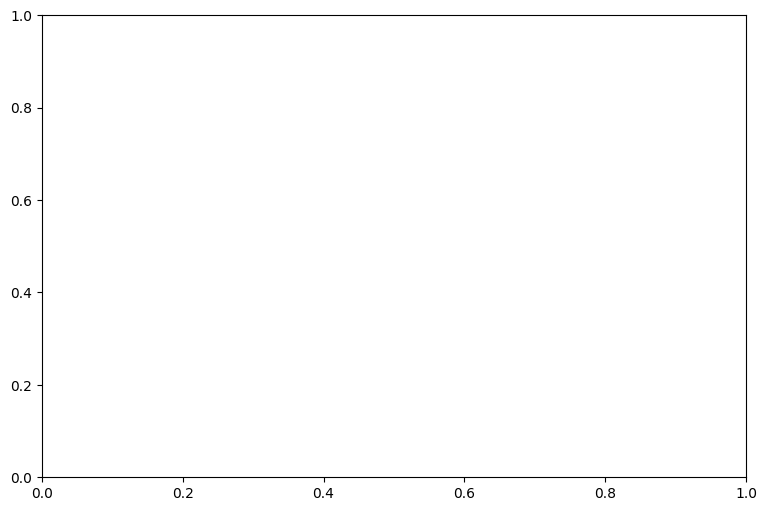

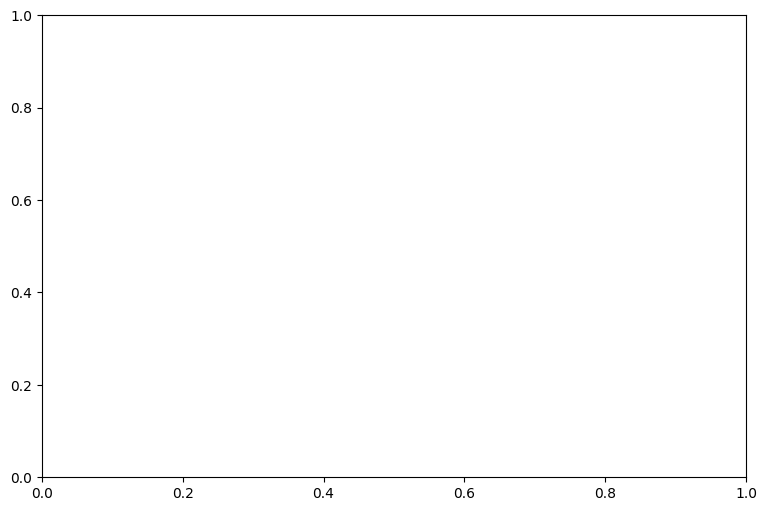

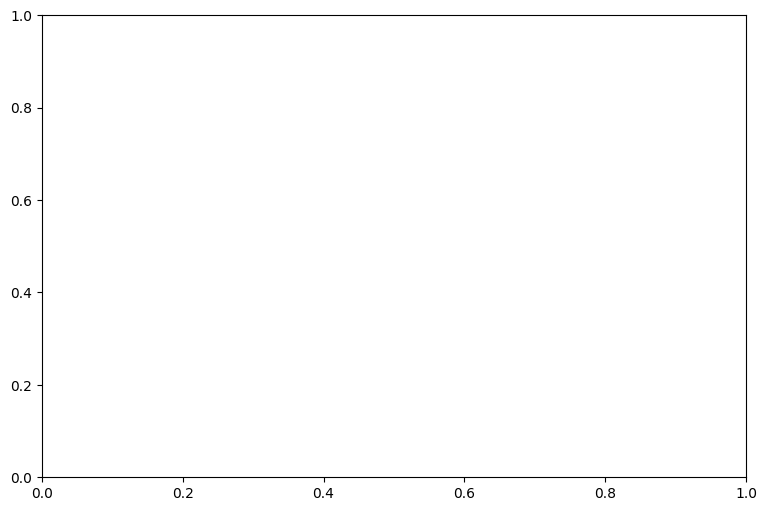

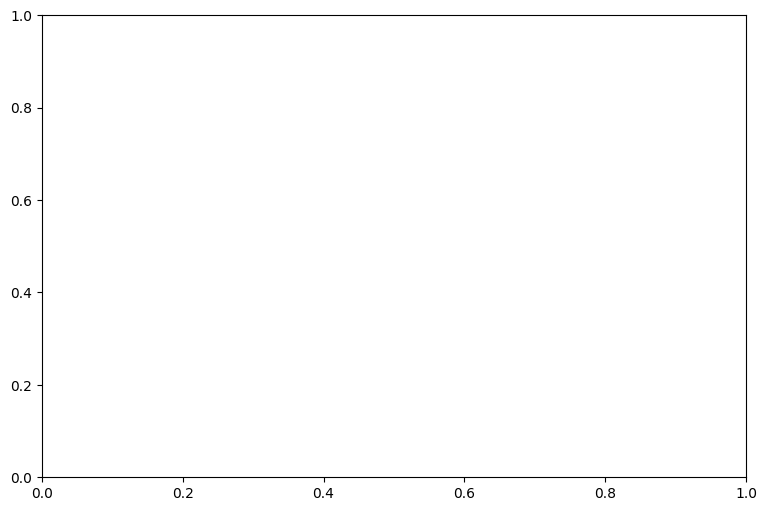

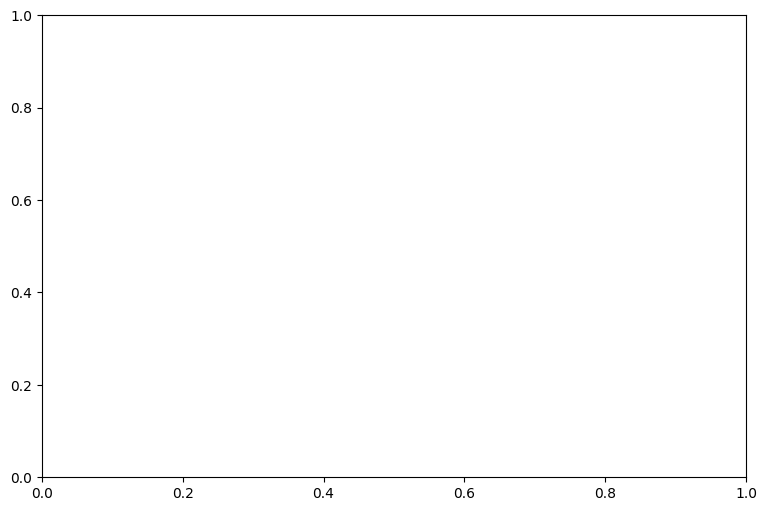

<Figure size 2000x600 with 0 Axes>

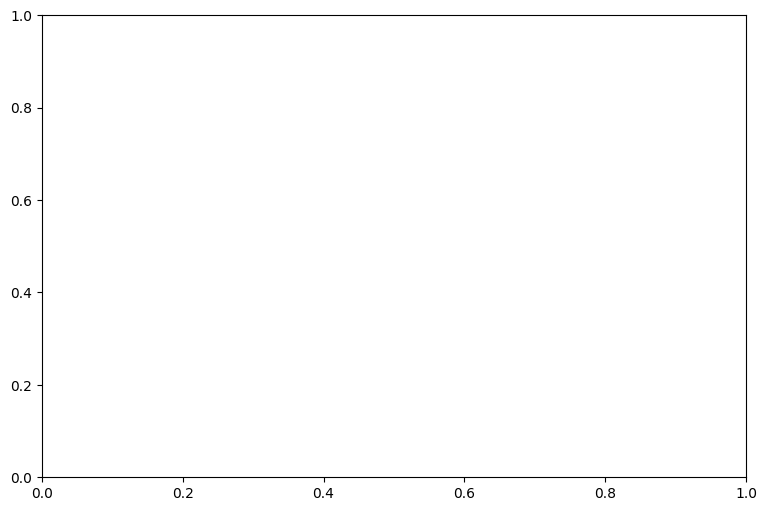

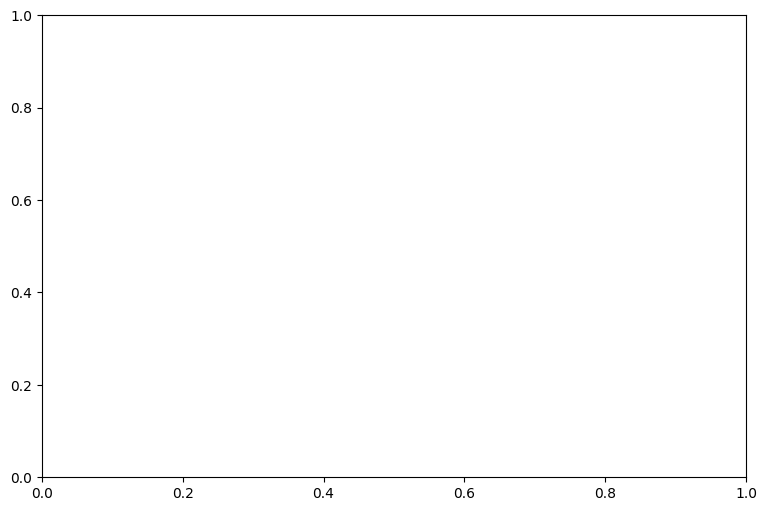

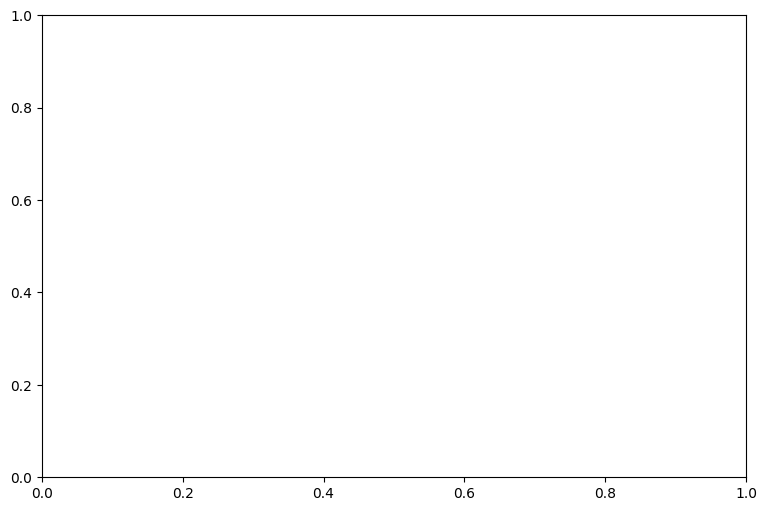

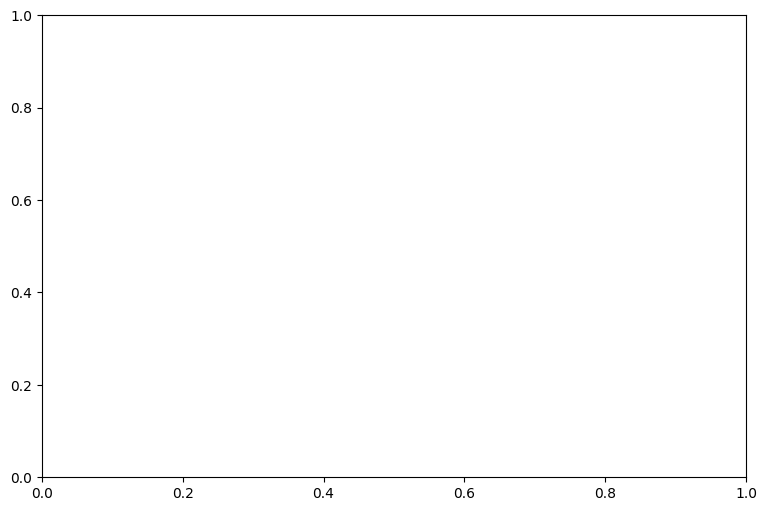

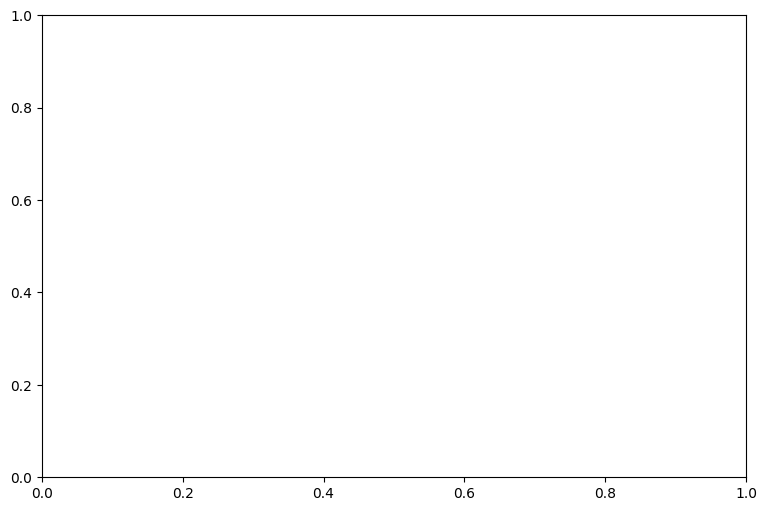

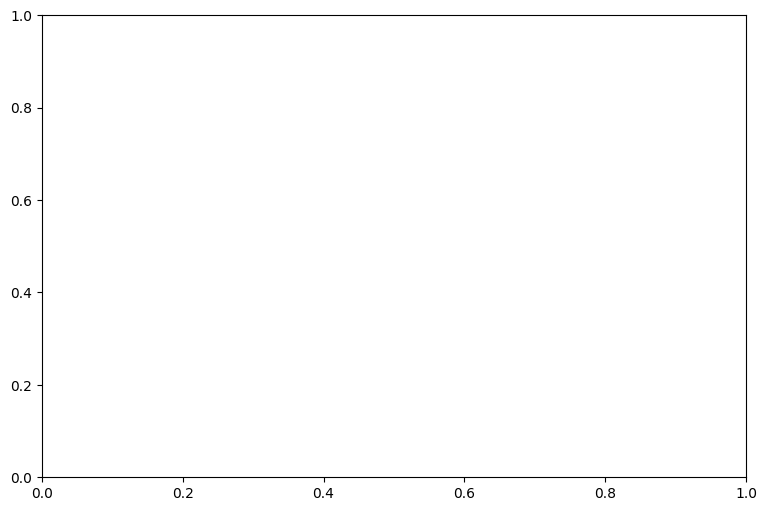

In [6]:
DEVICE = "cuda"

class Args:
    dataset = "writing"
    dataset_key = "story"
    pct_words_masked = 0.3
    span_length = 2
    n_samples = 400
    n_perturbation_list = "100"
    n_perturbation_rounds = 1
    base_model_name = "Qwen/QwQ-32B"#"meta-llama/Llama-2-7b-chat-hf"
    scoring_model_name = ""
    mask_filling_model_name = "t5-3b"
    batch_size = 50
    chunk_size = 20
    n_similarity_samples = 20
    int8 = False
    half = False
    base_half = True
    do_top_k = True
    top_k = 40
    do_top_p = True
    top_p = 0.96
    output_name = ""
    openai_model = None  # Set this if using OpenAI API
    openai_key = None  # Set API key if using OpenAI
    baselines_only = True
    skip_baselines = False
    buffer_size = 1
    mask_top_p = 1.0
    pre_perturb_pct = 0.0
    pre_perturb_span_length = 5
    random_fills = False
    random_fills_tokens = False
    cache_dir = "./cache"

args = Args()  # Now all script references to `args.` will work


API_TOKEN_COUNTER = 0

if args.openai_model is not None:
    import openai
    assert args.openai_key is not None, "Must provide OpenAI API key as --openai_key"
    openai.api_key = args.openai_key

START_DATE = datetime.datetime.now().strftime('%Y-%m-%d')
START_TIME = datetime.datetime.now().strftime('%H-%M-%S-%f')

# define SAVE_FOLDER as the timestamp - base model name - mask filling model name
# create it if it doesn't exist
precision_string = "int8" if args.int8 else ("fp16" if args.half else "fp32")
sampling_string = "top_k" if args.do_top_k else ("top_p" if args.do_top_p else "temp")
output_subfolder = f"{args.output_name}/" if args.output_name else ""
if args.openai_model is None:
    base_model_name = args.base_model_name.replace('/', '_')
else:
    base_model_name = "openai-" + args.openai_model.replace('/', '_')
scoring_model_string = (f"-{args.scoring_model_name}" if args.scoring_model_name else "").replace('/', '_')
SAVE_FOLDER = f"/scratch/network/jl5951/tmp_results/{output_subfolder}{base_model_name}{scoring_model_string}-{args.mask_filling_model_name}-{sampling_string}/{START_DATE}-{START_TIME}-{precision_string}-{args.pct_words_masked}-{args.n_perturbation_rounds}-{args.dataset}-{args.n_samples}"
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)
print(f"Saving results to absolute path: {os.path.abspath(SAVE_FOLDER)}")

# write args to file
with open(os.path.join(SAVE_FOLDER, "args.json"), "w") as f:
    json.dump(args.__dict__, f, indent=4)

mask_filling_model_name = args.mask_filling_model_name
n_samples = args.n_samples
batch_size = args.batch_size
n_perturbation_list = [int(x) for x in args.n_perturbation_list.split(",")]
n_perturbation_rounds = args.n_perturbation_rounds
n_similarity_samples = args.n_similarity_samples

cache_dir = args.cache_dir
os.environ["XDG_CACHE_HOME"] = cache_dir
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
print(f"Using cache dir {cache_dir}")

GPT2_TOKENIZER = transformers.GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)

# generic generative model
base_model, base_tokenizer = load_base_model_and_tokenizer(args.base_model_name)

# mask filling t5 model
if not args.baselines_only and not args.random_fills:
    int8_kwargs = {}
    half_kwargs = {}
    if args.int8:
        int8_kwargs = dict(load_in_8bit=True, device_map='auto', torch_dtype=torch.bfloat16)
    elif args.half:
        half_kwargs = dict(torch_dtype=torch.bfloat16)
    print(f'Loading mask filling model {mask_filling_model_name}...')
    mask_model = transformers.AutoModelForSeq2SeqLM.from_pretrained(mask_filling_model_name, **int8_kwargs, **half_kwargs, cache_dir=cache_dir)
    
    try:
        n_positions = mask_model.config.n_positions
    except AttributeError:
        n_positions = 512
else:
    n_positions = 512
preproc_tokenizer = transformers.AutoTokenizer.from_pretrained('t5-small', model_max_length=512, cache_dir=cache_dir)
mask_tokenizer = transformers.AutoTokenizer.from_pretrained(mask_filling_model_name, padding_side='left', model_max_length=n_positions, cache_dir=cache_dir)
if args.dataset in ['english', 'german']:
    preproc_tokenizer = mask_tokenizer

load_base_model()

print(f'Loading dataset {args.dataset}...')
data = generate_data(args.dataset, args.dataset_key)
if args.random_fills:
    FILL_DICTIONARY = set()
    for texts in data.values():
        for text in texts:
            FILL_DICTIONARY.update(text.split())
    FILL_DICTIONARY = sorted(list(FILL_DICTIONARY))

if args.scoring_model_name:
    print(f'Loading SCORING model {args.scoring_model_name}...')
    del base_model
    del base_tokenizer
    torch.cuda.empty_cache()
    base_model, base_tokenizer = load_base_model_and_tokenizer(args.scoring_model_name)
    load_base_model()  # Load again because we've deleted/replaced the old model

# write the data to a json file in the save folder
with open(os.path.join(SAVE_FOLDER, "raw_data.json"), "w") as f:
    print(f"Writing raw data to {os.path.join(SAVE_FOLDER, 'raw_data.json')}")
    json.dump(data, f)

if not args.skip_baselines:
    baseline_outputs = [run_baseline_threshold_experiment(get_ll, "likelihood", n_samples=n_samples)]
    if args.openai_model is None:
        rank_criterion = lambda text: -get_rank(text, log=False)
        baseline_outputs.append(run_baseline_threshold_experiment(rank_criterion, "rank", n_samples=n_samples))
        logrank_criterion = lambda text: -get_rank(text, log=True)
        baseline_outputs.append(run_baseline_threshold_experiment(logrank_criterion, "log_rank", n_samples=n_samples))
        entropy_criterion = lambda text: get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(entropy_criterion, "entropy", n_samples=n_samples))
        liketropy_criterion = lambda text: get_ll(text)+get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(liketropy_criterion, "liketropy", n_samples=n_samples))
        binocular_criterion = lambda text: get_ll(text)/get_entropy(text)
        baseline_outputs.append(run_baseline_threshold_experiment(binocular_criterion, "binocular", n_samples=n_samples))
    
    baseline_outputs.append(eval_supervised(data, model='roberta-base-openai-detector'))
    baseline_outputs.append(eval_supervised(data, model='roberta-large-openai-detector'))

outputs = []

if not args.baselines_only:
    # run perturbation experiments
    for n_perturbations in n_perturbation_list:
        perturbation_results = get_perturbation_results(args.span_length, n_perturbations, n_samples)
        for perturbation_mode in ['d', 'z']:
            output = run_perturbation_experiment(
                perturbation_results, perturbation_mode, span_length=args.span_length, n_perturbations=n_perturbations, n_samples=n_samples)
            outputs.append(output)
            with open(os.path.join(SAVE_FOLDER, f"perturbation_{n_perturbations}_{perturbation_mode}_results.json"), "w") as f:
                json.dump(output, f)

if not args.skip_baselines:
    # write likelihood threshold results to a file
    with open(os.path.join(SAVE_FOLDER, f"likelihood_threshold_results.json"), "w") as f:
        json.dump(baseline_outputs[0], f)

    if args.openai_model is None:
        # write rank threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"rank_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[1], f)

        # write log rank threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"logrank_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[2], f)

        # write entropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"entropy_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[3], f)

        # write liketropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"liketropy_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[4], f)

        # write liketropy threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"binocular_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[5], f)
    
    
    # write supervised results to a file
    with open(os.path.join(SAVE_FOLDER, f"roberta-base-openai-detector_results.json"), "w") as f:
        json.dump(baseline_outputs[-2], f)
    
    # write supervised results to a file
    with open(os.path.join(SAVE_FOLDER, f"roberta-large-openai-detector_results.json"), "w") as f:
        json.dump(baseline_outputs[-1], f)

    outputs += baseline_outputs

save_roc_curves(outputs)
save_ll_histograms(outputs)
save_llr_histograms(outputs)

# move results folder from tmp_results/ to results/, making sure necessary directories exist
new_folder = SAVE_FOLDER.replace("/scratch/network/jl5951/tmp_results", "/scratch/network/jl5951/results")
if not os.path.exists(os.path.dirname(new_folder)):
    os.makedirs(os.path.dirname(new_folder))
os.rename(SAVE_FOLDER, new_folder)

print(f"Used an *estimated* {API_TOKEN_COUNTER} API tokens (may be inaccurate)")

